# 3層ANNによる非線形歪補償
最も基本的な、入力層・中間層・出力層からなる3層ANNによる補償

In [3]:
#import
import sys
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preprocessing

## 1.1 データの整形

In [4]:
def data_shaping(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [103]:
def data_shaping2(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real - input_signal[j].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag - input_signal[j].imag
        y[i, 0] = input_signal[j].real - input_signal[j].real
        y[i, 1] = input_signal[j].imag - input_signal[j].imag
    return x, y

In [107]:
#動作確認
tap = 29
max_tap = 51

df_dir = '../data/input/prbs.csv'
df = pd.read_csv(df_dir, index_col=0)  # dataframe読み込み
condition = (df['N']==13) & (df['itr']==1) & (df['form']=='RZ16QAM') & (df['n']==32) & (df['equalize']==False) & (df['baudrate']==28) & (df['PdBm']==1)
sgnl = load_pickle(df[condition].iloc[0]['data_path'])  # dataframeから条件と合う行を取得し,pickleの保存先(data_path)にアクセス
lc = sgnl.linear_compensation(500, sgnl.signal['x_500'])
x, y = data_shaping2(sgnl.signal['x_0'][16::32], lc[16::32], max_tap, tap)  # ANNに入力できるようにデータを整形

print('x size: ', x.shape)
print('y size: ', y.shape)
print(x[0])
print(y[0])

x size:  (1998, 58)
y size:  (1998, 2)
[ 122073.71248018  -76895.01777447   38329.10847588   73016.78389501
   39868.58160496   71791.93729904  102978.56559676   -9581.13199886
   78723.57942451   49900.16097891   99582.64380303   -8682.91604546
   -7806.03250073   -8124.85942929   -6130.48948581  -10700.41668101
  139820.91316654  -32221.20373515  107407.54832772  -12335.262423
   83530.96713849  -56338.38686943   81085.85483221  -58455.03500952
   -3019.77143879  -16301.62325537   20614.43170419   30636.86896402
   17455.00177471   30178.61318274  102749.59181866 -114573.05006738
   56089.01540369    6850.25457188   22844.21477036   25744.30582796
   58928.28799471  -98512.00564643   59200.09356176    7938.72152509
   18713.74672411   29148.43860649  -21604.78142748  -51891.71692434
   16300.5833543    27084.75980359    3420.40838015   -8178.2385842
  166509.75155902    9751.22468861  120629.86096627  -73162.79408208
  -23450.58492712  -57747.80661272   40028.38986819  -36540.3646341

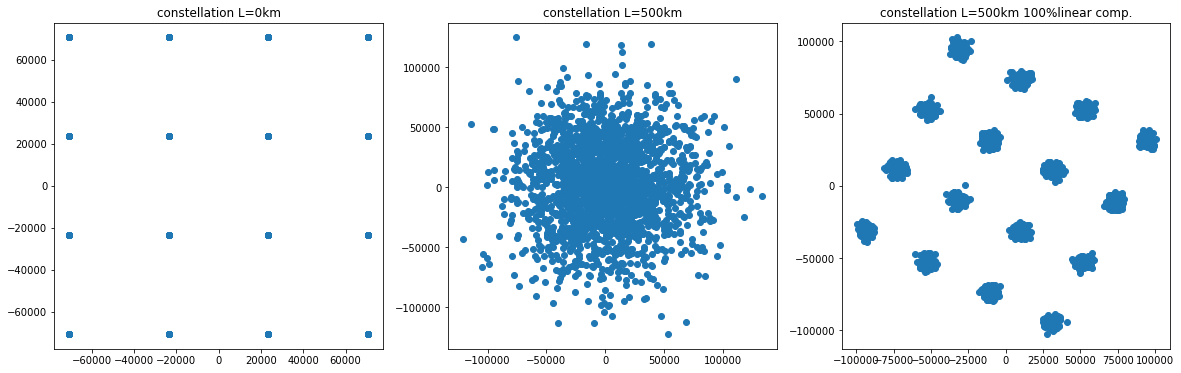

In [108]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(sgnl.signal['x_0'][16::32].real, sgnl.signal['x_0'][16::32].imag, 'o')
ax1.set_title('constellation L=0km')

ax2.plot(sgnl.signal['x_500'][16::32].real, sgnl.signal['x_500'][16::32].imag, 'o')
ax2.set_title('constellation L=500km')

ax3.plot(lc[16::32].real, lc[16::32].imag, 'o')
ax3.set_title('constellation L=500km 100%linear comp.');

## 1.2 平均,標準偏差の計算

In [109]:
mean = np.mean(x)
std = np.std(x)

print('mean: ', mean)
print('std: ', std)

mean:  483.09034297663067
std:  72712.07475468544


# 2. Dataset定義

In [5]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

In [111]:
#動作確認
train_dataset = Dataset(x=x, y=y, mean=mean, std=std)

index = 0
x_normalized, y_normalized = train_dataset.__getitem__(index)
x_array = x_normalized.detach().numpy()

print('mean: ', np.mean(x_array))
print('std: ', np.std(x_array))
print(x_normalized)
print(y_normalized)

mean:  0.27655828
std:  0.8249099
tensor([ 1.6722, -1.0642,  0.5205,  0.9975,  0.5417,  0.9807,  1.4096, -0.1384,
         1.0760,  0.6796,  1.3629, -0.1261, -0.1140, -0.1184, -0.0910, -0.1538,
         1.9163, -0.4498,  1.4705, -0.1763,  1.1421, -0.7815,  1.1085, -0.8106,
        -0.0482, -0.2308,  0.2769,  0.4147,  0.2334,  0.4084,  1.4065, -1.5824,
         0.7647,  0.0876,  0.3075,  0.3474,  0.8038, -1.3615,  0.8075,  0.1025,
         0.2507,  0.3942, -0.3038, -0.7203,  0.2175,  0.3658,  0.0404, -0.1191,
         2.2833,  0.1275,  1.6524, -1.0128, -0.3292, -0.8008,  0.5439, -0.5092,
         1.0959, -0.7286])
tensor([-0.0066, -0.0066])


In [112]:
batch_size = 100

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader}

# 3. Model定義

In [6]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [114]:
#動作確認
hidden_neuron = 300
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron).to(device)
for x, y in train_dataloader:
    output = model(x)
    print(output[:6])
    break

Device available now: cpu
tensor([[ 0.3180,  0.0384],
        [ 0.4322,  0.0349],
        [ 0.6066, -0.3669],
        [ 0.3685, -0.3020],
        [ 0.0462, -0.0678],
        [ 0.5250, -0.3377]], grad_fn=<SliceBackward>)


# 4. train定義

In [7]:
def evm_score(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    evm = torch.sqrt(tmp / len(y_pred))
    return evm

In [8]:
def train_model(device, model, dataloaders_dict, criterion, optimizer, epochs, epochs_section=None):
    for epoch in range(epochs):
        if epochs_section is not None:
            epoch += epochs_section[0]
            end_epoch = epochs_section[1]
        else:
            end_epoch = epochs
        
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                x = x.to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms += (evm_score(outputs, y)) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, end_epoch, phase, epoch_loss, epoch_evm))
    return model

In [119]:
#動作確認
epochs = 5
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs);

0:00:00 | Epoch: 1/5 | train Loss: 0.02162 | EVM: 2.213e+03
0:00:00 | Epoch: 2/5 | train Loss: 0.005235 | EVM: 1.089e+03
0:00:00 | Epoch: 3/5 | train Loss: 0.003076 | EVM: 834.7
0:00:00 | Epoch: 4/5 | train Loss: 0.002175 | EVM: 701.9
0:00:00 | Epoch: 5/5 | train Loss: 0.001783 | EVM: 635.5


# 5. 実行

In [81]:
#結果を保存しない
tap = 201
max_tap = 501
batch_size = 100
hidden_neuron = 300
epochs = 500
lr = 0.001

device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

df_dir = '../data/input/'
df0 = pd.read_csv(df_dir+'prbs.csv', index_col=0)

condition0 = (df0['N']==13) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl0 = load_pickle(df0[condition0].iloc[0]['data_path'])
lc0 = sgnl0.linear_compensation(2500, sgnl0.signal['x_2500'])
x0, y0 = data_shaping(sgnl0.signal['x_0'][16::32], lc0[16::32], max_tap, tap)

condition1 = (df0['N']==17) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl1 = load_pickle(df0[condition1].iloc[0]['data_path'])
lc1 = sgnl1.linear_compensation(2500, sgnl1.signal['x_2500'])
x1, y1 = data_shaping(sgnl1.signal['x_0'][16::32], lc1[16::32], max_tap, tap)

mean = np.mean(x0)
std = np.std(x0)

train_dataset = Dataset(x=x0, y=y0, mean=mean, std=std)
val_dataset = Dataset(x=x1, y=y1, mean=mean, std=std)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)

Device available now: cpu
0:00:00 | Epoch: 1/500 | train Loss: 1.025 | EVM: 103.9
0:00:05 | Epoch: 1/500 | val Loss: 0.9298 | EVM: 98.28
0:00:00 | Epoch: 2/500 | train Loss: 0.597 | EVM: 79.57
0:00:05 | Epoch: 2/500 | val Loss: 0.8148 | EVM: 93.7
0:00:00 | Epoch: 3/500 | train Loss: 0.3386 | EVM: 62.73
0:00:05 | Epoch: 3/500 | val Loss: 0.6996 | EVM: 89.65
0:00:00 | Epoch: 4/500 | train Loss: 0.1544 | EVM: 46.09
0:00:06 | Epoch: 4/500 | val Loss: 0.566 | EVM: 82.64
0:00:00 | Epoch: 5/500 | train Loss: 0.04961 | EVM: 27.83
0:00:05 | Epoch: 5/500 | val Loss: 0.4524 | EVM: 74.16
0:00:00 | Epoch: 6/500 | train Loss: 0.01432 | EVM: 15.87
0:00:06 | Epoch: 6/500 | val Loss: 0.3871 | EVM: 68.05
0:00:00 | Epoch: 7/500 | train Loss: 0.005133 | EVM: 9.67
0:00:06 | Epoch: 7/500 | val Loss: 0.3719 | EVM: 66.46
0:00:00 | Epoch: 8/500 | train Loss: 0.002005 | EVM: 6.008
0:00:06 | Epoch: 8/500 | val Loss: 0.3748 | EVM: 66.7
0:00:00 | Epoch: 9/500 | train Loss: 0.0006913 | EVM: 3.606
0:00:06 | Epoch: 9

0:00:06 | Epoch: 71/500 | val Loss: 0.3168 | EVM: 61.2
0:00:00 | Epoch: 72/500 | train Loss: 0.0003631 | EVM: 2.656
0:00:06 | Epoch: 72/500 | val Loss: 0.318 | EVM: 61.2
0:00:00 | Epoch: 73/500 | train Loss: 0.0002599 | EVM: 2.215
0:00:06 | Epoch: 73/500 | val Loss: 0.3165 | EVM: 61.13
0:00:00 | Epoch: 74/500 | train Loss: 0.0001904 | EVM: 1.912
0:00:07 | Epoch: 74/500 | val Loss: 0.3174 | EVM: 61.15
0:00:00 | Epoch: 75/500 | train Loss: 0.0001514 | EVM: 1.702
0:00:06 | Epoch: 75/500 | val Loss: 0.3168 | EVM: 61.14
0:00:00 | Epoch: 76/500 | train Loss: 0.0001251 | EVM: 1.536
0:00:06 | Epoch: 76/500 | val Loss: 0.317 | EVM: 61.12
0:00:00 | Epoch: 77/500 | train Loss: 0.000106 | EVM: 1.431
0:00:06 | Epoch: 77/500 | val Loss: 0.3168 | EVM: 61.15
0:00:00 | Epoch: 78/500 | train Loss: 9.006e-05 | EVM: 1.335
0:00:06 | Epoch: 78/500 | val Loss: 0.317 | EVM: 61.13
0:00:00 | Epoch: 79/500 | train Loss: 7.409e-05 | EVM: 1.172
0:00:06 | Epoch: 79/500 | val Loss: 0.3167 | EVM: 61.13
0:00:00 | Epoc

0:00:06 | Epoch: 141/500 | val Loss: 0.2792 | EVM: 57.36
0:00:00 | Epoch: 142/500 | train Loss: 0.0004364 | EVM: 2.849
0:00:06 | Epoch: 142/500 | val Loss: 0.2781 | EVM: 57.25
0:00:00 | Epoch: 143/500 | train Loss: 0.0004044 | EVM: 2.83
0:00:06 | Epoch: 143/500 | val Loss: 0.2792 | EVM: 57.35
0:00:00 | Epoch: 144/500 | train Loss: 0.0004151 | EVM: 2.821
0:00:06 | Epoch: 144/500 | val Loss: 0.2792 | EVM: 57.32
0:00:00 | Epoch: 145/500 | train Loss: 0.0004389 | EVM: 2.812
0:00:06 | Epoch: 145/500 | val Loss: 0.278 | EVM: 57.25
0:00:00 | Epoch: 146/500 | train Loss: 0.0004402 | EVM: 2.897
0:00:06 | Epoch: 146/500 | val Loss: 0.2778 | EVM: 57.23
0:00:00 | Epoch: 147/500 | train Loss: 0.0005001 | EVM: 3.079
0:00:06 | Epoch: 147/500 | val Loss: 0.2783 | EVM: 57.26
0:00:00 | Epoch: 148/500 | train Loss: 0.0005628 | EVM: 3.197
0:00:06 | Epoch: 148/500 | val Loss: 0.2788 | EVM: 57.3
0:00:00 | Epoch: 149/500 | train Loss: 0.0006054 | EVM: 3.404
0:00:06 | Epoch: 149/500 | val Loss: 0.2786 | EVM: 

0:00:06 | Epoch: 211/500 | val Loss: 0.2362 | EVM: 52.79
0:00:00 | Epoch: 212/500 | train Loss: 0.002182 | EVM: 6.531
0:00:07 | Epoch: 212/500 | val Loss: 0.2365 | EVM: 52.93
0:00:00 | Epoch: 213/500 | train Loss: 0.002344 | EVM: 6.735
0:00:06 | Epoch: 213/500 | val Loss: 0.2361 | EVM: 52.89
0:00:00 | Epoch: 214/500 | train Loss: 0.002369 | EVM: 6.911
0:00:06 | Epoch: 214/500 | val Loss: 0.2362 | EVM: 52.84
0:00:00 | Epoch: 215/500 | train Loss: 0.002289 | EVM: 6.524
0:00:06 | Epoch: 215/500 | val Loss: 0.237 | EVM: 52.84
0:00:00 | Epoch: 216/500 | train Loss: 0.002171 | EVM: 6.475
0:00:06 | Epoch: 216/500 | val Loss: 0.2361 | EVM: 52.83
0:00:00 | Epoch: 217/500 | train Loss: 0.002168 | EVM: 6.488
0:00:06 | Epoch: 217/500 | val Loss: 0.2341 | EVM: 52.55
0:00:00 | Epoch: 218/500 | train Loss: 0.002131 | EVM: 6.372
0:00:06 | Epoch: 218/500 | val Loss: 0.2336 | EVM: 52.59
0:00:00 | Epoch: 219/500 | train Loss: 0.002183 | EVM: 6.493
0:00:07 | Epoch: 219/500 | val Loss: 0.2329 | EVM: 52.44


0:00:05 | Epoch: 281/500 | val Loss: 0.1968 | EVM: 48.57
0:00:00 | Epoch: 282/500 | train Loss: 0.002228 | EVM: 6.34
0:00:05 | Epoch: 282/500 | val Loss: 0.1963 | EVM: 48.44
0:00:00 | Epoch: 283/500 | train Loss: 0.002027 | EVM: 6.111
0:00:04 | Epoch: 283/500 | val Loss: 0.194 | EVM: 48.23
0:00:00 | Epoch: 284/500 | train Loss: 0.00197 | EVM: 5.961
0:00:05 | Epoch: 284/500 | val Loss: 0.195 | EVM: 48.32
0:00:00 | Epoch: 285/500 | train Loss: 0.001896 | EVM: 5.848
0:00:05 | Epoch: 285/500 | val Loss: 0.1947 | EVM: 48.23
0:00:00 | Epoch: 286/500 | train Loss: 0.001766 | EVM: 5.805
0:00:04 | Epoch: 286/500 | val Loss: 0.1959 | EVM: 48.34
0:00:00 | Epoch: 287/500 | train Loss: 0.001748 | EVM: 5.909
0:00:05 | Epoch: 287/500 | val Loss: 0.1951 | EVM: 48.24
0:00:00 | Epoch: 288/500 | train Loss: 0.001696 | EVM: 5.743
0:00:04 | Epoch: 288/500 | val Loss: 0.1947 | EVM: 48.19
0:00:00 | Epoch: 289/500 | train Loss: 0.001587 | EVM: 5.609
0:00:04 | Epoch: 289/500 | val Loss: 0.1927 | EVM: 47.96
0:0

0:00:05 | Epoch: 351/500 | val Loss: 0.1672 | EVM: 44.87
0:00:00 | Epoch: 352/500 | train Loss: 0.00194 | EVM: 6.164
0:00:05 | Epoch: 352/500 | val Loss: 0.1684 | EVM: 45.02
0:00:00 | Epoch: 353/500 | train Loss: 0.002196 | EVM: 6.531
0:00:05 | Epoch: 353/500 | val Loss: 0.1706 | EVM: 45.25
0:00:00 | Epoch: 354/500 | train Loss: 0.002309 | EVM: 6.592
0:00:05 | Epoch: 354/500 | val Loss: 0.1675 | EVM: 44.9
0:00:00 | Epoch: 355/500 | train Loss: 0.002484 | EVM: 6.917
0:00:04 | Epoch: 355/500 | val Loss: 0.1672 | EVM: 44.95
0:00:00 | Epoch: 356/500 | train Loss: 0.002472 | EVM: 6.994
0:00:05 | Epoch: 356/500 | val Loss: 0.1646 | EVM: 44.55
0:00:00 | Epoch: 357/500 | train Loss: 0.002319 | EVM: 6.729
0:00:05 | Epoch: 357/500 | val Loss: 0.1629 | EVM: 44.5
0:00:00 | Epoch: 358/500 | train Loss: 0.002341 | EVM: 6.64
0:00:05 | Epoch: 358/500 | val Loss: 0.1653 | EVM: 44.65
0:00:00 | Epoch: 359/500 | train Loss: 0.002856 | EVM: 7.229
0:00:05 | Epoch: 359/500 | val Loss: 0.1642 | EVM: 44.48
0:0

0:00:05 | Epoch: 421/500 | val Loss: 0.1414 | EVM: 41.5
0:00:00 | Epoch: 422/500 | train Loss: 0.001038 | EVM: 4.537
0:00:05 | Epoch: 422/500 | val Loss: 0.139 | EVM: 41.2
0:00:00 | Epoch: 423/500 | train Loss: 0.001029 | EVM: 4.427
0:00:05 | Epoch: 423/500 | val Loss: 0.1422 | EVM: 41.59
0:00:00 | Epoch: 424/500 | train Loss: 0.001032 | EVM: 4.329
0:00:05 | Epoch: 424/500 | val Loss: 0.1378 | EVM: 41.12
0:00:00 | Epoch: 425/500 | train Loss: 0.00104 | EVM: 4.341
0:00:05 | Epoch: 425/500 | val Loss: 0.1417 | EVM: 41.5
0:00:00 | Epoch: 426/500 | train Loss: 0.001027 | EVM: 4.273
0:00:05 | Epoch: 426/500 | val Loss: 0.1383 | EVM: 41.12
0:00:00 | Epoch: 427/500 | train Loss: 0.0009316 | EVM: 4.202
0:00:05 | Epoch: 427/500 | val Loss: 0.1389 | EVM: 41.23
0:00:00 | Epoch: 428/500 | train Loss: 0.0009199 | EVM: 4.225
0:00:05 | Epoch: 428/500 | val Loss: 0.1396 | EVM: 41.27
0:00:00 | Epoch: 429/500 | train Loss: 0.0009638 | EVM: 4.196
0:00:05 | Epoch: 429/500 | val Loss: 0.1395 | EVM: 41.22
0

0:00:00 | Epoch: 491/500 | train Loss: 0.001307 | EVM: 4.797
0:00:04 | Epoch: 491/500 | val Loss: 0.1249 | EVM: 39.31
0:00:00 | Epoch: 492/500 | train Loss: 0.001275 | EVM: 4.763
0:00:04 | Epoch: 492/500 | val Loss: 0.1241 | EVM: 39.16
0:00:00 | Epoch: 493/500 | train Loss: 0.001233 | EVM: 4.77
0:00:05 | Epoch: 493/500 | val Loss: 0.1237 | EVM: 39.08
0:00:00 | Epoch: 494/500 | train Loss: 0.001243 | EVM: 4.763
0:00:04 | Epoch: 494/500 | val Loss: 0.1225 | EVM: 39.03
0:00:00 | Epoch: 495/500 | train Loss: 0.001263 | EVM: 4.857
0:00:04 | Epoch: 495/500 | val Loss: 0.1254 | EVM: 39.31
0:00:00 | Epoch: 496/500 | train Loss: 0.001367 | EVM: 5.014
0:00:04 | Epoch: 496/500 | val Loss: 0.1218 | EVM: 38.87
0:00:00 | Epoch: 497/500 | train Loss: 0.001376 | EVM: 5.059
0:00:04 | Epoch: 497/500 | val Loss: 0.124 | EVM: 39.15
0:00:00 | Epoch: 498/500 | train Loss: 0.001497 | EVM: 5.292
0:00:04 | Epoch: 498/500 | val Loss: 0.1215 | EVM: 38.82
0:00:00 | Epoch: 499/500 | train Loss: 0.001601 | EVM: 5.3

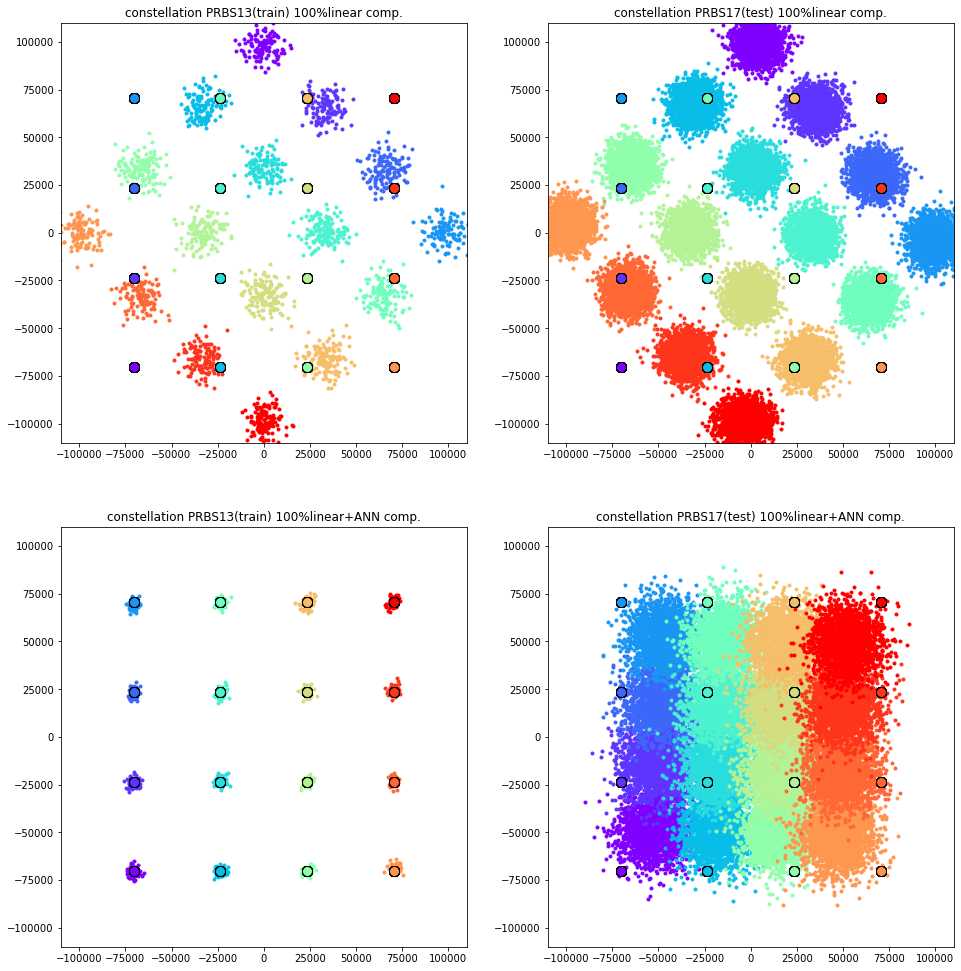

In [82]:
#可視化
annc0 = model(train_dataset[:][0]).detach().numpy()
annc0 = annc0 * std + mean
annc0 = annc0[:, 0] + annc0[:, 1] * 1j
y0 = train_dataset[:][1].detach().numpy()
y0 = y0 * std + mean
y0 = y0.astype(np.int32)
y0 = y0[:, 0] + y0[:, 1] * 1j
annc1 = model(val_dataset[:][0]).detach().numpy()
annc1 = annc1 * std + mean
annc1 = annc1[:, 0] + annc1[:, 1] * 1j
y1 = val_dataset[:][1].detach().numpy()
y1 = y1 * std + mean
y1 = y1.astype(np.int32)
y1 = y1[:, 0] + y1[:, 1] * 1j

lim = 110000
cm = plt.get_cmap('rainbow', 16)

seq0 = sgnl0.signal['x_0'][16::32]
seq1 = sgnl1.signal['x_0'][16::32]
symbol, inverse, counts = np.unique(seq0, return_inverse=True, return_counts=True)
symbol_int = symbol.real.astype(np.int32) + symbol.imag.astype(np.int32) * 1j

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for i in range(len(symbol)):
    ax1.plot(lc0[16::32][seq0 == symbol[i]].real, lc0[16::32][seq0 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax1.plot(seq0[seq0 == symbol[i]].real, seq0[seq0 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax2.plot(lc1[16::32][seq1 == symbol[i]].real, lc1[16::32][seq1 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax2.plot(seq1[seq1 == symbol[i]].real, seq1[seq1 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax3.plot(annc0[y0 == symbol_int[i]].real, annc0[y0 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax3.plot(y0[y0 == symbol_int[i]].real, y0[y0 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax4.plot(annc1[y1 == symbol_int[i]].real, annc1[y1 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax4.plot(y1[y1 == symbol_int[i]].real, y1[y1 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);

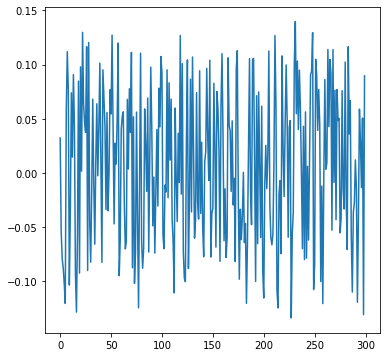

In [129]:
#重み可視化
weight = model.state_dict()['fc1.weight'].detach().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(weight[:, 0])

In [47]:
def train_ann(tap, PdBm, N):
    #結果と条件を../data/params/ANN.csvに保存する
    #tap = 1
    max_tap = 501
    batch_size = 100
    neuron = 300
    epochs = 500
    lr = 0.001

    device = torch.device('cpu') #'cuda' if torch.cuda.is_available() else 
    print('Device available now:', device)

    signal_type = 'prbs'

    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    #PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 2500  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか

    if signal_type == 'prbs':
        #N = 13  # PRBSの次数
        itr = 1  # PRBSの繰り返し回数
    elif signal_type == 'random':
        seed = 1234  # 乱数シード
        bit_num = 100000  # ビット長を指定
    elif signal_type == 'image':
        target_dir = 'train_0'
        step = 10  # =10 ---> (768, 1024) ---> (76, 102)
        image_number = '0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29'
        image_number_split = image_number.split(', ')
        ebtb = True  # 8B10Bを行うか

    # prbs.csv or random.csv or image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

    # if ANN.csv がある: pandasで読み込む if ANN.csvがない: 新しいDataFrameを作る
    l_df_dir = '../data/params/ANN.csv'
    if os.path.exists(l_df_dir):
        l_df = pd.read_csv(l_df_dir, index_col=0)
    else:
        cols = ['tap', 'max_tap', 'batch_size', 'neuron', 'epochs', 'learning_rate', 'N', 'itr', 'seed', 'bit_num', 'target_dir', 'step', 'image_number', 'ebtb', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'params_path', 'train_samples']
        l_df = pd.DataFrame(index=[], columns=cols)
        l_df.to_csv(l_df_dir)

    # 指定した学習条件と伝送条件
    l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)
    t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                            gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    if signal_type == 'prbs':
        condition_t = 'N=='+str(N)+'&itr=='+str(itr)
        condition_l = condition_t
        condition_list = [N, itr] + [None] * 6
    elif signal_type == 'random':
        condition_t = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
        condition_l = condition_t
        condition_list = [None] * 2 + [seed, bit_num] + [None] * 4
    elif signal_type == 'image':
        condition_t = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[0]+'&ebtb=='+str(ebtb)
        condition_l = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
        condition_list = [None] * 4 + [target_dir, step, image_number, ebtb]

    # prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(condition_t + '&' + t_condition)

    # ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(l_condition + '&' + condition_l + '&' + t_condition + '&Lmax=='+str(Lmax))

    # 後で異なる値が代入されるもの以外をSeriesにしてしまう(epochs, params_path, train_samplesだけNone)
    sr = pd.Series([tap, max_tap, batch_size, neuron, None, lr] + condition_list + [form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, None, None], index=l_df.columns)

    #if epochsを含む指定された条件を満たす結果がある: 何もしない
    if len(l_query) > 0 and l_query['epochs'].max() >= epochs:
        print('指定された条件の学習結果はすでに存在します')
    else:
        # if epochs以外の指定された条件を満たす結果がある: パラメータを読み込む if ない: 新しくモデルを作成する
        if len(l_query) > 0:
            index = l_query['epochs'].idxmax()
            trained_epochs = l_query['epochs'][index]
            model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
            model.load_state_dict(torch.load(l_query['params_path'][index]))
        else:
            trained_epochs = 0
            model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)

        # if prbs.csv or random.csv or image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
        if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
            print('指定された伝送条件の信号が存在しません')
        else:
            # 伝送信号を学習データに整形する
            sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
            lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
            x_train, y_train = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)

            if signal_type == 'image' and len(image_number_split) > 1:
                for i in range(1, len(image_number_split)):
                    condition_t = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb)
                    t_query = t_df.query(condition_t + '&' + t_condition)
                    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
                        print('指定された伝送条件の信号が存在しません')
                        sys.exit()
                    sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
                    lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
                    x_train_tmp, y_train_tmp = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
                    x_train = np.concatenate([x_train, x_train_tmp])
                    y_train = np.concatenate([y_train, y_train_tmp])

            train_samples = len(x_train)

            # 平均,標準偏差の計算
            mean = np.mean(x_train)
            std = np.std(x_train)

            # dataset, dataloaderの作成
            train_dataset = Dataset(x=x_train, y=y_train, mean=mean, std=std)
            train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            dataloaders_dict = {'train': train_dataloader}

            # 損失関数, オプティマイザの作成
            criterion = nn.MSELoss()
            optimizer = optim.Adam(params=model.parameters(), lr=lr)

            # モデルのトレーニング(50epochsずつ学習し、50epochsずつパラメータを保存する)
            for i in range((epochs - trained_epochs) // 50):
                model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=50, epochs_section=[trained_epochs+i*50, epochs])

                # 学習済みパラメータを保存し、ANN.csvに保存先を記入する
                l_df = pd.read_csv(l_df_dir, index_col=0)
                params_path = '../data/params/ANN/params_' + str(len(l_df)).zfill(10) + '.pth'
                torch.save(model.state_dict(), params_path)
                sr[4] = trained_epochs + (i + 1) * 50
                sr[-2] = params_path
                sr[-1] = train_samples
                l_df = l_df.append(sr, ignore_index=True)
                l_df.to_csv(l_df_dir)

In [ ]:
for N in [13, 17]:
    for PdBm in [-2, -1, 0, 1, 2, 3]:
        for tap in [1, 51, 101, 151, 201]:
            train_ann(tap, PdBm, N)

Device available now: cpu
0:00:00 | Epoch: 1/500 | train Loss: 0.5575 | EVM: 75.75
0:00:00 | Epoch: 2/500 | train Loss: 0.03206 | EVM: 20.84
0:00:00 | Epoch: 3/500 | train Loss: 0.02731 | EVM: 20.19
0:00:00 | Epoch: 4/500 | train Loss: 0.01247 | EVM: 15.23
0:00:00 | Epoch: 5/500 | train Loss: 0.01154 | EVM: 14.77
0:00:00 | Epoch: 6/500 | train Loss: 0.01058 | EVM: 14.36
0:00:00 | Epoch: 7/500 | train Loss: 0.01025 | EVM: 14.19
0:00:00 | Epoch: 8/500 | train Loss: 0.01003 | EVM: 13.98
0:00:00 | Epoch: 9/500 | train Loss: 0.009937 | EVM: 13.95
0:00:00 | Epoch: 10/500 | train Loss: 0.009763 | EVM: 13.84
0:00:00 | Epoch: 11/500 | train Loss: 0.009639 | EVM: 13.82
0:00:00 | Epoch: 12/500 | train Loss: 0.009519 | EVM: 13.76
0:00:00 | Epoch: 13/500 | train Loss: 0.009444 | EVM: 13.75
0:00:00 | Epoch: 14/500 | train Loss: 0.009391 | EVM: 13.75
0:00:00 | Epoch: 15/500 | train Loss: 0.009424 | EVM: 13.75
0:00:00 | Epoch: 16/500 | train Loss: 0.009292 | EVM: 13.75
0:00:00 | Epoch: 17/500 | train 

0:00:00 | Epoch: 138/500 | train Loss: 0.004469 | EVM: 11.25
0:00:00 | Epoch: 139/500 | train Loss: 0.004445 | EVM: 11.19
0:00:00 | Epoch: 140/500 | train Loss: 0.004486 | EVM: 11.2
0:00:00 | Epoch: 141/500 | train Loss: 0.004464 | EVM: 11.16
0:00:00 | Epoch: 142/500 | train Loss: 0.004564 | EVM: 11.22
0:00:00 | Epoch: 143/500 | train Loss: 0.00459 | EVM: 11.21
0:00:00 | Epoch: 144/500 | train Loss: 0.004467 | EVM: 11.14
0:00:00 | Epoch: 145/500 | train Loss: 0.004537 | EVM: 11.16
0:00:00 | Epoch: 146/500 | train Loss: 0.004535 | EVM: 11.17
0:00:00 | Epoch: 147/500 | train Loss: 0.00426 | EVM: 11.0
0:00:00 | Epoch: 148/500 | train Loss: 0.004237 | EVM: 10.99
0:00:00 | Epoch: 149/500 | train Loss: 0.004203 | EVM: 10.95
0:00:00 | Epoch: 150/500 | train Loss: 0.004115 | EVM: 10.86
0:00:00 | Epoch: 151/500 | train Loss: 0.004169 | EVM: 10.89
0:00:00 | Epoch: 152/500 | train Loss: 0.004222 | EVM: 10.94
0:00:00 | Epoch: 153/500 | train Loss: 0.004107 | EVM: 10.81
0:00:00 | Epoch: 154/500 | t

0:00:00 | Epoch: 273/500 | train Loss: 0.001417 | EVM: 6.458
0:00:00 | Epoch: 274/500 | train Loss: 0.001344 | EVM: 6.369
0:00:00 | Epoch: 275/500 | train Loss: 0.001296 | EVM: 6.302
0:00:00 | Epoch: 276/500 | train Loss: 0.00127 | EVM: 6.264
0:00:00 | Epoch: 277/500 | train Loss: 0.001266 | EVM: 6.242
0:00:00 | Epoch: 278/500 | train Loss: 0.001216 | EVM: 6.149
0:00:00 | Epoch: 279/500 | train Loss: 0.001217 | EVM: 6.138
0:00:00 | Epoch: 280/500 | train Loss: 0.001188 | EVM: 6.133
0:00:00 | Epoch: 281/500 | train Loss: 0.001174 | EVM: 6.077
0:00:00 | Epoch: 282/500 | train Loss: 0.001168 | EVM: 6.018
0:00:00 | Epoch: 283/500 | train Loss: 0.001152 | EVM: 6.003
0:00:00 | Epoch: 284/500 | train Loss: 0.001175 | EVM: 6.018
0:00:00 | Epoch: 285/500 | train Loss: 0.001134 | EVM: 5.932
0:00:00 | Epoch: 286/500 | train Loss: 0.001201 | EVM: 5.99
0:00:00 | Epoch: 287/500 | train Loss: 0.001089 | EVM: 5.866
0:00:00 | Epoch: 288/500 | train Loss: 0.001046 | EVM: 5.811
0:00:00 | Epoch: 289/500 |

0:00:00 | Epoch: 406/500 | train Loss: 0.0003682 | EVM: 3.403
0:00:00 | Epoch: 407/500 | train Loss: 0.000464 | EVM: 3.554
0:00:00 | Epoch: 408/500 | train Loss: 0.0003924 | EVM: 3.401
0:00:00 | Epoch: 409/500 | train Loss: 0.0003569 | EVM: 3.329
0:00:00 | Epoch: 410/500 | train Loss: 0.000363 | EVM: 3.348
0:00:00 | Epoch: 411/500 | train Loss: 0.0003542 | EVM: 3.326
0:00:00 | Epoch: 412/500 | train Loss: 0.0003656 | EVM: 3.353
0:00:00 | Epoch: 413/500 | train Loss: 0.0003631 | EVM: 3.339
0:00:00 | Epoch: 414/500 | train Loss: 0.0003889 | EVM: 3.387
0:00:00 | Epoch: 415/500 | train Loss: 0.0003949 | EVM: 3.37
0:00:00 | Epoch: 416/500 | train Loss: 0.0003988 | EVM: 3.377
0:00:00 | Epoch: 417/500 | train Loss: 0.0003638 | EVM: 3.303
0:00:00 | Epoch: 418/500 | train Loss: 0.0003332 | EVM: 3.25
0:00:00 | Epoch: 419/500 | train Loss: 0.0003449 | EVM: 3.271
0:00:00 | Epoch: 420/500 | train Loss: 0.0003695 | EVM: 3.32
0:00:00 | Epoch: 421/500 | train Loss: 0.0003549 | EVM: 3.264
0:00:00 | Epo

0:00:01 | Epoch: 40/500 | train Loss: 1.385e-05 | EVM: 0.5114
0:00:01 | Epoch: 41/500 | train Loss: 1.104e-05 | EVM: 0.4541
0:00:01 | Epoch: 42/500 | train Loss: 8.756e-06 | EVM: 0.4077
0:00:01 | Epoch: 43/500 | train Loss: 6.478e-06 | EVM: 0.3544
0:00:01 | Epoch: 44/500 | train Loss: 5.06e-06 | EVM: 0.3097
0:00:01 | Epoch: 45/500 | train Loss: 3.991e-06 | EVM: 0.2751
0:00:01 | Epoch: 46/500 | train Loss: 3.117e-06 | EVM: 0.2448
0:00:01 | Epoch: 47/500 | train Loss: 2.477e-06 | EVM: 0.2143
0:00:01 | Epoch: 48/500 | train Loss: 1.873e-06 | EVM: 0.1916
0:00:01 | Epoch: 49/500 | train Loss: 1.45e-06 | EVM: 0.1661
0:00:01 | Epoch: 50/500 | train Loss: 1.076e-06 | EVM: 0.143
0:00:01 | Epoch: 51/500 | train Loss: 8.026e-07 | EVM: 0.1232
0:00:01 | Epoch: 52/500 | train Loss: 6.147e-07 | EVM: 0.1087
0:00:01 | Epoch: 53/500 | train Loss: 4.647e-07 | EVM: 0.09477
0:00:01 | Epoch: 54/500 | train Loss: 3.417e-07 | EVM: 0.08257
0:00:01 | Epoch: 55/500 | train Loss: 2.531e-07 | EVM: 0.06897
0:00:01 

0:00:01 | Epoch: 167/500 | train Loss: 9.159e-11 | EVM: 0.001314
0:00:01 | Epoch: 168/500 | train Loss: 1.64e-10 | EVM: 0.001753
0:00:01 | Epoch: 169/500 | train Loss: 3.027e-10 | EVM: 0.002389
0:00:01 | Epoch: 170/500 | train Loss: 4.995e-10 | EVM: 0.003097
0:00:01 | Epoch: 171/500 | train Loss: 8.985e-10 | EVM: 0.004079
0:00:01 | Epoch: 172/500 | train Loss: 1.518e-09 | EVM: 0.005349
0:00:01 | Epoch: 173/500 | train Loss: 3.564e-09 | EVM: 0.008342
0:00:01 | Epoch: 174/500 | train Loss: 7.961e-09 | EVM: 0.01228
0:00:01 | Epoch: 175/500 | train Loss: 1.693e-08 | EVM: 0.01787
0:00:01 | Epoch: 176/500 | train Loss: 3.417e-08 | EVM: 0.02494
0:00:01 | Epoch: 177/500 | train Loss: 6.335e-08 | EVM: 0.03503
0:00:01 | Epoch: 178/500 | train Loss: 1.182e-07 | EVM: 0.04738
0:00:01 | Epoch: 179/500 | train Loss: 2.262e-07 | EVM: 0.06646
0:00:01 | Epoch: 180/500 | train Loss: 4.845e-07 | EVM: 0.09646
0:00:01 | Epoch: 181/500 | train Loss: 9.272e-07 | EVM: 0.1358
0:00:01 | Epoch: 182/500 | train Lo

0:00:01 | Epoch: 298/500 | train Loss: 0.002298 | EVM: 6.521
0:00:01 | Epoch: 299/500 | train Loss: 0.001861 | EVM: 5.883
0:00:01 | Epoch: 300/500 | train Loss: 0.001415 | EVM: 5.145
0:00:01 | Epoch: 301/500 | train Loss: 0.001161 | EVM: 4.648
0:00:01 | Epoch: 302/500 | train Loss: 0.0009126 | EVM: 4.227
0:00:01 | Epoch: 303/500 | train Loss: 0.0007142 | EVM: 3.836
0:00:01 | Epoch: 304/500 | train Loss: 0.0006209 | EVM: 3.412
0:00:01 | Epoch: 305/500 | train Loss: 0.0004657 | EVM: 3.018
0:00:01 | Epoch: 306/500 | train Loss: 0.0004316 | EVM: 2.8
0:00:01 | Epoch: 307/500 | train Loss: 0.0003537 | EVM: 2.561
0:00:01 | Epoch: 308/500 | train Loss: 0.0003299 | EVM: 2.506
0:00:01 | Epoch: 309/500 | train Loss: 0.0003038 | EVM: 2.409
0:00:01 | Epoch: 310/500 | train Loss: 0.0002429 | EVM: 2.13
0:00:01 | Epoch: 311/500 | train Loss: 0.0001958 | EVM: 1.919
0:00:01 | Epoch: 312/500 | train Loss: 0.0001752 | EVM: 1.806
0:00:01 | Epoch: 313/500 | train Loss: 0.000151 | EVM: 1.694
0:00:01 | Epoch:

0:00:01 | Epoch: 431/500 | train Loss: 0.0004044 | EVM: 2.749
0:00:01 | Epoch: 432/500 | train Loss: 0.0003577 | EVM: 2.581
0:00:01 | Epoch: 433/500 | train Loss: 0.0003471 | EVM: 2.551
0:00:01 | Epoch: 434/500 | train Loss: 0.0003095 | EVM: 2.402
0:00:01 | Epoch: 435/500 | train Loss: 0.0002613 | EVM: 2.267
0:00:01 | Epoch: 436/500 | train Loss: 0.0002382 | EVM: 2.098
0:00:01 | Epoch: 437/500 | train Loss: 0.0002407 | EVM: 2.134
0:00:01 | Epoch: 438/500 | train Loss: 0.000254 | EVM: 2.227
0:00:01 | Epoch: 439/500 | train Loss: 0.0002316 | EVM: 2.12
0:00:01 | Epoch: 440/500 | train Loss: 0.0002481 | EVM: 2.184
0:00:01 | Epoch: 441/500 | train Loss: 0.0002807 | EVM: 2.305
0:00:01 | Epoch: 442/500 | train Loss: 0.0003198 | EVM: 2.464
0:00:01 | Epoch: 443/500 | train Loss: 0.000344 | EVM: 2.553
0:00:01 | Epoch: 444/500 | train Loss: 0.0003603 | EVM: 2.577
0:00:01 | Epoch: 445/500 | train Loss: 0.0003737 | EVM: 2.561
0:00:01 | Epoch: 446/500 | train Loss: 0.0003931 | EVM: 2.699
0:00:01 | E

0:00:01 | Epoch: 63/500 | train Loss: 1.965e-12 | EVM: 0.0001987
0:00:01 | Epoch: 64/500 | train Loss: 2.068e-12 | EVM: 0.0002025
0:00:01 | Epoch: 65/500 | train Loss: 2.049e-12 | EVM: 0.0001946
0:00:01 | Epoch: 66/500 | train Loss: 2.481e-12 | EVM: 0.0002172
0:00:01 | Epoch: 67/500 | train Loss: 2.638e-12 | EVM: 0.0002251
0:00:01 | Epoch: 68/500 | train Loss: 2.923e-12 | EVM: 0.0002396
0:00:01 | Epoch: 69/500 | train Loss: 3.34e-12 | EVM: 0.0002531
0:00:01 | Epoch: 70/500 | train Loss: 4.06e-12 | EVM: 0.0002706
0:00:01 | Epoch: 71/500 | train Loss: 4.362e-12 | EVM: 0.0002889
0:00:01 | Epoch: 72/500 | train Loss: 5.516e-12 | EVM: 0.0003238
0:00:01 | Epoch: 73/500 | train Loss: 6.022e-12 | EVM: 0.0003383
0:00:01 | Epoch: 74/500 | train Loss: 6.838e-12 | EVM: 0.0003634
0:00:01 | Epoch: 75/500 | train Loss: 8.515e-12 | EVM: 0.0004126
0:00:01 | Epoch: 76/500 | train Loss: 1.054e-11 | EVM: 0.000455
0:00:01 | Epoch: 77/500 | train Loss: 1.253e-11 | EVM: 0.0004913
0:00:01 | Epoch: 78/500 | tr

0:00:01 | Epoch: 194/500 | train Loss: 1.525e-05 | EVM: 0.5405
0:00:01 | Epoch: 195/500 | train Loss: 2.131e-05 | EVM: 0.6426
0:00:01 | Epoch: 196/500 | train Loss: 2.959e-05 | EVM: 0.7529
0:00:01 | Epoch: 197/500 | train Loss: 3.989e-05 | EVM: 0.8567
0:00:01 | Epoch: 198/500 | train Loss: 6.125e-05 | EVM: 1.077
0:00:01 | Epoch: 199/500 | train Loss: 9.699e-05 | EVM: 1.347
0:00:01 | Epoch: 200/500 | train Loss: 0.0001412 | EVM: 1.65
0:00:01 | Epoch: 201/500 | train Loss: 0.0002195 | EVM: 2.066
0:00:01 | Epoch: 202/500 | train Loss: 0.0003351 | EVM: 2.555
0:00:01 | Epoch: 203/500 | train Loss: 0.0005527 | EVM: 3.295
0:00:01 | Epoch: 204/500 | train Loss: 0.0008685 | EVM: 4.054
0:00:01 | Epoch: 205/500 | train Loss: 0.001321 | EVM: 5.141
0:00:01 | Epoch: 206/500 | train Loss: 0.002126 | EVM: 6.33
0:00:01 | Epoch: 207/500 | train Loss: 0.003151 | EVM: 7.723
0:00:01 | Epoch: 208/500 | train Loss: 0.004614 | EVM: 9.266
0:00:01 | Epoch: 209/500 | train Loss: 0.006003 | EVM: 10.37
0:00:01 | E

0:00:01 | Epoch: 327/500 | train Loss: 8.474e-05 | EVM: 1.267
0:00:01 | Epoch: 328/500 | train Loss: 7.721e-05 | EVM: 1.195
0:00:01 | Epoch: 329/500 | train Loss: 8.437e-05 | EVM: 1.276
0:00:01 | Epoch: 330/500 | train Loss: 8.119e-05 | EVM: 1.242
0:00:01 | Epoch: 331/500 | train Loss: 8.947e-05 | EVM: 1.313
0:00:01 | Epoch: 332/500 | train Loss: 0.0001034 | EVM: 1.403
0:00:01 | Epoch: 333/500 | train Loss: 0.0001155 | EVM: 1.491
0:00:01 | Epoch: 334/500 | train Loss: 0.0001162 | EVM: 1.471
0:00:01 | Epoch: 335/500 | train Loss: 0.0001302 | EVM: 1.603
0:00:01 | Epoch: 336/500 | train Loss: 0.0001391 | EVM: 1.64
0:00:01 | Epoch: 337/500 | train Loss: 0.0001567 | EVM: 1.694
0:00:01 | Epoch: 338/500 | train Loss: 0.0001906 | EVM: 1.849
0:00:01 | Epoch: 339/500 | train Loss: 0.0002128 | EVM: 2.005
0:00:01 | Epoch: 340/500 | train Loss: 0.0002225 | EVM: 2.03
0:00:01 | Epoch: 341/500 | train Loss: 0.0002698 | EVM: 2.226
0:00:01 | Epoch: 342/500 | train Loss: 0.0002613 | EVM: 2.23
0:00:01 | E

0:00:01 | Epoch: 461/500 | train Loss: 0.000488 | EVM: 3.036
0:00:01 | Epoch: 462/500 | train Loss: 0.0005003 | EVM: 3.027
0:00:01 | Epoch: 463/500 | train Loss: 0.00056 | EVM: 3.217
0:00:01 | Epoch: 464/500 | train Loss: 0.0005609 | EVM: 3.226
0:00:01 | Epoch: 465/500 | train Loss: 0.0005997 | EVM: 3.353
0:00:01 | Epoch: 466/500 | train Loss: 0.0005687 | EVM: 3.298
0:00:01 | Epoch: 467/500 | train Loss: 0.000571 | EVM: 3.313
0:00:01 | Epoch: 468/500 | train Loss: 0.0005075 | EVM: 3.086
0:00:01 | Epoch: 469/500 | train Loss: 0.0004386 | EVM: 2.877
0:00:01 | Epoch: 470/500 | train Loss: 0.0004489 | EVM: 2.871
0:00:01 | Epoch: 471/500 | train Loss: 0.0004802 | EVM: 3.036
0:00:01 | Epoch: 472/500 | train Loss: 0.0006011 | EVM: 3.354
0:00:01 | Epoch: 473/500 | train Loss: 0.0006066 | EVM: 3.356
0:00:01 | Epoch: 474/500 | train Loss: 0.0006785 | EVM: 3.585
0:00:01 | Epoch: 475/500 | train Loss: 0.0006043 | EVM: 3.485
0:00:01 | Epoch: 476/500 | train Loss: 0.0005858 | EVM: 3.42
0:00:01 | Epo

0:00:01 | Epoch: 95/500 | train Loss: 0.0001266 | EVM: 1.582
0:00:01 | Epoch: 96/500 | train Loss: 9.998e-05 | EVM: 1.442
0:00:01 | Epoch: 97/500 | train Loss: 7.827e-05 | EVM: 1.272
0:00:01 | Epoch: 98/500 | train Loss: 6.221e-05 | EVM: 1.099
0:00:01 | Epoch: 99/500 | train Loss: 5.393e-05 | EVM: 1.035
0:00:01 | Epoch: 100/500 | train Loss: 4.519e-05 | EVM: 0.9454
0:00:01 | Epoch: 101/500 | train Loss: 3.637e-05 | EVM: 0.81
0:00:01 | Epoch: 102/500 | train Loss: 3.287e-05 | EVM: 0.837
0:00:01 | Epoch: 103/500 | train Loss: 3.059e-05 | EVM: 0.7591
0:00:01 | Epoch: 104/500 | train Loss: 2.95e-05 | EVM: 0.757
0:00:01 | Epoch: 105/500 | train Loss: 2.824e-05 | EVM: 0.7595
0:00:01 | Epoch: 106/500 | train Loss: 2.495e-05 | EVM: 0.7183
0:00:01 | Epoch: 107/500 | train Loss: 2.18e-05 | EVM: 0.6601
0:00:01 | Epoch: 108/500 | train Loss: 1.982e-05 | EVM: 0.635
0:00:01 | Epoch: 109/500 | train Loss: 1.799e-05 | EVM: 0.6043
0:00:01 | Epoch: 110/500 | train Loss: 1.485e-05 | EVM: 0.5428
0:00:01 |

0:00:01 | Epoch: 229/500 | train Loss: 0.00102 | EVM: 4.297
0:00:01 | Epoch: 230/500 | train Loss: 0.0009165 | EVM: 4.221
0:00:01 | Epoch: 231/500 | train Loss: 0.000906 | EVM: 4.289
0:00:01 | Epoch: 232/500 | train Loss: 0.0008052 | EVM: 4.001
0:00:01 | Epoch: 233/500 | train Loss: 0.0007635 | EVM: 3.815
0:00:01 | Epoch: 234/500 | train Loss: 0.0006855 | EVM: 3.575
0:00:01 | Epoch: 235/500 | train Loss: 0.0006667 | EVM: 3.633
0:00:01 | Epoch: 236/500 | train Loss: 0.00063 | EVM: 3.494
0:00:01 | Epoch: 237/500 | train Loss: 0.0005717 | EVM: 3.31
0:00:01 | Epoch: 238/500 | train Loss: 0.0005939 | EVM: 3.327
0:00:01 | Epoch: 239/500 | train Loss: 0.0005691 | EVM: 3.31
0:00:01 | Epoch: 240/500 | train Loss: 0.0005428 | EVM: 3.148
0:00:01 | Epoch: 241/500 | train Loss: 0.000533 | EVM: 3.153
0:00:01 | Epoch: 242/500 | train Loss: 0.0004956 | EVM: 3.051
0:00:01 | Epoch: 243/500 | train Loss: 0.000511 | EVM: 3.124
0:00:01 | Epoch: 244/500 | train Loss: 0.0005383 | EVM: 3.302
0:00:01 | Epoch: 

0:00:01 | Epoch: 364/500 | train Loss: 0.000523 | EVM: 3.123
0:00:01 | Epoch: 365/500 | train Loss: 0.0005349 | EVM: 3.182
0:00:01 | Epoch: 366/500 | train Loss: 0.0005351 | EVM: 3.194
0:00:01 | Epoch: 367/500 | train Loss: 0.0005137 | EVM: 3.171
0:00:01 | Epoch: 368/500 | train Loss: 0.0005309 | EVM: 3.192
0:00:01 | Epoch: 369/500 | train Loss: 0.0005855 | EVM: 3.318
0:00:01 | Epoch: 370/500 | train Loss: 0.0006091 | EVM: 3.54
0:00:01 | Epoch: 371/500 | train Loss: 0.0006672 | EVM: 3.569
0:00:01 | Epoch: 372/500 | train Loss: 0.0006928 | EVM: 3.708
0:00:01 | Epoch: 373/500 | train Loss: 0.0007092 | EVM: 3.791
0:00:01 | Epoch: 374/500 | train Loss: 0.0007717 | EVM: 3.875
0:00:01 | Epoch: 375/500 | train Loss: 0.0008336 | EVM: 3.934
0:00:01 | Epoch: 376/500 | train Loss: 0.0008625 | EVM: 4.095
0:00:01 | Epoch: 377/500 | train Loss: 0.0008782 | EVM: 4.08
0:00:01 | Epoch: 378/500 | train Loss: 0.0009611 | EVM: 4.254
0:00:01 | Epoch: 379/500 | train Loss: 0.00101 | EVM: 4.402
0:00:01 | Epo

0:00:01 | Epoch: 498/500 | train Loss: 0.00131 | EVM: 4.967
0:00:01 | Epoch: 499/500 | train Loss: 0.001175 | EVM: 4.676
0:00:01 | Epoch: 500/500 | train Loss: 0.001102 | EVM: 4.461
Device available now: cpu
0:00:01 | Epoch: 1/500 | train Loss: 0.9661 | EVM: 100.9
0:00:01 | Epoch: 2/500 | train Loss: 0.5306 | EVM: 76.39
0:00:01 | Epoch: 3/500 | train Loss: 0.2775 | EVM: 58.6
0:00:01 | Epoch: 4/500 | train Loss: 0.1073 | EVM: 39.69
0:00:01 | Epoch: 5/500 | train Loss: 0.03112 | EVM: 22.7
0:00:01 | Epoch: 6/500 | train Loss: 0.008999 | EVM: 12.39
0:00:01 | Epoch: 7/500 | train Loss: 0.003565 | EVM: 8.055
0:00:01 | Epoch: 8/500 | train Loss: 0.001288 | EVM: 4.94
0:00:01 | Epoch: 9/500 | train Loss: 0.0004724 | EVM: 3.054
0:00:01 | Epoch: 10/500 | train Loss: 0.0001872 | EVM: 1.884
0:00:01 | Epoch: 11/500 | train Loss: 8.171e-05 | EVM: 1.276
0:00:01 | Epoch: 12/500 | train Loss: 3.503e-05 | EVM: 0.8396
0:00:01 | Epoch: 13/500 | train Loss: 1.738e-05 | EVM: 0.5954
0:00:01 | Epoch: 14/500 | 

0:00:01 | Epoch: 133/500 | train Loss: 0.000268 | EVM: 2.316
0:00:01 | Epoch: 134/500 | train Loss: 0.0002652 | EVM: 2.353
0:00:01 | Epoch: 135/500 | train Loss: 0.000272 | EVM: 2.362
0:00:01 | Epoch: 136/500 | train Loss: 0.0002681 | EVM: 2.364
0:00:01 | Epoch: 137/500 | train Loss: 0.0002674 | EVM: 2.378
0:00:01 | Epoch: 138/500 | train Loss: 0.0002763 | EVM: 2.338
0:00:01 | Epoch: 139/500 | train Loss: 0.0002726 | EVM: 2.326
0:00:01 | Epoch: 140/500 | train Loss: 0.0002973 | EVM: 2.459
0:00:01 | Epoch: 141/500 | train Loss: 0.0003268 | EVM: 2.62
0:00:01 | Epoch: 142/500 | train Loss: 0.0003645 | EVM: 2.683
0:00:01 | Epoch: 143/500 | train Loss: 0.0003953 | EVM: 2.846
0:00:01 | Epoch: 144/500 | train Loss: 0.0004427 | EVM: 2.999
0:00:01 | Epoch: 145/500 | train Loss: 0.0005123 | EVM: 3.203
0:00:01 | Epoch: 146/500 | train Loss: 0.0006098 | EVM: 3.465
0:00:01 | Epoch: 147/500 | train Loss: 0.0005928 | EVM: 3.499
0:00:01 | Epoch: 148/500 | train Loss: 0.0006704 | EVM: 3.694
0:00:01 | E

0:00:01 | Epoch: 268/500 | train Loss: 0.001945 | EVM: 6.078
0:00:01 | Epoch: 269/500 | train Loss: 0.002121 | EVM: 6.425
0:00:01 | Epoch: 270/500 | train Loss: 0.002035 | EVM: 6.322
0:00:01 | Epoch: 271/500 | train Loss: 0.002054 | EVM: 6.357
0:00:01 | Epoch: 272/500 | train Loss: 0.002134 | EVM: 6.597
0:00:01 | Epoch: 273/500 | train Loss: 0.002066 | EVM: 6.453
0:00:01 | Epoch: 274/500 | train Loss: 0.002097 | EVM: 6.427
0:00:01 | Epoch: 275/500 | train Loss: 0.002165 | EVM: 6.564
0:00:01 | Epoch: 276/500 | train Loss: 0.00222 | EVM: 6.835
0:00:01 | Epoch: 277/500 | train Loss: 0.002438 | EVM: 6.946
0:00:01 | Epoch: 278/500 | train Loss: 0.002694 | EVM: 7.125
0:00:01 | Epoch: 279/500 | train Loss: 0.003011 | EVM: 7.594
0:00:01 | Epoch: 280/500 | train Loss: 0.002754 | EVM: 7.358
0:00:01 | Epoch: 281/500 | train Loss: 0.002594 | EVM: 7.138
0:00:01 | Epoch: 282/500 | train Loss: 0.002387 | EVM: 6.632
0:00:01 | Epoch: 283/500 | train Loss: 0.00231 | EVM: 6.703
0:00:01 | Epoch: 284/500 |

0:00:01 | Epoch: 403/500 | train Loss: 0.001718 | EVM: 5.769
0:00:01 | Epoch: 404/500 | train Loss: 0.001752 | EVM: 5.811
0:00:01 | Epoch: 405/500 | train Loss: 0.001755 | EVM: 5.641
0:00:01 | Epoch: 406/500 | train Loss: 0.001775 | EVM: 5.624
0:00:01 | Epoch: 407/500 | train Loss: 0.001692 | EVM: 5.682
0:00:01 | Epoch: 408/500 | train Loss: 0.001542 | EVM: 5.416
0:00:01 | Epoch: 409/500 | train Loss: 0.001389 | EVM: 5.248
0:00:01 | Epoch: 410/500 | train Loss: 0.001271 | EVM: 4.885
0:00:01 | Epoch: 411/500 | train Loss: 0.001296 | EVM: 4.993
0:00:01 | Epoch: 412/500 | train Loss: 0.001142 | EVM: 4.692
0:00:01 | Epoch: 413/500 | train Loss: 0.001099 | EVM: 4.739
0:00:01 | Epoch: 414/500 | train Loss: 0.001159 | EVM: 4.85
0:00:01 | Epoch: 415/500 | train Loss: 0.001109 | EVM: 4.598
0:00:01 | Epoch: 416/500 | train Loss: 0.001108 | EVM: 4.554
0:00:01 | Epoch: 417/500 | train Loss: 0.00114 | EVM: 4.633
0:00:01 | Epoch: 418/500 | train Loss: 0.001159 | EVM: 4.727
0:00:01 | Epoch: 419/500 |

0:00:00 | Epoch: 38/500 | train Loss: 0.008115 | EVM: 12.74
0:00:00 | Epoch: 39/500 | train Loss: 0.008027 | EVM: 12.7
0:00:00 | Epoch: 40/500 | train Loss: 0.007917 | EVM: 12.63
0:00:00 | Epoch: 41/500 | train Loss: 0.007962 | EVM: 12.64
0:00:00 | Epoch: 42/500 | train Loss: 0.007747 | EVM: 12.58
0:00:00 | Epoch: 43/500 | train Loss: 0.007736 | EVM: 12.58
0:00:00 | Epoch: 44/500 | train Loss: 0.007712 | EVM: 12.58
0:00:00 | Epoch: 45/500 | train Loss: 0.007641 | EVM: 12.52
0:00:00 | Epoch: 46/500 | train Loss: 0.007563 | EVM: 12.5
0:00:00 | Epoch: 47/500 | train Loss: 0.007515 | EVM: 12.46
0:00:00 | Epoch: 48/500 | train Loss: 0.00756 | EVM: 12.53
0:00:00 | Epoch: 49/500 | train Loss: 0.007633 | EVM: 12.55
0:00:00 | Epoch: 50/500 | train Loss: 0.007522 | EVM: 12.51
0:00:00 | Epoch: 51/500 | train Loss: 0.007393 | EVM: 12.43
0:00:00 | Epoch: 52/500 | train Loss: 0.007471 | EVM: 12.47
0:00:00 | Epoch: 53/500 | train Loss: 0.007262 | EVM: 12.43
0:00:00 | Epoch: 54/500 | train Loss: 0.007

0:00:00 | Epoch: 174/500 | train Loss: 0.003205 | EVM: 9.491
0:00:00 | Epoch: 175/500 | train Loss: 0.003334 | EVM: 9.575
0:00:00 | Epoch: 176/500 | train Loss: 0.003197 | EVM: 9.436
0:00:00 | Epoch: 177/500 | train Loss: 0.003301 | EVM: 9.497
0:00:00 | Epoch: 178/500 | train Loss: 0.00324 | EVM: 9.41
0:00:00 | Epoch: 179/500 | train Loss: 0.003261 | EVM: 9.396
0:00:00 | Epoch: 180/500 | train Loss: 0.003171 | EVM: 9.384
0:00:00 | Epoch: 181/500 | train Loss: 0.00317 | EVM: 9.348
0:00:00 | Epoch: 182/500 | train Loss: 0.003144 | EVM: 9.304
0:00:00 | Epoch: 183/500 | train Loss: 0.003075 | EVM: 9.239
0:00:00 | Epoch: 184/500 | train Loss: 0.003106 | EVM: 9.245
0:00:00 | Epoch: 185/500 | train Loss: 0.003092 | EVM: 9.241
0:00:00 | Epoch: 186/500 | train Loss: 0.003187 | EVM: 9.258
0:00:00 | Epoch: 187/500 | train Loss: 0.003193 | EVM: 9.258
0:00:00 | Epoch: 188/500 | train Loss: 0.002982 | EVM: 9.091
0:00:00 | Epoch: 189/500 | train Loss: 0.003044 | EVM: 9.134
0:00:00 | Epoch: 190/500 | 

0:00:00 | Epoch: 309/500 | train Loss: 0.00105 | EVM: 5.105
0:00:00 | Epoch: 310/500 | train Loss: 0.001082 | EVM: 5.134
0:00:01 | Epoch: 311/500 | train Loss: 0.0009946 | EVM: 5.017
0:00:00 | Epoch: 312/500 | train Loss: 0.0009747 | EVM: 4.96
0:00:00 | Epoch: 313/500 | train Loss: 0.00101 | EVM: 5.004
0:00:01 | Epoch: 314/500 | train Loss: 0.00111 | EVM: 5.093
0:00:01 | Epoch: 315/500 | train Loss: 0.0009796 | EVM: 4.908
0:00:01 | Epoch: 316/500 | train Loss: 0.0009585 | EVM: 4.876
0:00:00 | Epoch: 317/500 | train Loss: 0.0009752 | EVM: 4.899
0:00:00 | Epoch: 318/500 | train Loss: 0.0009736 | EVM: 4.886
0:00:00 | Epoch: 319/500 | train Loss: 0.001086 | EVM: 5.008
0:00:00 | Epoch: 320/500 | train Loss: 0.001029 | EVM: 4.854
0:00:00 | Epoch: 321/500 | train Loss: 0.0009761 | EVM: 4.834
0:00:00 | Epoch: 322/500 | train Loss: 0.0009968 | EVM: 4.832
0:00:00 | Epoch: 323/500 | train Loss: 0.0008927 | EVM: 4.67
0:00:00 | Epoch: 324/500 | train Loss: 0.0009153 | EVM: 4.698
0:00:00 | Epoch: 32

0:00:00 | Epoch: 442/500 | train Loss: 0.0003175 | EVM: 2.576
0:00:01 | Epoch: 443/500 | train Loss: 0.0003266 | EVM: 2.59
0:00:00 | Epoch: 444/500 | train Loss: 0.0003569 | EVM: 2.671
0:00:00 | Epoch: 445/500 | train Loss: 0.0003329 | EVM: 2.605
0:00:00 | Epoch: 446/500 | train Loss: 0.0003255 | EVM: 2.602
0:00:00 | Epoch: 447/500 | train Loss: 0.000312 | EVM: 2.546
0:00:00 | Epoch: 448/500 | train Loss: 0.0003113 | EVM: 2.544
0:00:00 | Epoch: 449/500 | train Loss: 0.0003477 | EVM: 2.612
0:00:00 | Epoch: 450/500 | train Loss: 0.0003547 | EVM: 2.654
0:00:00 | Epoch: 451/500 | train Loss: 0.0003409 | EVM: 2.587
0:00:00 | Epoch: 452/500 | train Loss: 0.0003183 | EVM: 2.554
0:00:00 | Epoch: 453/500 | train Loss: 0.0003013 | EVM: 2.503
0:00:00 | Epoch: 454/500 | train Loss: 0.0002994 | EVM: 2.491
0:00:00 | Epoch: 455/500 | train Loss: 0.0002959 | EVM: 2.46
0:00:00 | Epoch: 456/500 | train Loss: 0.0003055 | EVM: 2.481
0:00:00 | Epoch: 457/500 | train Loss: 0.0003362 | EVM: 2.547
0:00:00 | E

0:00:01 | Epoch: 76/500 | train Loss: 1.956e-10 | EVM: 0.001921
0:00:01 | Epoch: 77/500 | train Loss: 1.371e-10 | EVM: 0.001578
0:00:01 | Epoch: 78/500 | train Loss: 9.249e-11 | EVM: 0.001313
0:00:01 | Epoch: 79/500 | train Loss: 6.48e-11 | EVM: 0.001111
0:00:01 | Epoch: 80/500 | train Loss: 4.326e-11 | EVM: 0.0009171
0:00:01 | Epoch: 81/500 | train Loss: 3.159e-11 | EVM: 0.0007954
0:00:01 | Epoch: 82/500 | train Loss: 2.478e-11 | EVM: 0.0007043
0:00:01 | Epoch: 83/500 | train Loss: 1.734e-11 | EVM: 0.0005694
0:00:01 | Epoch: 84/500 | train Loss: 1.283e-11 | EVM: 0.0005091
0:00:01 | Epoch: 85/500 | train Loss: 8.522e-12 | EVM: 0.0004039
0:00:01 | Epoch: 86/500 | train Loss: 6.039e-12 | EVM: 0.0003341
0:00:01 | Epoch: 87/500 | train Loss: 3.993e-12 | EVM: 0.0002717
0:00:01 | Epoch: 88/500 | train Loss: 2.691e-12 | EVM: 0.0002265
0:00:01 | Epoch: 89/500 | train Loss: 1.78e-12 | EVM: 0.000184
0:00:01 | Epoch: 90/500 | train Loss: 1.156e-12 | EVM: 0.0001457
0:00:01 | Epoch: 91/500 | train 

0:00:01 | Epoch: 204/500 | train Loss: 0.0004438 | EVM: 2.978
0:00:01 | Epoch: 205/500 | train Loss: 0.0003367 | EVM: 2.595
0:00:01 | Epoch: 206/500 | train Loss: 0.0002818 | EVM: 2.33
0:00:01 | Epoch: 207/500 | train Loss: 0.0002112 | EVM: 1.991
0:00:01 | Epoch: 208/500 | train Loss: 0.000163 | EVM: 1.734
0:00:01 | Epoch: 209/500 | train Loss: 0.0001391 | EVM: 1.688
0:00:01 | Epoch: 210/500 | train Loss: 0.000114 | EVM: 1.469
0:00:01 | Epoch: 211/500 | train Loss: 8.792e-05 | EVM: 1.334
0:00:01 | Epoch: 212/500 | train Loss: 6.356e-05 | EVM: 1.097
0:00:01 | Epoch: 213/500 | train Loss: 5.451e-05 | EVM: 1.02
0:00:01 | Epoch: 214/500 | train Loss: 4.75e-05 | EVM: 0.9742
0:00:01 | Epoch: 215/500 | train Loss: 3.762e-05 | EVM: 0.8297
0:00:01 | Epoch: 216/500 | train Loss: 3.074e-05 | EVM: 0.7573
0:00:01 | Epoch: 217/500 | train Loss: 2.221e-05 | EVM: 0.661
0:00:01 | Epoch: 218/500 | train Loss: 2.107e-05 | EVM: 0.6316
0:00:01 | Epoch: 219/500 | train Loss: 1.587e-05 | EVM: 0.5547
0:00:01 

0:00:01 | Epoch: 337/500 | train Loss: 0.0003753 | EVM: 2.573
0:00:01 | Epoch: 338/500 | train Loss: 0.0004382 | EVM: 2.799
0:00:01 | Epoch: 339/500 | train Loss: 0.0005342 | EVM: 3.096
0:00:01 | Epoch: 340/500 | train Loss: 0.0006951 | EVM: 3.585
0:00:01 | Epoch: 341/500 | train Loss: 0.000867 | EVM: 3.97
0:00:01 | Epoch: 342/500 | train Loss: 0.0008395 | EVM: 4.019
0:00:01 | Epoch: 343/500 | train Loss: 0.000932 | EVM: 4.095
0:00:01 | Epoch: 344/500 | train Loss: 0.001056 | EVM: 4.373
0:00:01 | Epoch: 345/500 | train Loss: 0.001229 | EVM: 4.749
0:00:01 | Epoch: 346/500 | train Loss: 0.001281 | EVM: 4.861
0:00:01 | Epoch: 347/500 | train Loss: 0.001395 | EVM: 5.168
0:00:01 | Epoch: 348/500 | train Loss: 0.001469 | EVM: 5.317
0:00:01 | Epoch: 349/500 | train Loss: 0.001489 | EVM: 5.205
0:00:01 | Epoch: 350/500 | train Loss: 0.001414 | EVM: 5.191
0:00:01 | Epoch: 351/500 | train Loss: 0.001499 | EVM: 5.387
0:00:01 | Epoch: 352/500 | train Loss: 0.001442 | EVM: 5.251
0:00:01 | Epoch: 353

0:00:01 | Epoch: 470/500 | train Loss: 0.0003102 | EVM: 2.37
0:00:01 | Epoch: 471/500 | train Loss: 0.0004179 | EVM: 2.637
0:00:01 | Epoch: 472/500 | train Loss: 0.0005137 | EVM: 3.042
0:00:01 | Epoch: 473/500 | train Loss: 0.0006039 | EVM: 3.407
0:00:01 | Epoch: 474/500 | train Loss: 0.0006628 | EVM: 3.548
0:00:01 | Epoch: 475/500 | train Loss: 0.0007056 | EVM: 3.694
0:00:01 | Epoch: 476/500 | train Loss: 0.0006771 | EVM: 3.568
0:00:01 | Epoch: 477/500 | train Loss: 0.0007926 | EVM: 3.696
0:00:01 | Epoch: 478/500 | train Loss: 0.0008627 | EVM: 3.906
0:00:01 | Epoch: 479/500 | train Loss: 0.0008889 | EVM: 4.159
0:00:01 | Epoch: 480/500 | train Loss: 0.001008 | EVM: 4.262
0:00:01 | Epoch: 481/500 | train Loss: 0.001003 | EVM: 4.247
0:00:01 | Epoch: 482/500 | train Loss: 0.001058 | EVM: 4.436
0:00:01 | Epoch: 483/500 | train Loss: 0.0009357 | EVM: 4.115
0:00:01 | Epoch: 484/500 | train Loss: 0.0009123 | EVM: 4.117
0:00:01 | Epoch: 485/500 | train Loss: 0.0008167 | EVM: 4.067
0:00:01 | Ep

0:00:01 | Epoch: 101/500 | train Loss: 3.796e-06 | EVM: 0.2712
0:00:01 | Epoch: 102/500 | train Loss: 8.03e-06 | EVM: 0.3862
0:00:01 | Epoch: 103/500 | train Loss: 1.769e-05 | EVM: 0.5887
0:00:01 | Epoch: 104/500 | train Loss: 3.804e-05 | EVM: 0.8576
0:00:01 | Epoch: 105/500 | train Loss: 9.197e-05 | EVM: 1.313
0:00:01 | Epoch: 106/500 | train Loss: 0.000198 | EVM: 1.944
0:00:01 | Epoch: 107/500 | train Loss: 0.0003822 | EVM: 2.711
0:00:01 | Epoch: 108/500 | train Loss: 0.0007779 | EVM: 3.93
0:00:01 | Epoch: 109/500 | train Loss: 0.001651 | EVM: 5.491
0:00:01 | Epoch: 110/500 | train Loss: 0.003611 | EVM: 8.25
0:00:01 | Epoch: 111/500 | train Loss: 0.007878 | EVM: 11.8
0:00:01 | Epoch: 112/500 | train Loss: 0.01393 | EVM: 16.04
0:00:01 | Epoch: 113/500 | train Loss: 0.02122 | EVM: 19.72
0:00:01 | Epoch: 114/500 | train Loss: 0.0248 | EVM: 21.46
0:00:01 | Epoch: 115/500 | train Loss: 0.02514 | EVM: 22.28
0:00:01 | Epoch: 116/500 | train Loss: 0.02338 | EVM: 21.02
0:00:01 | Epoch: 117/50

0:00:01 | Epoch: 234/500 | train Loss: 7.896e-05 | EVM: 1.198
0:00:01 | Epoch: 235/500 | train Loss: 7.519e-05 | EVM: 1.208
0:00:01 | Epoch: 236/500 | train Loss: 8.455e-05 | EVM: 1.243
0:00:01 | Epoch: 237/500 | train Loss: 8.886e-05 | EVM: 1.307
0:00:01 | Epoch: 238/500 | train Loss: 9.313e-05 | EVM: 1.336
0:00:01 | Epoch: 239/500 | train Loss: 0.0001034 | EVM: 1.381
0:00:01 | Epoch: 240/500 | train Loss: 0.0001114 | EVM: 1.454
0:00:01 | Epoch: 241/500 | train Loss: 0.0001214 | EVM: 1.527
0:00:01 | Epoch: 242/500 | train Loss: 0.0001227 | EVM: 1.567
0:00:01 | Epoch: 243/500 | train Loss: 0.0001238 | EVM: 1.555
0:00:01 | Epoch: 244/500 | train Loss: 0.0001348 | EVM: 1.609
0:00:01 | Epoch: 245/500 | train Loss: 0.0001438 | EVM: 1.694
0:00:01 | Epoch: 246/500 | train Loss: 0.0001526 | EVM: 1.655
0:00:01 | Epoch: 247/500 | train Loss: 0.0001781 | EVM: 1.858
0:00:01 | Epoch: 248/500 | train Loss: 0.0002017 | EVM: 1.963
0:00:01 | Epoch: 249/500 | train Loss: 0.0002312 | EVM: 2.097
0:00:01 

0:00:01 | Epoch: 368/500 | train Loss: 0.0005801 | EVM: 3.26
0:00:01 | Epoch: 369/500 | train Loss: 0.0005488 | EVM: 3.104
0:00:01 | Epoch: 370/500 | train Loss: 0.0005273 | EVM: 3.127
0:00:01 | Epoch: 371/500 | train Loss: 0.0005051 | EVM: 3.08
0:00:01 | Epoch: 372/500 | train Loss: 0.0006058 | EVM: 3.274
0:00:01 | Epoch: 373/500 | train Loss: 0.0006339 | EVM: 3.466
0:00:01 | Epoch: 374/500 | train Loss: 0.0006063 | EVM: 3.373
0:00:01 | Epoch: 375/500 | train Loss: 0.0005983 | EVM: 3.419
0:00:01 | Epoch: 376/500 | train Loss: 0.0005948 | EVM: 3.378
0:00:01 | Epoch: 377/500 | train Loss: 0.0005579 | EVM: 3.226
0:00:01 | Epoch: 378/500 | train Loss: 0.0005301 | EVM: 3.235
0:00:01 | Epoch: 379/500 | train Loss: 0.0005555 | EVM: 3.208
0:00:01 | Epoch: 380/500 | train Loss: 0.0005837 | EVM: 3.243
0:00:01 | Epoch: 381/500 | train Loss: 0.0006481 | EVM: 3.445
0:00:01 | Epoch: 382/500 | train Loss: 0.000633 | EVM: 3.418
0:00:01 | Epoch: 383/500 | train Loss: 0.0007351 | EVM: 3.698
0:00:01 | E

0:00:01 | Epoch: 1/500 | train Loss: 0.9549 | EVM: 99.12
0:00:01 | Epoch: 2/500 | train Loss: 0.5679 | EVM: 77.49
0:00:01 | Epoch: 3/500 | train Loss: 0.317 | EVM: 60.72
0:00:01 | Epoch: 4/500 | train Loss: 0.1384 | EVM: 43.17
0:00:01 | Epoch: 5/500 | train Loss: 0.04377 | EVM: 26.41
0:00:01 | Epoch: 6/500 | train Loss: 0.01367 | EVM: 15.82
0:00:01 | Epoch: 7/500 | train Loss: 0.006587 | EVM: 11.05
0:00:01 | Epoch: 8/500 | train Loss: 0.002815 | EVM: 7.183
0:00:01 | Epoch: 9/500 | train Loss: 0.001227 | EVM: 4.794
0:00:01 | Epoch: 10/500 | train Loss: 0.000506 | EVM: 3.093
0:00:01 | Epoch: 11/500 | train Loss: 0.0002059 | EVM: 1.93
0:00:01 | Epoch: 12/500 | train Loss: 8.869e-05 | EVM: 1.317
0:00:01 | Epoch: 13/500 | train Loss: 3.505e-05 | EVM: 0.8117
0:00:01 | Epoch: 14/500 | train Loss: 1.453e-05 | EVM: 0.5174
0:00:01 | Epoch: 15/500 | train Loss: 5.509e-06 | EVM: 0.3295
0:00:01 | Epoch: 16/500 | train Loss: 2.405e-06 | EVM: 0.2153
0:00:01 | Epoch: 17/500 | train Loss: 1.176e-06 | E

0:00:01 | Epoch: 135/500 | train Loss: 0.004597 | EVM: 9.176
0:00:01 | Epoch: 136/500 | train Loss: 0.005594 | EVM: 10.16
0:00:01 | Epoch: 137/500 | train Loss: 0.006942 | EVM: 11.59
0:00:01 | Epoch: 138/500 | train Loss: 0.008486 | EVM: 12.85
0:00:01 | Epoch: 139/500 | train Loss: 0.009288 | EVM: 13.46
0:00:01 | Epoch: 140/500 | train Loss: 0.009641 | EVM: 13.8
0:00:01 | Epoch: 141/500 | train Loss: 0.009637 | EVM: 13.92
0:00:01 | Epoch: 142/500 | train Loss: 0.009627 | EVM: 13.91
0:00:01 | Epoch: 143/500 | train Loss: 0.009109 | EVM: 13.08
0:00:01 | Epoch: 144/500 | train Loss: 0.008801 | EVM: 12.85
0:00:01 | Epoch: 145/500 | train Loss: 0.00828 | EVM: 12.45
0:00:01 | Epoch: 146/500 | train Loss: 0.007826 | EVM: 12.33
0:00:01 | Epoch: 147/500 | train Loss: 0.006463 | EVM: 11.09
0:00:01 | Epoch: 148/500 | train Loss: 0.00501 | EVM: 9.983
0:00:01 | Epoch: 149/500 | train Loss: 0.004161 | EVM: 9.016
0:00:01 | Epoch: 150/500 | train Loss: 0.003448 | EVM: 8.246
0:00:01 | Epoch: 151/500 | 

0:00:01 | Epoch: 269/500 | train Loss: 0.002023 | EVM: 6.042
0:00:01 | Epoch: 270/500 | train Loss: 0.001921 | EVM: 6.091
0:00:01 | Epoch: 271/500 | train Loss: 0.001723 | EVM: 5.886
0:00:01 | Epoch: 272/500 | train Loss: 0.00143 | EVM: 5.257
0:00:01 | Epoch: 273/500 | train Loss: 0.001348 | EVM: 5.077
0:00:01 | Epoch: 274/500 | train Loss: 0.001256 | EVM: 4.891
0:00:01 | Epoch: 275/500 | train Loss: 0.001181 | EVM: 4.74
0:00:01 | Epoch: 276/500 | train Loss: 0.001146 | EVM: 4.64
0:00:01 | Epoch: 277/500 | train Loss: 0.001022 | EVM: 4.312
0:00:01 | Epoch: 278/500 | train Loss: 0.001 | EVM: 4.329
0:00:01 | Epoch: 279/500 | train Loss: 0.0009342 | EVM: 4.146
0:00:01 | Epoch: 280/500 | train Loss: 0.0008465 | EVM: 4.004
0:00:01 | Epoch: 281/500 | train Loss: 0.000804 | EVM: 3.928
0:00:01 | Epoch: 282/500 | train Loss: 0.0007711 | EVM: 3.786
0:00:01 | Epoch: 283/500 | train Loss: 0.0007453 | EVM: 3.864
0:00:01 | Epoch: 284/500 | train Loss: 0.0007194 | EVM: 3.767
0:00:01 | Epoch: 285/500 

0:00:01 | Epoch: 404/500 | train Loss: 0.001236 | EVM: 4.831
0:00:01 | Epoch: 405/500 | train Loss: 0.001262 | EVM: 4.861
0:00:01 | Epoch: 406/500 | train Loss: 0.001435 | EVM: 5.269
0:00:01 | Epoch: 407/500 | train Loss: 0.00146 | EVM: 5.141
0:00:01 | Epoch: 408/500 | train Loss: 0.00143 | EVM: 5.052
0:00:01 | Epoch: 409/500 | train Loss: 0.00137 | EVM: 5.131
0:00:01 | Epoch: 410/500 | train Loss: 0.001285 | EVM: 5.103
0:00:01 | Epoch: 411/500 | train Loss: 0.001106 | EVM: 4.611
0:00:01 | Epoch: 412/500 | train Loss: 0.001047 | EVM: 4.369
0:00:01 | Epoch: 413/500 | train Loss: 0.001061 | EVM: 4.443
0:00:01 | Epoch: 414/500 | train Loss: 0.000967 | EVM: 4.243
0:00:01 | Epoch: 415/500 | train Loss: 0.0009961 | EVM: 4.306
0:00:01 | Epoch: 416/500 | train Loss: 0.0009889 | EVM: 4.303
0:00:01 | Epoch: 417/500 | train Loss: 0.0009669 | EVM: 4.274
0:00:01 | Epoch: 418/500 | train Loss: 0.0009518 | EVM: 4.216
0:00:01 | Epoch: 419/500 | train Loss: 0.0009913 | EVM: 4.47
0:00:01 | Epoch: 420/50

0:00:01 | Epoch: 38/500 | train Loss: 5.92e-07 | EVM: 0.1111
0:00:01 | Epoch: 39/500 | train Loss: 8.361e-07 | EVM: 0.1296
0:00:01 | Epoch: 40/500 | train Loss: 1.279e-06 | EVM: 0.1587
0:00:01 | Epoch: 41/500 | train Loss: 1.96e-06 | EVM: 0.2008
0:00:01 | Epoch: 42/500 | train Loss: 3.296e-06 | EVM: 0.2547
0:00:01 | Epoch: 43/500 | train Loss: 5.85e-06 | EVM: 0.3289
0:00:01 | Epoch: 44/500 | train Loss: 9.323e-06 | EVM: 0.418
0:00:01 | Epoch: 45/500 | train Loss: 1.669e-05 | EVM: 0.5739
0:00:01 | Epoch: 46/500 | train Loss: 2.898e-05 | EVM: 0.7621
0:00:01 | Epoch: 47/500 | train Loss: 5.79e-05 | EVM: 1.071
0:00:01 | Epoch: 48/500 | train Loss: 9.714e-05 | EVM: 1.366
0:00:01 | Epoch: 49/500 | train Loss: 0.0002081 | EVM: 1.951
0:00:01 | Epoch: 50/500 | train Loss: 0.0003821 | EVM: 2.746
0:00:01 | Epoch: 51/500 | train Loss: 0.0007637 | EVM: 3.884
0:00:01 | Epoch: 52/500 | train Loss: 0.001637 | EVM: 5.641
0:00:01 | Epoch: 53/500 | train Loss: 0.003171 | EVM: 7.794
0:00:01 | Epoch: 54/50

0:00:01 | Epoch: 173/500 | train Loss: 0.00422 | EVM: 9.055
0:00:01 | Epoch: 174/500 | train Loss: 0.004189 | EVM: 9.167
0:00:01 | Epoch: 175/500 | train Loss: 0.004283 | EVM: 9.299
0:00:01 | Epoch: 176/500 | train Loss: 0.004537 | EVM: 9.437
0:00:01 | Epoch: 177/500 | train Loss: 0.004498 | EVM: 9.359
0:00:01 | Epoch: 178/500 | train Loss: 0.004051 | EVM: 9.005
0:00:01 | Epoch: 179/500 | train Loss: 0.004027 | EVM: 8.836
0:00:01 | Epoch: 180/500 | train Loss: 0.004005 | EVM: 8.896
0:00:01 | Epoch: 181/500 | train Loss: 0.003893 | EVM: 8.757
0:00:01 | Epoch: 182/500 | train Loss: 0.003527 | EVM: 8.412
0:00:01 | Epoch: 183/500 | train Loss: 0.003069 | EVM: 7.898
0:00:01 | Epoch: 184/500 | train Loss: 0.002978 | EVM: 7.562
0:00:01 | Epoch: 185/500 | train Loss: 0.002909 | EVM: 7.48
0:00:01 | Epoch: 186/500 | train Loss: 0.002729 | EVM: 7.263
0:00:01 | Epoch: 187/500 | train Loss: 0.002472 | EVM: 6.899
0:00:01 | Epoch: 188/500 | train Loss: 0.002184 | EVM: 6.549
0:00:01 | Epoch: 189/500 |

0:00:01 | Epoch: 308/500 | train Loss: 0.001911 | EVM: 5.989
0:00:01 | Epoch: 309/500 | train Loss: 0.001749 | EVM: 5.768
0:00:01 | Epoch: 310/500 | train Loss: 0.001645 | EVM: 5.668
0:00:01 | Epoch: 311/500 | train Loss: 0.001681 | EVM: 5.628
0:00:01 | Epoch: 312/500 | train Loss: 0.001689 | EVM: 5.686
0:00:01 | Epoch: 313/500 | train Loss: 0.001596 | EVM: 5.607
0:00:01 | Epoch: 314/500 | train Loss: 0.001491 | EVM: 5.253
0:00:01 | Epoch: 315/500 | train Loss: 0.001462 | EVM: 5.189
0:00:01 | Epoch: 316/500 | train Loss: 0.001541 | EVM: 5.443
0:00:01 | Epoch: 317/500 | train Loss: 0.001411 | EVM: 5.061
0:00:01 | Epoch: 318/500 | train Loss: 0.001312 | EVM: 5.053
0:00:01 | Epoch: 319/500 | train Loss: 0.001434 | EVM: 5.298
0:00:01 | Epoch: 320/500 | train Loss: 0.00145 | EVM: 5.352
0:00:01 | Epoch: 321/500 | train Loss: 0.001504 | EVM: 5.391
0:00:01 | Epoch: 322/500 | train Loss: 0.001625 | EVM: 5.514
0:00:01 | Epoch: 323/500 | train Loss: 0.001576 | EVM: 5.536
0:00:01 | Epoch: 324/500 

0:00:01 | Epoch: 443/500 | train Loss: 0.001561 | EVM: 5.337
0:00:01 | Epoch: 444/500 | train Loss: 0.001656 | EVM: 5.515
0:00:01 | Epoch: 445/500 | train Loss: 0.001723 | EVM: 5.604
0:00:01 | Epoch: 446/500 | train Loss: 0.001619 | EVM: 5.542
0:00:01 | Epoch: 447/500 | train Loss: 0.001521 | EVM: 5.333
0:00:01 | Epoch: 448/500 | train Loss: 0.001554 | EVM: 5.413
0:00:01 | Epoch: 449/500 | train Loss: 0.001481 | EVM: 5.239
0:00:01 | Epoch: 450/500 | train Loss: 0.001457 | EVM: 5.192
0:00:01 | Epoch: 451/500 | train Loss: 0.001264 | EVM: 4.832
0:00:01 | Epoch: 452/500 | train Loss: 0.00124 | EVM: 4.744
0:00:01 | Epoch: 453/500 | train Loss: 0.001214 | EVM: 4.71
0:00:01 | Epoch: 454/500 | train Loss: 0.001017 | EVM: 4.353
0:00:01 | Epoch: 455/500 | train Loss: 0.0009162 | EVM: 4.116
0:00:01 | Epoch: 456/500 | train Loss: 0.0008002 | EVM: 3.861
0:00:01 | Epoch: 457/500 | train Loss: 0.0007805 | EVM: 3.834
0:00:01 | Epoch: 458/500 | train Loss: 0.00074 | EVM: 3.685
0:00:01 | Epoch: 459/500

0:00:00 | Epoch: 79/500 | train Loss: 0.0059 | EVM: 12.39
0:00:00 | Epoch: 80/500 | train Loss: 0.005875 | EVM: 12.35
0:00:00 | Epoch: 81/500 | train Loss: 0.005827 | EVM: 12.32
0:00:00 | Epoch: 82/500 | train Loss: 0.00581 | EVM: 12.32
0:00:00 | Epoch: 83/500 | train Loss: 0.00573 | EVM: 12.27
0:00:00 | Epoch: 84/500 | train Loss: 0.005678 | EVM: 12.25
0:00:00 | Epoch: 85/500 | train Loss: 0.005649 | EVM: 12.25
0:00:00 | Epoch: 86/500 | train Loss: 0.005806 | EVM: 12.31
0:00:00 | Epoch: 87/500 | train Loss: 0.005589 | EVM: 12.16
0:00:00 | Epoch: 88/500 | train Loss: 0.005503 | EVM: 12.12
0:00:00 | Epoch: 89/500 | train Loss: 0.005621 | EVM: 12.15
0:00:00 | Epoch: 90/500 | train Loss: 0.005724 | EVM: 12.25
0:00:00 | Epoch: 91/500 | train Loss: 0.005597 | EVM: 12.15
0:00:00 | Epoch: 92/500 | train Loss: 0.005482 | EVM: 12.1
0:00:00 | Epoch: 93/500 | train Loss: 0.005511 | EVM: 12.12
0:00:00 | Epoch: 94/500 | train Loss: 0.005418 | EVM: 12.1
0:00:00 | Epoch: 95/500 | train Loss: 0.005393

0:00:00 | Epoch: 215/500 | train Loss: 0.002291 | EVM: 8.065
0:00:00 | Epoch: 216/500 | train Loss: 0.002193 | EVM: 7.973
0:00:00 | Epoch: 217/500 | train Loss: 0.002188 | EVM: 7.908
0:00:00 | Epoch: 218/500 | train Loss: 0.002145 | EVM: 7.855
0:00:00 | Epoch: 219/500 | train Loss: 0.002111 | EVM: 7.819
0:00:00 | Epoch: 220/500 | train Loss: 0.00214 | EVM: 7.808
0:00:00 | Epoch: 221/500 | train Loss: 0.002087 | EVM: 7.723
0:00:00 | Epoch: 222/500 | train Loss: 0.00209 | EVM: 7.688
0:00:00 | Epoch: 223/500 | train Loss: 0.002121 | EVM: 7.698
0:00:00 | Epoch: 224/500 | train Loss: 0.002061 | EVM: 7.628
0:00:00 | Epoch: 225/500 | train Loss: 0.002086 | EVM: 7.613
0:00:00 | Epoch: 226/500 | train Loss: 0.002029 | EVM: 7.523
0:00:00 | Epoch: 227/500 | train Loss: 0.002001 | EVM: 7.528
0:00:00 | Epoch: 228/500 | train Loss: 0.001952 | EVM: 7.466
0:00:00 | Epoch: 229/500 | train Loss: 0.00189 | EVM: 7.357
0:00:00 | Epoch: 230/500 | train Loss: 0.001865 | EVM: 7.295
0:00:00 | Epoch: 231/500 | 

0:00:00 | Epoch: 349/500 | train Loss: 0.0003864 | EVM: 3.094
0:00:00 | Epoch: 350/500 | train Loss: 0.0003768 | EVM: 3.077
0:00:00 | Epoch: 351/500 | train Loss: 0.0003703 | EVM: 3.044
0:00:00 | Epoch: 352/500 | train Loss: 0.0003509 | EVM: 2.988
0:00:00 | Epoch: 353/500 | train Loss: 0.0003885 | EVM: 3.056
0:00:00 | Epoch: 354/500 | train Loss: 0.0003412 | EVM: 2.965
0:00:00 | Epoch: 355/500 | train Loss: 0.0003573 | EVM: 2.969
0:00:00 | Epoch: 356/500 | train Loss: 0.0003453 | EVM: 2.948
0:00:00 | Epoch: 357/500 | train Loss: 0.0003505 | EVM: 2.958
0:00:00 | Epoch: 358/500 | train Loss: 0.0003353 | EVM: 2.919
0:00:00 | Epoch: 359/500 | train Loss: 0.0003425 | EVM: 2.901
0:00:00 | Epoch: 360/500 | train Loss: 0.0003322 | EVM: 2.867
0:00:00 | Epoch: 361/500 | train Loss: 0.0003382 | EVM: 2.891
0:00:00 | Epoch: 362/500 | train Loss: 0.000318 | EVM: 2.825
0:00:00 | Epoch: 363/500 | train Loss: 0.0003137 | EVM: 2.819
0:00:00 | Epoch: 364/500 | train Loss: 0.0003364 | EVM: 2.831
0:00:00 |

0:00:00 | Epoch: 482/500 | train Loss: 0.0001703 | EVM: 1.868
0:00:00 | Epoch: 483/500 | train Loss: 0.0001573 | EVM: 1.814
0:00:00 | Epoch: 484/500 | train Loss: 0.0001487 | EVM: 1.778
0:00:00 | Epoch: 485/500 | train Loss: 0.0001806 | EVM: 1.911
0:00:00 | Epoch: 486/500 | train Loss: 0.0001461 | EVM: 1.777
0:00:00 | Epoch: 487/500 | train Loss: 0.0001261 | EVM: 1.695
0:00:00 | Epoch: 488/500 | train Loss: 0.0001558 | EVM: 1.792
0:00:00 | Epoch: 489/500 | train Loss: 0.0001348 | EVM: 1.721
0:00:00 | Epoch: 490/500 | train Loss: 0.0001415 | EVM: 1.76
0:00:00 | Epoch: 491/500 | train Loss: 0.0001533 | EVM: 1.773
0:00:00 | Epoch: 492/500 | train Loss: 0.0001448 | EVM: 1.743
0:00:00 | Epoch: 493/500 | train Loss: 0.0001536 | EVM: 1.767
0:00:00 | Epoch: 494/500 | train Loss: 0.0001326 | EVM: 1.706
0:00:00 | Epoch: 495/500 | train Loss: 0.0001329 | EVM: 1.682
0:00:00 | Epoch: 496/500 | train Loss: 0.0001271 | EVM: 1.683
0:00:00 | Epoch: 497/500 | train Loss: 0.0001179 | EVM: 1.666
0:00:00 |

0:00:01 | Epoch: 113/500 | train Loss: 1.801e-14 | EVM: 1.626e-05
0:00:01 | Epoch: 114/500 | train Loss: 1.945e-14 | EVM: 1.68e-05
0:00:01 | Epoch: 115/500 | train Loss: 1.964e-14 | EVM: 1.685e-05
0:00:01 | Epoch: 116/500 | train Loss: 2.056e-14 | EVM: 1.697e-05
0:00:01 | Epoch: 117/500 | train Loss: 1.917e-14 | EVM: 1.667e-05
0:00:01 | Epoch: 118/500 | train Loss: 1.908e-14 | EVM: 1.667e-05
0:00:01 | Epoch: 119/500 | train Loss: 1.953e-14 | EVM: 1.673e-05
0:00:01 | Epoch: 120/500 | train Loss: 1.972e-14 | EVM: 1.703e-05
0:00:01 | Epoch: 121/500 | train Loss: 1.965e-14 | EVM: 1.737e-05
0:00:01 | Epoch: 122/500 | train Loss: 2.01e-14 | EVM: 1.706e-05
0:00:01 | Epoch: 123/500 | train Loss: 2.01e-14 | EVM: 1.732e-05
0:00:01 | Epoch: 124/500 | train Loss: 2.085e-14 | EVM: 1.757e-05
0:00:01 | Epoch: 125/500 | train Loss: 2.107e-14 | EVM: 1.777e-05
0:00:01 | Epoch: 126/500 | train Loss: 2.121e-14 | EVM: 1.773e-05
0:00:01 | Epoch: 127/500 | train Loss: 2.073e-14 | EVM: 1.746e-05
0:00:01 | Epo

0:00:01 | Epoch: 242/500 | train Loss: 8.692e-06 | EVM: 0.3983
0:00:01 | Epoch: 243/500 | train Loss: 9.115e-06 | EVM: 0.4195
0:00:01 | Epoch: 244/500 | train Loss: 1.039e-05 | EVM: 0.4498
0:00:01 | Epoch: 245/500 | train Loss: 1.028e-05 | EVM: 0.424
0:00:01 | Epoch: 246/500 | train Loss: 1.18e-05 | EVM: 0.4705
0:00:01 | Epoch: 247/500 | train Loss: 1.154e-05 | EVM: 0.4609
0:00:01 | Epoch: 248/500 | train Loss: 1.33e-05 | EVM: 0.5
0:00:01 | Epoch: 249/500 | train Loss: 1.948e-05 | EVM: 0.6078
0:00:01 | Epoch: 250/500 | train Loss: 2.879e-05 | EVM: 0.7268
0:00:01 | Epoch: 251/500 | train Loss: 3.252e-05 | EVM: 0.7908
0:00:01 | Epoch: 252/500 | train Loss: 3.636e-05 | EVM: 0.824
0:00:01 | Epoch: 253/500 | train Loss: 3.759e-05 | EVM: 0.8168
0:00:01 | Epoch: 254/500 | train Loss: 4.664e-05 | EVM: 0.9159
0:00:01 | Epoch: 255/500 | train Loss: 5.571e-05 | EVM: 1.045
0:00:01 | Epoch: 256/500 | train Loss: 6.686e-05 | EVM: 1.085
0:00:01 | Epoch: 257/500 | train Loss: 7.298e-05 | EVM: 1.177
0:

0:00:01 | Epoch: 375/500 | train Loss: 0.0001569 | EVM: 1.702
0:00:01 | Epoch: 376/500 | train Loss: 0.0001477 | EVM: 1.663
0:00:01 | Epoch: 377/500 | train Loss: 0.0001445 | EVM: 1.631
0:00:01 | Epoch: 378/500 | train Loss: 0.0001206 | EVM: 1.495
0:00:01 | Epoch: 379/500 | train Loss: 0.0001221 | EVM: 1.531
0:00:01 | Epoch: 380/500 | train Loss: 0.0001175 | EVM: 1.486
0:00:01 | Epoch: 381/500 | train Loss: 0.0001107 | EVM: 1.429
0:00:01 | Epoch: 382/500 | train Loss: 9.712e-05 | EVM: 1.354
0:00:01 | Epoch: 383/500 | train Loss: 9.838e-05 | EVM: 1.349
0:00:01 | Epoch: 384/500 | train Loss: 9.288e-05 | EVM: 1.327
0:00:01 | Epoch: 385/500 | train Loss: 9.241e-05 | EVM: 1.313
0:00:01 | Epoch: 386/500 | train Loss: 9.166e-05 | EVM: 1.323
0:00:01 | Epoch: 387/500 | train Loss: 8.68e-05 | EVM: 1.298
0:00:01 | Epoch: 388/500 | train Loss: 8.395e-05 | EVM: 1.245
0:00:01 | Epoch: 389/500 | train Loss: 7.273e-05 | EVM: 1.136
0:00:01 | Epoch: 390/500 | train Loss: 8.324e-05 | EVM: 1.234
0:00:01 |

0:00:01 | Epoch: 8/500 | train Loss: 0.009026 | EVM: 12.97
0:00:01 | Epoch: 9/500 | train Loss: 0.005322 | EVM: 9.962
0:00:01 | Epoch: 10/500 | train Loss: 0.003223 | EVM: 7.742
0:00:01 | Epoch: 11/500 | train Loss: 0.001917 | EVM: 6.021
0:00:01 | Epoch: 12/500 | train Loss: 0.001145 | EVM: 4.645
0:00:01 | Epoch: 13/500 | train Loss: 0.0006987 | EVM: 3.631
0:00:01 | Epoch: 14/500 | train Loss: 0.0004079 | EVM: 2.771
0:00:01 | Epoch: 15/500 | train Loss: 0.0002352 | EVM: 2.128
0:00:01 | Epoch: 16/500 | train Loss: 0.0001318 | EVM: 1.574
0:00:01 | Epoch: 17/500 | train Loss: 7.562e-05 | EVM: 1.191
0:00:01 | Epoch: 18/500 | train Loss: 4.159e-05 | EVM: 0.8939
0:00:01 | Epoch: 19/500 | train Loss: 2.305e-05 | EVM: 0.6707
0:00:01 | Epoch: 20/500 | train Loss: 1.261e-05 | EVM: 0.4912
0:00:01 | Epoch: 21/500 | train Loss: 6.651e-06 | EVM: 0.3552
0:00:01 | Epoch: 22/500 | train Loss: 3.47e-06 | EVM: 0.2581
0:00:01 | Epoch: 23/500 | train Loss: 1.842e-06 | EVM: 0.1892
0:00:01 | Epoch: 24/500 | 

0:00:01 | Epoch: 139/500 | train Loss: 4.071e-05 | EVM: 0.8531
0:00:01 | Epoch: 140/500 | train Loss: 3.661e-05 | EVM: 0.8273
0:00:01 | Epoch: 141/500 | train Loss: 3.073e-05 | EVM: 0.7732
0:00:01 | Epoch: 142/500 | train Loss: 2.632e-05 | EVM: 0.7211
0:00:01 | Epoch: 143/500 | train Loss: 2.588e-05 | EVM: 0.6917
0:00:01 | Epoch: 144/500 | train Loss: 2.203e-05 | EVM: 0.6502
0:00:01 | Epoch: 145/500 | train Loss: 1.837e-05 | EVM: 0.5998
0:00:01 | Epoch: 146/500 | train Loss: 1.651e-05 | EVM: 0.5702
0:00:01 | Epoch: 147/500 | train Loss: 1.429e-05 | EVM: 0.5189
0:00:01 | Epoch: 148/500 | train Loss: 1.169e-05 | EVM: 0.4754
0:00:01 | Epoch: 149/500 | train Loss: 1.124e-05 | EVM: 0.4696
0:00:01 | Epoch: 150/500 | train Loss: 9.532e-06 | EVM: 0.4145
0:00:01 | Epoch: 151/500 | train Loss: 9.295e-06 | EVM: 0.426
0:00:01 | Epoch: 152/500 | train Loss: 8.73e-06 | EVM: 0.4166
0:00:01 | Epoch: 153/500 | train Loss: 8.877e-06 | EVM: 0.4085
0:00:01 | Epoch: 154/500 | train Loss: 9.14e-06 | EVM: 0.

0:00:01 | Epoch: 272/500 | train Loss: 0.001704 | EVM: 5.626
0:00:01 | Epoch: 273/500 | train Loss: 0.001591 | EVM: 5.479
0:00:01 | Epoch: 274/500 | train Loss: 0.001351 | EVM: 5.103
0:00:01 | Epoch: 275/500 | train Loss: 0.001332 | EVM: 5.179
0:00:01 | Epoch: 276/500 | train Loss: 0.001297 | EVM: 5.037
0:00:01 | Epoch: 277/500 | train Loss: 0.001148 | EVM: 4.734
0:00:01 | Epoch: 278/500 | train Loss: 0.001078 | EVM: 4.473
0:00:01 | Epoch: 279/500 | train Loss: 0.0009267 | EVM: 4.213
0:00:01 | Epoch: 280/500 | train Loss: 0.0008289 | EVM: 4.04
0:00:01 | Epoch: 281/500 | train Loss: 0.0007528 | EVM: 3.743
0:00:01 | Epoch: 282/500 | train Loss: 0.0008089 | EVM: 3.912
0:00:01 | Epoch: 283/500 | train Loss: 0.0007207 | EVM: 3.67
0:00:01 | Epoch: 284/500 | train Loss: 0.0006633 | EVM: 3.623
0:00:01 | Epoch: 285/500 | train Loss: 0.0006425 | EVM: 3.524
0:00:01 | Epoch: 286/500 | train Loss: 0.0006449 | EVM: 3.496
0:00:01 | Epoch: 287/500 | train Loss: 0.0005998 | EVM: 3.401
0:00:01 | Epoch: 

0:00:01 | Epoch: 406/500 | train Loss: 0.0008579 | EVM: 4.067
0:00:01 | Epoch: 407/500 | train Loss: 0.000733 | EVM: 3.637
0:00:01 | Epoch: 408/500 | train Loss: 0.0006782 | EVM: 3.541
0:00:01 | Epoch: 409/500 | train Loss: 0.000628 | EVM: 3.394
0:00:01 | Epoch: 410/500 | train Loss: 0.0006226 | EVM: 3.339
0:00:01 | Epoch: 411/500 | train Loss: 0.0006677 | EVM: 3.516
0:00:01 | Epoch: 412/500 | train Loss: 0.0006334 | EVM: 3.394
0:00:01 | Epoch: 413/500 | train Loss: 0.000658 | EVM: 3.573
0:00:01 | Epoch: 414/500 | train Loss: 0.0007179 | EVM: 3.733
0:00:01 | Epoch: 415/500 | train Loss: 0.000728 | EVM: 3.711
0:00:01 | Epoch: 416/500 | train Loss: 0.0007101 | EVM: 3.688
0:00:01 | Epoch: 417/500 | train Loss: 0.0006956 | EVM: 3.66
0:00:01 | Epoch: 418/500 | train Loss: 0.0007016 | EVM: 3.661
0:00:01 | Epoch: 419/500 | train Loss: 0.0006412 | EVM: 3.394
0:00:01 | Epoch: 420/500 | train Loss: 0.0007055 | EVM: 3.624
0:00:01 | Epoch: 421/500 | train Loss: 0.0007075 | EVM: 3.671
0:00:01 | Epo

0:00:01 | Epoch: 39/500 | train Loss: 8.768e-09 | EVM: 0.01289
0:00:01 | Epoch: 40/500 | train Loss: 9.962e-09 | EVM: 0.01414
0:00:01 | Epoch: 41/500 | train Loss: 1.204e-08 | EVM: 0.01536
0:00:01 | Epoch: 42/500 | train Loss: 1.522e-08 | EVM: 0.01747
0:00:01 | Epoch: 43/500 | train Loss: 1.99e-08 | EVM: 0.01953
0:00:01 | Epoch: 44/500 | train Loss: 2.474e-08 | EVM: 0.02112
0:00:01 | Epoch: 45/500 | train Loss: 3.186e-08 | EVM: 0.02483
0:00:01 | Epoch: 46/500 | train Loss: 4.069e-08 | EVM: 0.02871
0:00:01 | Epoch: 47/500 | train Loss: 5.746e-08 | EVM: 0.03337
0:00:01 | Epoch: 48/500 | train Loss: 7.398e-08 | EVM: 0.0375
0:00:01 | Epoch: 49/500 | train Loss: 1.006e-07 | EVM: 0.04475
0:00:02 | Epoch: 50/500 | train Loss: 1.58e-07 | EVM: 0.05464
0:00:01 | Epoch: 51/500 | train Loss: 2.305e-07 | EVM: 0.06434
0:00:01 | Epoch: 52/500 | train Loss: 3.383e-07 | EVM: 0.07968
0:00:01 | Epoch: 53/500 | train Loss: 5.076e-07 | EVM: 0.09737
0:00:01 | Epoch: 54/500 | train Loss: 7.749e-07 | EVM: 0.1

0:00:01 | Epoch: 173/500 | train Loss: 0.0003679 | EVM: 2.693
0:00:01 | Epoch: 174/500 | train Loss: 0.0003586 | EVM: 2.649
0:00:01 | Epoch: 175/500 | train Loss: 0.0003402 | EVM: 2.592
0:00:01 | Epoch: 176/500 | train Loss: 0.0003606 | EVM: 2.672
0:00:01 | Epoch: 177/500 | train Loss: 0.0003544 | EVM: 2.688
0:00:01 | Epoch: 178/500 | train Loss: 0.000392 | EVM: 2.759
0:00:01 | Epoch: 179/500 | train Loss: 0.0003613 | EVM: 2.66
0:00:01 | Epoch: 180/500 | train Loss: 0.0003752 | EVM: 2.716
0:00:01 | Epoch: 181/500 | train Loss: 0.0003585 | EVM: 2.562
0:00:01 | Epoch: 182/500 | train Loss: 0.0003819 | EVM: 2.687
0:00:01 | Epoch: 183/500 | train Loss: 0.0004239 | EVM: 2.862
0:00:01 | Epoch: 184/500 | train Loss: 0.0004315 | EVM: 2.895
0:00:01 | Epoch: 185/500 | train Loss: 0.0004496 | EVM: 2.898
0:00:01 | Epoch: 186/500 | train Loss: 0.0005042 | EVM: 3.169
0:00:01 | Epoch: 187/500 | train Loss: 0.0005001 | EVM: 3.162
0:00:01 | Epoch: 188/500 | train Loss: 0.0004738 | EVM: 2.922
0:00:01 | 

0:00:01 | Epoch: 307/500 | train Loss: 0.0009902 | EVM: 4.331
0:00:01 | Epoch: 308/500 | train Loss: 0.001059 | EVM: 4.543
0:00:01 | Epoch: 309/500 | train Loss: 0.001124 | EVM: 4.596
0:00:01 | Epoch: 310/500 | train Loss: 0.001141 | EVM: 4.614
0:00:01 | Epoch: 311/500 | train Loss: 0.001225 | EVM: 4.756
0:00:01 | Epoch: 312/500 | train Loss: 0.001267 | EVM: 4.852
0:00:01 | Epoch: 313/500 | train Loss: 0.001263 | EVM: 4.865
0:00:01 | Epoch: 314/500 | train Loss: 0.001345 | EVM: 5.019
0:00:01 | Epoch: 315/500 | train Loss: 0.001304 | EVM: 5.062
0:00:01 | Epoch: 316/500 | train Loss: 0.001324 | EVM: 4.998
0:00:01 | Epoch: 317/500 | train Loss: 0.001276 | EVM: 4.859
0:00:01 | Epoch: 318/500 | train Loss: 0.001418 | EVM: 5.14
0:00:01 | Epoch: 319/500 | train Loss: 0.001449 | EVM: 5.041
0:00:01 | Epoch: 320/500 | train Loss: 0.001575 | EVM: 5.388
0:00:01 | Epoch: 321/500 | train Loss: 0.001592 | EVM: 5.491
0:00:01 | Epoch: 322/500 | train Loss: 0.001657 | EVM: 5.518
0:00:01 | Epoch: 323/500

0:00:01 | Epoch: 442/500 | train Loss: 0.0008366 | EVM: 3.947
0:00:01 | Epoch: 443/500 | train Loss: 0.0008817 | EVM: 4.12
0:00:01 | Epoch: 444/500 | train Loss: 0.0008874 | EVM: 4.213
0:00:01 | Epoch: 445/500 | train Loss: 0.0008347 | EVM: 4.068
0:00:01 | Epoch: 446/500 | train Loss: 0.0007746 | EVM: 3.791
0:00:02 | Epoch: 447/500 | train Loss: 0.0007048 | EVM: 3.529
0:00:01 | Epoch: 448/500 | train Loss: 0.0006444 | EVM: 3.454
0:00:01 | Epoch: 449/500 | train Loss: 0.00058 | EVM: 3.348
0:00:01 | Epoch: 450/500 | train Loss: 0.0005579 | EVM: 3.247
0:00:01 | Epoch: 451/500 | train Loss: 0.0005692 | EVM: 3.267
0:00:01 | Epoch: 452/500 | train Loss: 0.000591 | EVM: 3.368
0:00:01 | Epoch: 453/500 | train Loss: 0.000584 | EVM: 3.336
0:00:01 | Epoch: 454/500 | train Loss: 0.0005697 | EVM: 3.258
0:00:01 | Epoch: 455/500 | train Loss: 0.0005508 | EVM: 3.245
0:00:01 | Epoch: 456/500 | train Loss: 0.0005722 | EVM: 3.204
0:00:01 | Epoch: 457/500 | train Loss: 0.0005783 | EVM: 3.326
0:00:01 | Epo

0:00:01 | Epoch: 77/500 | train Loss: 0.000104 | EVM: 1.425
0:00:01 | Epoch: 78/500 | train Loss: 9.623e-05 | EVM: 1.408
0:00:01 | Epoch: 79/500 | train Loss: 9.103e-05 | EVM: 1.327
0:00:01 | Epoch: 80/500 | train Loss: 7.998e-05 | EVM: 1.284
0:00:01 | Epoch: 81/500 | train Loss: 8.3e-05 | EVM: 1.3
0:00:01 | Epoch: 82/500 | train Loss: 8.017e-05 | EVM: 1.258
0:00:01 | Epoch: 83/500 | train Loss: 7.908e-05 | EVM: 1.233
0:00:01 | Epoch: 84/500 | train Loss: 7.745e-05 | EVM: 1.253
0:00:01 | Epoch: 85/500 | train Loss: 7.95e-05 | EVM: 1.246
0:00:01 | Epoch: 86/500 | train Loss: 8.224e-05 | EVM: 1.261
0:00:01 | Epoch: 87/500 | train Loss: 9.31e-05 | EVM: 1.343
0:00:01 | Epoch: 88/500 | train Loss: 0.0001014 | EVM: 1.418
0:00:01 | Epoch: 89/500 | train Loss: 0.0001095 | EVM: 1.453
0:00:01 | Epoch: 90/500 | train Loss: 0.0001129 | EVM: 1.466
0:00:01 | Epoch: 91/500 | train Loss: 0.0001195 | EVM: 1.529
0:00:01 | Epoch: 92/500 | train Loss: 0.0001334 | EVM: 1.613
0:00:01 | Epoch: 93/500 | train

0:00:01 | Epoch: 212/500 | train Loss: 0.002396 | EVM: 6.931
0:00:01 | Epoch: 213/500 | train Loss: 0.002613 | EVM: 7.417
0:00:01 | Epoch: 214/500 | train Loss: 0.002621 | EVM: 7.359
0:00:01 | Epoch: 215/500 | train Loss: 0.002773 | EVM: 7.377
0:00:01 | Epoch: 216/500 | train Loss: 0.003037 | EVM: 7.731
0:00:01 | Epoch: 217/500 | train Loss: 0.003121 | EVM: 7.65
0:00:01 | Epoch: 218/500 | train Loss: 0.003205 | EVM: 7.716
0:00:01 | Epoch: 219/500 | train Loss: 0.003591 | EVM: 8.196
0:00:01 | Epoch: 220/500 | train Loss: 0.003384 | EVM: 7.973
0:00:01 | Epoch: 221/500 | train Loss: 0.003242 | EVM: 8.095
0:00:01 | Epoch: 222/500 | train Loss: 0.003106 | EVM: 7.816
0:00:01 | Epoch: 223/500 | train Loss: 0.002786 | EVM: 7.413
0:00:01 | Epoch: 224/500 | train Loss: 0.002864 | EVM: 7.625
0:00:01 | Epoch: 225/500 | train Loss: 0.002774 | EVM: 7.307
0:00:01 | Epoch: 226/500 | train Loss: 0.002581 | EVM: 7.13
0:00:01 | Epoch: 227/500 | train Loss: 0.002489 | EVM: 6.844
0:00:01 | Epoch: 228/500 |

0:00:01 | Epoch: 347/500 | train Loss: 0.001571 | EVM: 5.556
0:00:01 | Epoch: 348/500 | train Loss: 0.001602 | EVM: 5.586
0:00:01 | Epoch: 349/500 | train Loss: 0.001618 | EVM: 5.448
0:00:01 | Epoch: 350/500 | train Loss: 0.001545 | EVM: 5.292
0:00:01 | Epoch: 351/500 | train Loss: 0.001422 | EVM: 5.195
0:00:01 | Epoch: 352/500 | train Loss: 0.001312 | EVM: 4.999
0:00:01 | Epoch: 353/500 | train Loss: 0.001252 | EVM: 4.869
0:00:01 | Epoch: 354/500 | train Loss: 0.00115 | EVM: 4.867
0:00:01 | Epoch: 355/500 | train Loss: 0.001104 | EVM: 4.703
0:00:01 | Epoch: 356/500 | train Loss: 0.001058 | EVM: 4.571
0:00:01 | Epoch: 357/500 | train Loss: 0.00102 | EVM: 4.546
0:00:01 | Epoch: 358/500 | train Loss: 0.0009831 | EVM: 4.394
0:00:01 | Epoch: 359/500 | train Loss: 0.0009187 | EVM: 4.234
0:00:01 | Epoch: 360/500 | train Loss: 0.0008626 | EVM: 4.132
0:00:01 | Epoch: 361/500 | train Loss: 0.0008615 | EVM: 4.026
0:00:01 | Epoch: 362/500 | train Loss: 0.000907 | EVM: 4.185
0:00:01 | Epoch: 363/5

0:00:01 | Epoch: 482/500 | train Loss: 0.001288 | EVM: 4.855
0:00:01 | Epoch: 483/500 | train Loss: 0.001348 | EVM: 4.893
0:00:01 | Epoch: 484/500 | train Loss: 0.00142 | EVM: 4.994
0:00:01 | Epoch: 485/500 | train Loss: 0.001304 | EVM: 4.844
0:00:01 | Epoch: 486/500 | train Loss: 0.001251 | EVM: 4.867
0:00:01 | Epoch: 487/500 | train Loss: 0.001189 | EVM: 4.654
0:00:01 | Epoch: 488/500 | train Loss: 0.001231 | EVM: 4.77
0:00:01 | Epoch: 489/500 | train Loss: 0.00107 | EVM: 4.379
0:00:01 | Epoch: 490/500 | train Loss: 0.001008 | EVM: 4.253
0:00:01 | Epoch: 491/500 | train Loss: 0.0009031 | EVM: 4.178
0:00:01 | Epoch: 492/500 | train Loss: 0.0009008 | EVM: 4.112
0:00:01 | Epoch: 493/500 | train Loss: 0.0009683 | EVM: 4.168
0:00:01 | Epoch: 494/500 | train Loss: 0.001007 | EVM: 4.344
0:00:01 | Epoch: 495/500 | train Loss: 0.000974 | EVM: 4.265
0:00:01 | Epoch: 496/500 | train Loss: 0.000979 | EVM: 4.166
0:00:02 | Epoch: 497/500 | train Loss: 0.0009072 | EVM: 4.134
0:00:01 | Epoch: 498/50

0:00:00 | Epoch: 116/500 | train Loss: 0.008399 | EVM: 15.29
0:00:00 | Epoch: 117/500 | train Loss: 0.008334 | EVM: 15.26
0:00:00 | Epoch: 118/500 | train Loss: 0.008279 | EVM: 15.22
0:00:00 | Epoch: 119/500 | train Loss: 0.008274 | EVM: 15.12
0:00:00 | Epoch: 120/500 | train Loss: 0.008254 | EVM: 15.16
0:00:00 | Epoch: 121/500 | train Loss: 0.008122 | EVM: 15.1
0:00:00 | Epoch: 122/500 | train Loss: 0.008111 | EVM: 15.05
0:00:00 | Epoch: 123/500 | train Loss: 0.00812 | EVM: 15.04
0:00:00 | Epoch: 124/500 | train Loss: 0.008043 | EVM: 14.98
0:00:00 | Epoch: 125/500 | train Loss: 0.007963 | EVM: 15.0
0:00:00 | Epoch: 126/500 | train Loss: 0.007936 | EVM: 14.94
0:00:00 | Epoch: 127/500 | train Loss: 0.007916 | EVM: 14.9
0:00:00 | Epoch: 128/500 | train Loss: 0.008077 | EVM: 14.9
0:00:00 | Epoch: 129/500 | train Loss: 0.007997 | EVM: 14.9
0:00:00 | Epoch: 130/500 | train Loss: 0.007826 | EVM: 14.8
0:00:00 | Epoch: 131/500 | train Loss: 0.007861 | EVM: 14.81
0:00:00 | Epoch: 132/500 | trai

0:00:00 | Epoch: 251/500 | train Loss: 0.003763 | EVM: 10.11
0:00:00 | Epoch: 252/500 | train Loss: 0.003605 | EVM: 9.968
0:00:00 | Epoch: 253/500 | train Loss: 0.003595 | EVM: 9.986
0:00:00 | Epoch: 254/500 | train Loss: 0.003625 | EVM: 9.944
0:00:00 | Epoch: 255/500 | train Loss: 0.003644 | EVM: 9.93
0:00:00 | Epoch: 256/500 | train Loss: 0.003449 | EVM: 9.814
0:00:00 | Epoch: 257/500 | train Loss: 0.003445 | EVM: 9.778
0:00:00 | Epoch: 258/500 | train Loss: 0.003391 | EVM: 9.745
0:00:00 | Epoch: 259/500 | train Loss: 0.003407 | EVM: 9.672
0:00:00 | Epoch: 260/500 | train Loss: 0.003447 | EVM: 9.731
0:00:00 | Epoch: 261/500 | train Loss: 0.003414 | EVM: 9.651
0:00:00 | Epoch: 262/500 | train Loss: 0.003446 | EVM: 9.681
0:00:00 | Epoch: 263/500 | train Loss: 0.003377 | EVM: 9.578
0:00:00 | Epoch: 264/500 | train Loss: 0.003246 | EVM: 9.497
0:00:00 | Epoch: 265/500 | train Loss: 0.003322 | EVM: 9.5
0:00:00 | Epoch: 266/500 | train Loss: 0.003321 | EVM: 9.441
0:00:00 | Epoch: 267/500 | 

0:00:00 | Epoch: 386/500 | train Loss: 0.001742 | EVM: 6.641
0:00:01 | Epoch: 387/500 | train Loss: 0.001679 | EVM: 6.59
0:00:01 | Epoch: 388/500 | train Loss: 0.001712 | EVM: 6.623
0:00:00 | Epoch: 389/500 | train Loss: 0.001648 | EVM: 6.569
0:00:00 | Epoch: 390/500 | train Loss: 0.001609 | EVM: 6.502
0:00:01 | Epoch: 391/500 | train Loss: 0.001679 | EVM: 6.59
0:00:00 | Epoch: 392/500 | train Loss: 0.001787 | EVM: 6.732
0:00:00 | Epoch: 393/500 | train Loss: 0.001608 | EVM: 6.496
0:00:01 | Epoch: 394/500 | train Loss: 0.001565 | EVM: 6.479
0:00:01 | Epoch: 395/500 | train Loss: 0.001611 | EVM: 6.529
0:00:01 | Epoch: 396/500 | train Loss: 0.001584 | EVM: 6.466
0:00:00 | Epoch: 397/500 | train Loss: 0.001619 | EVM: 6.531
0:00:00 | Epoch: 398/500 | train Loss: 0.001635 | EVM: 6.539
0:00:00 | Epoch: 399/500 | train Loss: 0.001597 | EVM: 6.449
0:00:00 | Epoch: 400/500 | train Loss: 0.001636 | EVM: 6.556
0:00:00 | Epoch: 401/500 | train Loss: 0.001618 | EVM: 6.462
0:00:00 | Epoch: 402/500 |

0:00:01 | Epoch: 22/500 | train Loss: 0.001244 | EVM: 4.854
0:00:01 | Epoch: 23/500 | train Loss: 0.001014 | EVM: 4.433
0:00:01 | Epoch: 24/500 | train Loss: 0.0008315 | EVM: 3.964
0:00:01 | Epoch: 25/500 | train Loss: 0.0006851 | EVM: 3.654
0:00:01 | Epoch: 26/500 | train Loss: 0.0005585 | EVM: 3.266
0:00:01 | Epoch: 27/500 | train Loss: 0.0004627 | EVM: 2.985
0:00:01 | Epoch: 28/500 | train Loss: 0.0003716 | EVM: 2.685
0:00:01 | Epoch: 29/500 | train Loss: 0.0003002 | EVM: 2.383
0:00:01 | Epoch: 30/500 | train Loss: 0.0002424 | EVM: 2.15
0:00:01 | Epoch: 31/500 | train Loss: 0.0001946 | EVM: 1.909
0:00:01 | Epoch: 32/500 | train Loss: 0.0001538 | EVM: 1.702
0:00:01 | Epoch: 33/500 | train Loss: 0.0001262 | EVM: 1.546
0:00:01 | Epoch: 34/500 | train Loss: 0.0001039 | EVM: 1.396
0:00:01 | Epoch: 35/500 | train Loss: 8.334e-05 | EVM: 1.267
0:00:01 | Epoch: 36/500 | train Loss: 6.546e-05 | EVM: 1.101
0:00:01 | Epoch: 37/500 | train Loss: 5.359e-05 | EVM: 1.011
0:00:01 | Epoch: 38/500 | t

0:00:01 | Epoch: 151/500 | train Loss: 1.721e-13 | EVM: 5.53e-05
0:00:01 | Epoch: 152/500 | train Loss: 2.192e-13 | EVM: 6.23e-05
0:00:02 | Epoch: 153/500 | train Loss: 3.219e-13 | EVM: 7.627e-05
0:00:01 | Epoch: 154/500 | train Loss: 4.983e-13 | EVM: 9.563e-05
0:00:01 | Epoch: 155/500 | train Loss: 6.901e-13 | EVM: 0.0001122
0:00:01 | Epoch: 156/500 | train Loss: 9.57e-13 | EVM: 0.0001319
0:00:01 | Epoch: 157/500 | train Loss: 1.553e-12 | EVM: 0.0001686
0:00:01 | Epoch: 158/500 | train Loss: 2.297e-12 | EVM: 0.0002061
0:00:01 | Epoch: 159/500 | train Loss: 3.835e-12 | EVM: 0.0002712
0:00:01 | Epoch: 160/500 | train Loss: 6.549e-12 | EVM: 0.0003526
0:00:01 | Epoch: 161/500 | train Loss: 9.94e-12 | EVM: 0.0004307
0:00:01 | Epoch: 162/500 | train Loss: 1.685e-11 | EVM: 0.0005571
0:00:01 | Epoch: 163/500 | train Loss: 2.481e-11 | EVM: 0.0006732
0:00:01 | Epoch: 164/500 | train Loss: 3.801e-11 | EVM: 0.0008428
0:00:01 | Epoch: 165/500 | train Loss: 5.936e-11 | EVM: 0.001067
0:00:01 | Epoch

0:00:01 | Epoch: 282/500 | train Loss: 0.0008111 | EVM: 3.895
0:00:01 | Epoch: 283/500 | train Loss: 0.001106 | EVM: 4.469
0:00:01 | Epoch: 284/500 | train Loss: 0.001575 | EVM: 5.357
0:00:01 | Epoch: 285/500 | train Loss: 0.002143 | EVM: 6.111
0:00:01 | Epoch: 286/500 | train Loss: 0.002426 | EVM: 6.604
0:00:01 | Epoch: 287/500 | train Loss: 0.002683 | EVM: 6.883
0:00:01 | Epoch: 288/500 | train Loss: 0.003134 | EVM: 7.532
0:00:01 | Epoch: 289/500 | train Loss: 0.003616 | EVM: 8.261
0:00:01 | Epoch: 290/500 | train Loss: 0.004039 | EVM: 8.476
0:00:01 | Epoch: 291/500 | train Loss: 0.003649 | EVM: 8.163
0:00:01 | Epoch: 292/500 | train Loss: 0.003148 | EVM: 7.397
0:00:01 | Epoch: 293/500 | train Loss: 0.003371 | EVM: 7.921
0:00:01 | Epoch: 294/500 | train Loss: 0.002667 | EVM: 7.171
0:00:01 | Epoch: 295/500 | train Loss: 0.002483 | EVM: 6.816
0:00:01 | Epoch: 296/500 | train Loss: 0.001909 | EVM: 6.076
0:00:01 | Epoch: 297/500 | train Loss: 0.001339 | EVM: 4.95
0:00:01 | Epoch: 298/500

0:00:01 | Epoch: 416/500 | train Loss: 0.0007196 | EVM: 3.618
0:00:01 | Epoch: 417/500 | train Loss: 0.0006556 | EVM: 3.439
0:00:01 | Epoch: 418/500 | train Loss: 0.0006008 | EVM: 3.396
0:00:01 | Epoch: 419/500 | train Loss: 0.0005314 | EVM: 3.177
0:00:01 | Epoch: 420/500 | train Loss: 0.0005356 | EVM: 3.156
0:00:01 | Epoch: 421/500 | train Loss: 0.0005209 | EVM: 3.125
0:00:01 | Epoch: 422/500 | train Loss: 0.0005475 | EVM: 3.176
0:00:01 | Epoch: 423/500 | train Loss: 0.000499 | EVM: 3.027
0:00:01 | Epoch: 424/500 | train Loss: 0.0004549 | EVM: 2.86
0:00:01 | Epoch: 425/500 | train Loss: 0.0004312 | EVM: 2.759
0:00:01 | Epoch: 426/500 | train Loss: 0.0003666 | EVM: 2.658
0:00:01 | Epoch: 427/500 | train Loss: 0.0003661 | EVM: 2.626
0:00:01 | Epoch: 428/500 | train Loss: 0.0004168 | EVM: 2.836
0:00:01 | Epoch: 429/500 | train Loss: 0.0004273 | EVM: 2.8
0:00:01 | Epoch: 430/500 | train Loss: 0.0005142 | EVM: 3.077
0:00:01 | Epoch: 431/500 | train Loss: 0.0004926 | EVM: 3.068
0:00:01 | Ep

0:00:01 | Epoch: 49/500 | train Loss: 2.94e-11 | EVM: 0.0007454
0:00:01 | Epoch: 50/500 | train Loss: 2.397e-11 | EVM: 0.000674
0:00:01 | Epoch: 51/500 | train Loss: 1.996e-11 | EVM: 0.0006108
0:00:01 | Epoch: 52/500 | train Loss: 1.68e-11 | EVM: 0.000548
0:00:01 | Epoch: 53/500 | train Loss: 1.471e-11 | EVM: 0.0005233
0:00:01 | Epoch: 54/500 | train Loss: 1.297e-11 | EVM: 0.0004979
0:00:01 | Epoch: 55/500 | train Loss: 1.123e-11 | EVM: 0.0004648
0:00:01 | Epoch: 56/500 | train Loss: 1.112e-11 | EVM: 0.0004615
0:00:01 | Epoch: 57/500 | train Loss: 9.812e-12 | EVM: 0.0004298
0:00:01 | Epoch: 58/500 | train Loss: 9.42e-12 | EVM: 0.0004167
0:00:01 | Epoch: 59/500 | train Loss: 9.128e-12 | EVM: 0.000413
0:00:01 | Epoch: 60/500 | train Loss: 9.5e-12 | EVM: 0.0004099
0:00:01 | Epoch: 61/500 | train Loss: 9.486e-12 | EVM: 0.0004211
0:00:01 | Epoch: 62/500 | train Loss: 9.981e-12 | EVM: 0.0004293
0:00:01 | Epoch: 63/500 | train Loss: 9.788e-12 | EVM: 0.000435
0:00:01 | Epoch: 64/500 | train Lo

0:00:01 | Epoch: 180/500 | train Loss: 1.636e-05 | EVM: 0.5407
0:00:01 | Epoch: 181/500 | train Loss: 2.092e-05 | EVM: 0.6303
0:00:01 | Epoch: 182/500 | train Loss: 2.551e-05 | EVM: 0.6856
0:00:01 | Epoch: 183/500 | train Loss: 3.067e-05 | EVM: 0.7513
0:00:01 | Epoch: 184/500 | train Loss: 3.768e-05 | EVM: 0.8448
0:00:01 | Epoch: 185/500 | train Loss: 4.647e-05 | EVM: 0.9676
0:00:01 | Epoch: 186/500 | train Loss: 6.247e-05 | EVM: 1.069
0:00:01 | Epoch: 187/500 | train Loss: 9.348e-05 | EVM: 1.31
0:00:01 | Epoch: 188/500 | train Loss: 0.0001323 | EVM: 1.583
0:00:01 | Epoch: 189/500 | train Loss: 0.00021 | EVM: 1.963
0:00:01 | Epoch: 190/500 | train Loss: 0.0003072 | EVM: 2.439
0:00:01 | Epoch: 191/500 | train Loss: 0.0004242 | EVM: 2.809
0:00:01 | Epoch: 192/500 | train Loss: 0.0006712 | EVM: 3.716
0:00:01 | Epoch: 193/500 | train Loss: 0.001055 | EVM: 4.538
0:00:01 | Epoch: 194/500 | train Loss: 0.001576 | EVM: 5.377
0:00:01 | Epoch: 195/500 | train Loss: 0.002731 | EVM: 7.301
0:00:01 

0:00:01 | Epoch: 314/500 | train Loss: 0.000319 | EVM: 2.505
0:00:01 | Epoch: 315/500 | train Loss: 0.0003292 | EVM: 2.485
0:00:01 | Epoch: 316/500 | train Loss: 0.0003817 | EVM: 2.67
0:00:01 | Epoch: 317/500 | train Loss: 0.0004381 | EVM: 2.926
0:00:01 | Epoch: 318/500 | train Loss: 0.0004874 | EVM: 2.998
0:00:01 | Epoch: 319/500 | train Loss: 0.0005005 | EVM: 3.155
0:00:01 | Epoch: 320/500 | train Loss: 0.0005459 | EVM: 3.241
0:00:01 | Epoch: 321/500 | train Loss: 0.0006242 | EVM: 3.468
0:00:01 | Epoch: 322/500 | train Loss: 0.0006972 | EVM: 3.633
0:00:01 | Epoch: 323/500 | train Loss: 0.0007403 | EVM: 3.776
0:00:01 | Epoch: 324/500 | train Loss: 0.0008217 | EVM: 3.863
0:00:01 | Epoch: 325/500 | train Loss: 0.0009338 | EVM: 4.127
0:00:01 | Epoch: 326/500 | train Loss: 0.0009867 | EVM: 4.258
0:00:01 | Epoch: 327/500 | train Loss: 0.001132 | EVM: 4.609
0:00:01 | Epoch: 328/500 | train Loss: 0.001226 | EVM: 4.807
0:00:01 | Epoch: 329/500 | train Loss: 0.00122 | EVM: 4.772
0:00:01 | Epoc

0:00:01 | Epoch: 448/500 | train Loss: 0.0006112 | EVM: 3.361
0:00:01 | Epoch: 449/500 | train Loss: 0.0006939 | EVM: 3.553
0:00:01 | Epoch: 450/500 | train Loss: 0.0008592 | EVM: 4.001
0:00:01 | Epoch: 451/500 | train Loss: 0.0009518 | EVM: 4.252
0:00:01 | Epoch: 452/500 | train Loss: 0.001194 | EVM: 4.723
0:00:01 | Epoch: 453/500 | train Loss: 0.001353 | EVM: 4.946
0:00:01 | Epoch: 454/500 | train Loss: 0.001563 | EVM: 5.394
0:00:01 | Epoch: 455/500 | train Loss: 0.001757 | EVM: 5.76
0:00:01 | Epoch: 456/500 | train Loss: 0.001876 | EVM: 5.955
0:00:01 | Epoch: 457/500 | train Loss: 0.001814 | EVM: 5.897
0:00:01 | Epoch: 458/500 | train Loss: 0.001951 | EVM: 6.081
0:00:01 | Epoch: 459/500 | train Loss: 0.001827 | EVM: 5.844
0:00:01 | Epoch: 460/500 | train Loss: 0.001683 | EVM: 5.443
0:00:01 | Epoch: 461/500 | train Loss: 0.001667 | EVM: 5.573
0:00:01 | Epoch: 462/500 | train Loss: 0.001518 | EVM: 5.424
0:00:01 | Epoch: 463/500 | train Loss: 0.00148 | EVM: 5.235
0:00:01 | Epoch: 464/5

0:00:01 | Epoch: 82/500 | train Loss: 0.009354 | EVM: 13.64
0:00:01 | Epoch: 83/500 | train Loss: 0.006953 | EVM: 11.35
0:00:01 | Epoch: 84/500 | train Loss: 0.005319 | EVM: 10.07
0:00:01 | Epoch: 85/500 | train Loss: 0.003903 | EVM: 8.438
0:00:01 | Epoch: 86/500 | train Loss: 0.002844 | EVM: 7.346
0:00:01 | Epoch: 87/500 | train Loss: 0.002231 | EVM: 6.631
0:00:01 | Epoch: 88/500 | train Loss: 0.001708 | EVM: 5.841
0:00:01 | Epoch: 89/500 | train Loss: 0.001315 | EVM: 5.017
0:00:01 | Epoch: 90/500 | train Loss: 0.0009343 | EVM: 4.25
0:00:01 | Epoch: 91/500 | train Loss: 0.0006996 | EVM: 3.626
0:00:01 | Epoch: 92/500 | train Loss: 0.0005024 | EVM: 3.174
0:00:01 | Epoch: 93/500 | train Loss: 0.0003966 | EVM: 2.761
0:00:01 | Epoch: 94/500 | train Loss: 0.000309 | EVM: 2.367
0:00:01 | Epoch: 95/500 | train Loss: 0.0002514 | EVM: 2.215
0:00:01 | Epoch: 96/500 | train Loss: 0.0002118 | EVM: 2.01
0:00:01 | Epoch: 97/500 | train Loss: 0.0001805 | EVM: 1.9
0:00:01 | Epoch: 98/500 | train Loss:

0:00:01 | Epoch: 216/500 | train Loss: 0.003142 | EVM: 8.02
0:00:01 | Epoch: 217/500 | train Loss: 0.002689 | EVM: 7.222
0:00:01 | Epoch: 218/500 | train Loss: 0.002315 | EVM: 6.495
0:00:01 | Epoch: 219/500 | train Loss: 0.002252 | EVM: 6.463
0:00:01 | Epoch: 220/500 | train Loss: 0.002093 | EVM: 6.449
0:00:01 | Epoch: 221/500 | train Loss: 0.001702 | EVM: 5.684
0:00:01 | Epoch: 222/500 | train Loss: 0.001445 | EVM: 5.196
0:00:01 | Epoch: 223/500 | train Loss: 0.001183 | EVM: 4.74
0:00:01 | Epoch: 224/500 | train Loss: 0.0009832 | EVM: 4.396
0:00:01 | Epoch: 225/500 | train Loss: 0.0008886 | EVM: 4.175
0:00:01 | Epoch: 226/500 | train Loss: 0.0007578 | EVM: 3.773
0:00:01 | Epoch: 227/500 | train Loss: 0.0006876 | EVM: 3.672
0:00:01 | Epoch: 228/500 | train Loss: 0.0006192 | EVM: 3.483
0:00:01 | Epoch: 229/500 | train Loss: 0.0006477 | EVM: 3.446
0:00:01 | Epoch: 230/500 | train Loss: 0.0006142 | EVM: 3.515
0:00:01 | Epoch: 231/500 | train Loss: 0.0005632 | EVM: 3.279
0:00:01 | Epoch: 2

0:00:01 | Epoch: 350/500 | train Loss: 0.0009569 | EVM: 4.298
0:00:01 | Epoch: 351/500 | train Loss: 0.0009757 | EVM: 4.393
0:00:01 | Epoch: 352/500 | train Loss: 0.0009394 | EVM: 4.314
0:00:01 | Epoch: 353/500 | train Loss: 0.0009014 | EVM: 4.167
0:00:01 | Epoch: 354/500 | train Loss: 0.0009241 | EVM: 4.13
0:00:01 | Epoch: 355/500 | train Loss: 0.0009449 | EVM: 4.111
0:00:01 | Epoch: 356/500 | train Loss: 0.001044 | EVM: 4.365
0:00:01 | Epoch: 357/500 | train Loss: 0.001103 | EVM: 4.53
0:00:01 | Epoch: 358/500 | train Loss: 0.001081 | EVM: 4.496
0:00:01 | Epoch: 359/500 | train Loss: 0.001092 | EVM: 4.593
0:00:01 | Epoch: 360/500 | train Loss: 0.001248 | EVM: 4.827
0:00:01 | Epoch: 361/500 | train Loss: 0.001386 | EVM: 5.186
0:00:01 | Epoch: 362/500 | train Loss: 0.001587 | EVM: 5.404
0:00:01 | Epoch: 363/500 | train Loss: 0.001733 | EVM: 5.613
0:00:01 | Epoch: 364/500 | train Loss: 0.00181 | EVM: 5.767
0:00:01 | Epoch: 365/500 | train Loss: 0.001955 | EVM: 5.964
0:00:01 | Epoch: 366/

0:00:01 | Epoch: 484/500 | train Loss: 0.0009477 | EVM: 4.125
0:00:01 | Epoch: 485/500 | train Loss: 0.0009273 | EVM: 4.081
0:00:01 | Epoch: 486/500 | train Loss: 0.0009745 | EVM: 4.242
0:00:01 | Epoch: 487/500 | train Loss: 0.0009955 | EVM: 4.317
0:00:01 | Epoch: 488/500 | train Loss: 0.000989 | EVM: 4.301
0:00:01 | Epoch: 489/500 | train Loss: 0.0009208 | EVM: 4.12
0:00:01 | Epoch: 490/500 | train Loss: 0.000883 | EVM: 4.037
0:00:01 | Epoch: 491/500 | train Loss: 0.0008214 | EVM: 3.771
0:00:01 | Epoch: 492/500 | train Loss: 0.0008206 | EVM: 3.972
0:00:01 | Epoch: 493/500 | train Loss: 0.000841 | EVM: 3.95
0:00:01 | Epoch: 494/500 | train Loss: 0.0007956 | EVM: 3.759
0:00:01 | Epoch: 495/500 | train Loss: 0.0007747 | EVM: 3.749
0:00:01 | Epoch: 496/500 | train Loss: 0.0007742 | EVM: 3.794
0:00:01 | Epoch: 497/500 | train Loss: 0.0007867 | EVM: 3.814
0:00:01 | Epoch: 498/500 | train Loss: 0.0007849 | EVM: 3.804
0:00:01 | Epoch: 499/500 | train Loss: 0.0007324 | EVM: 3.669
0:00:01 | Epo

0:00:01 | Epoch: 119/500 | train Loss: 0.006228 | EVM: 10.92
0:00:01 | Epoch: 120/500 | train Loss: 0.005325 | EVM: 10.18
0:00:01 | Epoch: 121/500 | train Loss: 0.004794 | EVM: 9.834
0:00:01 | Epoch: 122/500 | train Loss: 0.004013 | EVM: 9.015
0:00:01 | Epoch: 123/500 | train Loss: 0.003399 | EVM: 8.124
0:00:01 | Epoch: 124/500 | train Loss: 0.002712 | EVM: 7.32
0:00:01 | Epoch: 125/500 | train Loss: 0.002308 | EVM: 6.718
0:00:01 | Epoch: 126/500 | train Loss: 0.001882 | EVM: 6.047
0:00:01 | Epoch: 127/500 | train Loss: 0.001686 | EVM: 5.87
0:00:01 | Epoch: 128/500 | train Loss: 0.00154 | EVM: 5.509
0:00:01 | Epoch: 129/500 | train Loss: 0.001516 | EVM: 5.412
0:00:01 | Epoch: 130/500 | train Loss: 0.001343 | EVM: 5.094
0:00:01 | Epoch: 131/500 | train Loss: 0.001278 | EVM: 5.042
0:00:01 | Epoch: 132/500 | train Loss: 0.001206 | EVM: 4.916
0:00:01 | Epoch: 133/500 | train Loss: 0.001167 | EVM: 4.812
0:00:01 | Epoch: 134/500 | train Loss: 0.001067 | EVM: 4.61
0:00:01 | Epoch: 135/500 | t

0:00:01 | Epoch: 254/500 | train Loss: 0.001893 | EVM: 6.073
0:00:01 | Epoch: 255/500 | train Loss: 0.001956 | EVM: 6.166
0:00:01 | Epoch: 256/500 | train Loss: 0.002008 | EVM: 6.307
0:00:01 | Epoch: 257/500 | train Loss: 0.002073 | EVM: 6.296
0:00:01 | Epoch: 258/500 | train Loss: 0.002105 | EVM: 6.49
0:00:01 | Epoch: 259/500 | train Loss: 0.001942 | EVM: 6.056
0:00:01 | Epoch: 260/500 | train Loss: 0.002118 | EVM: 6.164
0:00:01 | Epoch: 261/500 | train Loss: 0.002355 | EVM: 6.506
0:00:01 | Epoch: 262/500 | train Loss: 0.002199 | EVM: 6.246
0:00:01 | Epoch: 263/500 | train Loss: 0.002213 | EVM: 6.509
0:00:01 | Epoch: 264/500 | train Loss: 0.002108 | EVM: 6.486
0:00:01 | Epoch: 265/500 | train Loss: 0.00224 | EVM: 6.528
0:00:01 | Epoch: 266/500 | train Loss: 0.002639 | EVM: 7.407
0:00:01 | Epoch: 267/500 | train Loss: 0.002679 | EVM: 7.139
0:00:01 | Epoch: 268/500 | train Loss: 0.00262 | EVM: 7.154
0:00:01 | Epoch: 269/500 | train Loss: 0.002646 | EVM: 7.201
0:00:01 | Epoch: 270/500 | 

0:00:01 | Epoch: 389/500 | train Loss: 0.001322 | EVM: 4.874
0:00:01 | Epoch: 390/500 | train Loss: 0.001293 | EVM: 4.918
0:00:01 | Epoch: 391/500 | train Loss: 0.001391 | EVM: 5.024
0:00:01 | Epoch: 392/500 | train Loss: 0.001296 | EVM: 4.879
0:00:01 | Epoch: 393/500 | train Loss: 0.001295 | EVM: 4.897
0:00:01 | Epoch: 394/500 | train Loss: 0.001262 | EVM: 4.769
0:00:01 | Epoch: 395/500 | train Loss: 0.001291 | EVM: 4.861
0:00:01 | Epoch: 396/500 | train Loss: 0.001234 | EVM: 4.74
0:00:01 | Epoch: 397/500 | train Loss: 0.001163 | EVM: 4.639
0:00:01 | Epoch: 398/500 | train Loss: 0.001202 | EVM: 4.685
0:00:01 | Epoch: 399/500 | train Loss: 0.001223 | EVM: 4.701
0:00:01 | Epoch: 400/500 | train Loss: 0.001243 | EVM: 4.779
0:00:01 | Epoch: 401/500 | train Loss: 0.001184 | EVM: 4.663
0:00:01 | Epoch: 402/500 | train Loss: 0.001177 | EVM: 4.735
0:00:01 | Epoch: 403/500 | train Loss: 0.001423 | EVM: 5.084
0:00:01 | Epoch: 404/500 | train Loss: 0.001557 | EVM: 5.249
0:00:01 | Epoch: 405/500 

0:00:00 | Epoch: 24/500 | train Loss: 0.02302 | EVM: 21.96
0:00:00 | Epoch: 25/500 | train Loss: 0.02287 | EVM: 22.07
0:00:01 | Epoch: 26/500 | train Loss: 0.02277 | EVM: 21.99
0:00:01 | Epoch: 27/500 | train Loss: 0.02245 | EVM: 21.93
0:00:00 | Epoch: 28/500 | train Loss: 0.0225 | EVM: 21.95
0:00:00 | Epoch: 29/500 | train Loss: 0.02234 | EVM: 21.91
0:00:01 | Epoch: 30/500 | train Loss: 0.02234 | EVM: 21.99
0:00:00 | Epoch: 31/500 | train Loss: 0.02187 | EVM: 21.74
0:00:00 | Epoch: 32/500 | train Loss: 0.02209 | EVM: 21.89
0:00:01 | Epoch: 33/500 | train Loss: 0.02192 | EVM: 21.98
0:00:01 | Epoch: 34/500 | train Loss: 0.02129 | EVM: 21.77
0:00:01 | Epoch: 35/500 | train Loss: 0.02141 | EVM: 21.77
0:00:00 | Epoch: 36/500 | train Loss: 0.02115 | EVM: 21.77
0:00:00 | Epoch: 37/500 | train Loss: 0.02109 | EVM: 21.67
0:00:00 | Epoch: 38/500 | train Loss: 0.02077 | EVM: 21.62
0:00:01 | Epoch: 39/500 | train Loss: 0.02091 | EVM: 21.85
0:00:00 | Epoch: 40/500 | train Loss: 0.0206 | EVM: 21.59

0:00:00 | Epoch: 163/500 | train Loss: 0.01011 | EVM: 16.51
0:00:00 | Epoch: 164/500 | train Loss: 0.01004 | EVM: 16.46
0:00:00 | Epoch: 165/500 | train Loss: 0.01001 | EVM: 16.49
0:00:00 | Epoch: 166/500 | train Loss: 0.00991 | EVM: 16.4
0:00:00 | Epoch: 167/500 | train Loss: 0.009937 | EVM: 16.35
0:00:00 | Epoch: 168/500 | train Loss: 0.01022 | EVM: 16.49
0:00:00 | Epoch: 169/500 | train Loss: 0.01059 | EVM: 16.47
0:00:00 | Epoch: 170/500 | train Loss: 0.009543 | EVM: 16.14
0:00:00 | Epoch: 171/500 | train Loss: 0.009688 | EVM: 16.18
0:00:00 | Epoch: 172/500 | train Loss: 0.009592 | EVM: 16.11
0:00:00 | Epoch: 173/500 | train Loss: 0.009483 | EVM: 16.0
0:00:00 | Epoch: 174/500 | train Loss: 0.009319 | EVM: 15.93
0:00:00 | Epoch: 175/500 | train Loss: 0.009314 | EVM: 15.9
0:00:00 | Epoch: 176/500 | train Loss: 0.009295 | EVM: 15.86
0:00:00 | Epoch: 177/500 | train Loss: 0.009169 | EVM: 15.79
0:00:00 | Epoch: 178/500 | train Loss: 0.009492 | EVM: 15.86
0:00:00 | Epoch: 179/500 | train 

0:00:00 | Epoch: 298/500 | train Loss: 0.004931 | EVM: 11.23
0:00:00 | Epoch: 299/500 | train Loss: 0.00486 | EVM: 11.21
0:00:00 | Epoch: 300/500 | train Loss: 0.004988 | EVM: 11.33
0:00:00 | Epoch: 301/500 | train Loss: 0.004992 | EVM: 11.3
0:00:00 | Epoch: 302/500 | train Loss: 0.005009 | EVM: 11.24
0:00:00 | Epoch: 303/500 | train Loss: 0.004813 | EVM: 11.1
0:00:00 | Epoch: 304/500 | train Loss: 0.004884 | EVM: 11.17
0:00:00 | Epoch: 305/500 | train Loss: 0.005206 | EVM: 11.34
0:00:00 | Epoch: 306/500 | train Loss: 0.004982 | EVM: 11.18
0:00:00 | Epoch: 307/500 | train Loss: 0.004747 | EVM: 11.03
0:00:00 | Epoch: 308/500 | train Loss: 0.004783 | EVM: 11.01
0:00:00 | Epoch: 309/500 | train Loss: 0.004792 | EVM: 11.1
0:00:00 | Epoch: 310/500 | train Loss: 0.004857 | EVM: 11.07
0:00:00 | Epoch: 311/500 | train Loss: 0.004998 | EVM: 11.2
0:00:00 | Epoch: 312/500 | train Loss: 0.004735 | EVM: 11.0
0:00:00 | Epoch: 313/500 | train Loss: 0.004762 | EVM: 11.01
0:00:00 | Epoch: 314/500 | tra

0:00:00 | Epoch: 433/500 | train Loss: 0.003695 | EVM: 9.67
0:00:00 | Epoch: 434/500 | train Loss: 0.003852 | EVM: 9.814
0:00:00 | Epoch: 435/500 | train Loss: 0.004008 | EVM: 9.89
0:00:00 | Epoch: 436/500 | train Loss: 0.003891 | EVM: 9.778
0:00:00 | Epoch: 437/500 | train Loss: 0.00367 | EVM: 9.659
0:00:00 | Epoch: 438/500 | train Loss: 0.003723 | EVM: 9.71
0:00:00 | Epoch: 439/500 | train Loss: 0.003644 | EVM: 9.673
0:00:00 | Epoch: 440/500 | train Loss: 0.003659 | EVM: 9.674
0:00:00 | Epoch: 441/500 | train Loss: 0.00368 | EVM: 9.661
0:00:00 | Epoch: 442/500 | train Loss: 0.00367 | EVM: 9.604
0:00:00 | Epoch: 443/500 | train Loss: 0.003629 | EVM: 9.598
0:00:00 | Epoch: 444/500 | train Loss: 0.003648 | EVM: 9.607
0:00:00 | Epoch: 445/500 | train Loss: 0.003613 | EVM: 9.606
0:00:00 | Epoch: 446/500 | train Loss: 0.003704 | EVM: 9.637
0:00:00 | Epoch: 447/500 | train Loss: 0.003754 | EVM: 9.635
0:00:00 | Epoch: 448/500 | train Loss: 0.003571 | EVM: 9.55
0:00:00 | Epoch: 449/500 | trai

0:00:01 | Epoch: 68/500 | train Loss: 7.721e-09 | EVM: 0.01203
0:00:01 | Epoch: 69/500 | train Loss: 5.748e-09 | EVM: 0.01027
0:00:01 | Epoch: 70/500 | train Loss: 3.807e-09 | EVM: 0.008472
0:00:01 | Epoch: 71/500 | train Loss: 2.709e-09 | EVM: 0.006997
0:00:01 | Epoch: 72/500 | train Loss: 2.038e-09 | EVM: 0.006237
0:00:01 | Epoch: 73/500 | train Loss: 1.545e-09 | EVM: 0.005239
0:00:01 | Epoch: 74/500 | train Loss: 1.056e-09 | EVM: 0.004371
0:00:01 | Epoch: 75/500 | train Loss: 7.104e-10 | EVM: 0.003645
0:00:01 | Epoch: 76/500 | train Loss: 4.566e-10 | EVM: 0.002868
0:00:01 | Epoch: 77/500 | train Loss: 2.767e-10 | EVM: 0.002277
0:00:01 | Epoch: 78/500 | train Loss: 1.937e-10 | EVM: 0.001887
0:00:01 | Epoch: 79/500 | train Loss: 1.363e-10 | EVM: 0.001622
0:00:01 | Epoch: 80/500 | train Loss: 9.257e-11 | EVM: 0.001329
0:00:01 | Epoch: 81/500 | train Loss: 6.582e-11 | EVM: 0.001117
0:00:01 | Epoch: 82/500 | train Loss: 4.808e-11 | EVM: 0.0009618
0:00:01 | Epoch: 83/500 | train Loss: 3.5

0:00:01 | Epoch: 195/500 | train Loss: 0.006091 | EVM: 10.41
0:00:01 | Epoch: 196/500 | train Loss: 0.004621 | EVM: 9.086
0:00:01 | Epoch: 197/500 | train Loss: 0.003488 | EVM: 7.991
0:00:01 | Epoch: 198/500 | train Loss: 0.003597 | EVM: 8.366
0:00:01 | Epoch: 199/500 | train Loss: 0.00262 | EVM: 7.059
0:00:01 | Epoch: 200/500 | train Loss: 0.001823 | EVM: 5.836
0:00:01 | Epoch: 201/500 | train Loss: 0.001408 | EVM: 5.158
0:00:01 | Epoch: 202/500 | train Loss: 0.0009317 | EVM: 4.068
0:00:01 | Epoch: 203/500 | train Loss: 0.0006195 | EVM: 3.517
0:00:01 | Epoch: 204/500 | train Loss: 0.0003886 | EVM: 2.639
0:00:01 | Epoch: 205/500 | train Loss: 0.0003129 | EVM: 2.408
0:00:01 | Epoch: 206/500 | train Loss: 0.0002248 | EVM: 2.036
0:00:01 | Epoch: 207/500 | train Loss: 0.0001678 | EVM: 1.756
0:00:01 | Epoch: 208/500 | train Loss: 0.0001157 | EVM: 1.487
0:00:01 | Epoch: 209/500 | train Loss: 8.298e-05 | EVM: 1.247
0:00:01 | Epoch: 210/500 | train Loss: 5.238e-05 | EVM: 0.9826
0:00:01 | Epoch

0:00:01 | Epoch: 328/500 | train Loss: 6.288e-05 | EVM: 1.112
0:00:01 | Epoch: 329/500 | train Loss: 6.358e-05 | EVM: 1.089
0:00:01 | Epoch: 330/500 | train Loss: 6.209e-05 | EVM: 1.065
0:00:01 | Epoch: 331/500 | train Loss: 7.168e-05 | EVM: 1.182
0:00:01 | Epoch: 332/500 | train Loss: 8.41e-05 | EVM: 1.21
0:00:01 | Epoch: 333/500 | train Loss: 9.544e-05 | EVM: 1.318
0:00:01 | Epoch: 334/500 | train Loss: 0.0001056 | EVM: 1.403
0:00:01 | Epoch: 335/500 | train Loss: 0.0001295 | EVM: 1.565
0:00:01 | Epoch: 336/500 | train Loss: 0.0001556 | EVM: 1.746
0:00:01 | Epoch: 337/500 | train Loss: 0.0002142 | EVM: 1.947
0:00:01 | Epoch: 338/500 | train Loss: 0.0003045 | EVM: 2.448
0:00:01 | Epoch: 339/500 | train Loss: 0.000409 | EVM: 2.774
0:00:01 | Epoch: 340/500 | train Loss: 0.0004964 | EVM: 3.01
0:00:01 | Epoch: 341/500 | train Loss: 0.0005602 | EVM: 3.13
0:00:01 | Epoch: 342/500 | train Loss: 0.0006557 | EVM: 3.506
0:00:01 | Epoch: 343/500 | train Loss: 0.0008492 | EVM: 4.031
0:00:01 | Epo

0:00:01 | Epoch: 462/500 | train Loss: 0.0003996 | EVM: 2.702
0:00:01 | Epoch: 463/500 | train Loss: 0.0004648 | EVM: 2.833
0:00:01 | Epoch: 464/500 | train Loss: 0.0004741 | EVM: 2.967
0:00:01 | Epoch: 465/500 | train Loss: 0.0005357 | EVM: 3.105
0:00:01 | Epoch: 466/500 | train Loss: 0.0005908 | EVM: 3.287
0:00:01 | Epoch: 467/500 | train Loss: 0.000612 | EVM: 3.323
0:00:01 | Epoch: 468/500 | train Loss: 0.0006439 | EVM: 3.348
0:00:01 | Epoch: 469/500 | train Loss: 0.0006314 | EVM: 3.383
0:00:01 | Epoch: 470/500 | train Loss: 0.0008607 | EVM: 3.982
0:00:01 | Epoch: 471/500 | train Loss: 0.0008673 | EVM: 3.997
0:00:01 | Epoch: 472/500 | train Loss: 0.0007814 | EVM: 3.676
0:00:01 | Epoch: 473/500 | train Loss: 0.0009047 | EVM: 4.06
0:00:01 | Epoch: 474/500 | train Loss: 0.0009061 | EVM: 4.081
0:00:01 | Epoch: 475/500 | train Loss: 0.0009705 | EVM: 4.175
0:00:01 | Epoch: 476/500 | train Loss: 0.0009415 | EVM: 4.175
0:00:01 | Epoch: 477/500 | train Loss: 0.0007938 | EVM: 3.904
0:00:01 | 

0:00:01 | Epoch: 93/500 | train Loss: 3.966e-09 | EVM: 0.008521
0:00:01 | Epoch: 94/500 | train Loss: 7.257e-09 | EVM: 0.01163
0:00:01 | Epoch: 95/500 | train Loss: 1.231e-08 | EVM: 0.01546
0:00:01 | Epoch: 96/500 | train Loss: 2.199e-08 | EVM: 0.02009
0:00:01 | Epoch: 97/500 | train Loss: 3.784e-08 | EVM: 0.0271
0:00:01 | Epoch: 98/500 | train Loss: 6.187e-08 | EVM: 0.03433
0:00:01 | Epoch: 99/500 | train Loss: 1.02e-07 | EVM: 0.04387
0:00:01 | Epoch: 100/500 | train Loss: 1.802e-07 | EVM: 0.05849
0:00:01 | Epoch: 101/500 | train Loss: 3.207e-07 | EVM: 0.0796
0:00:01 | Epoch: 102/500 | train Loss: 6.038e-07 | EVM: 0.1032
0:00:01 | Epoch: 103/500 | train Loss: 1.155e-06 | EVM: 0.1525
0:00:01 | Epoch: 104/500 | train Loss: 2.198e-06 | EVM: 0.2022
0:00:01 | Epoch: 105/500 | train Loss: 4.122e-06 | EVM: 0.2807
0:00:01 | Epoch: 106/500 | train Loss: 6.888e-06 | EVM: 0.3641
0:00:01 | Epoch: 107/500 | train Loss: 1.415e-05 | EVM: 0.5092
0:00:01 | Epoch: 108/500 | train Loss: 2.61e-05 | EVM: 

0:00:01 | Epoch: 226/500 | train Loss: 0.000664 | EVM: 3.532
0:00:01 | Epoch: 227/500 | train Loss: 0.0004816 | EVM: 3.07
0:00:01 | Epoch: 228/500 | train Loss: 0.0003993 | EVM: 2.679
0:00:01 | Epoch: 229/500 | train Loss: 0.0003553 | EVM: 2.581
0:00:01 | Epoch: 230/500 | train Loss: 0.000323 | EVM: 2.418
0:00:01 | Epoch: 231/500 | train Loss: 0.0003318 | EVM: 2.519
0:00:01 | Epoch: 232/500 | train Loss: 0.0002806 | EVM: 2.269
0:00:01 | Epoch: 233/500 | train Loss: 0.0002457 | EVM: 2.172
0:00:01 | Epoch: 234/500 | train Loss: 0.0002095 | EVM: 2.0
0:00:01 | Epoch: 235/500 | train Loss: 0.0001932 | EVM: 1.893
0:00:01 | Epoch: 236/500 | train Loss: 0.0001705 | EVM: 1.827
0:00:01 | Epoch: 237/500 | train Loss: 0.0001598 | EVM: 1.728
0:00:01 | Epoch: 238/500 | train Loss: 0.0001517 | EVM: 1.718
0:00:01 | Epoch: 239/500 | train Loss: 0.0001373 | EVM: 1.615
0:00:01 | Epoch: 240/500 | train Loss: 0.0001306 | EVM: 1.568
0:00:01 | Epoch: 241/500 | train Loss: 0.0001209 | EVM: 1.535
0:00:01 | Epo

0:00:01 | Epoch: 360/500 | train Loss: 0.001602 | EVM: 5.537
0:00:01 | Epoch: 361/500 | train Loss: 0.001456 | EVM: 5.102
0:00:01 | Epoch: 362/500 | train Loss: 0.001436 | EVM: 5.221
0:00:01 | Epoch: 363/500 | train Loss: 0.001365 | EVM: 5.127
0:00:01 | Epoch: 364/500 | train Loss: 0.001134 | EVM: 4.675
0:00:01 | Epoch: 365/500 | train Loss: 0.001042 | EVM: 4.436
0:00:03 | Epoch: 366/500 | train Loss: 0.0008492 | EVM: 3.901
0:00:01 | Epoch: 367/500 | train Loss: 0.0007906 | EVM: 3.769
0:00:01 | Epoch: 368/500 | train Loss: 0.0007473 | EVM: 3.765
0:00:02 | Epoch: 369/500 | train Loss: 0.0007249 | EVM: 3.757
0:00:01 | Epoch: 370/500 | train Loss: 0.0006319 | EVM: 3.412
0:00:01 | Epoch: 371/500 | train Loss: 0.0005808 | EVM: 3.266
0:00:01 | Epoch: 372/500 | train Loss: 0.000524 | EVM: 3.078
0:00:01 | Epoch: 373/500 | train Loss: 0.000458 | EVM: 2.903
0:00:01 | Epoch: 374/500 | train Loss: 0.0004298 | EVM: 2.837
0:00:01 | Epoch: 375/500 | train Loss: 0.0004131 | EVM: 2.727
0:00:01 | Epoch:

0:00:01 | Epoch: 494/500 | train Loss: 0.001059 | EVM: 4.389
0:00:01 | Epoch: 495/500 | train Loss: 0.001084 | EVM: 4.391
0:00:01 | Epoch: 496/500 | train Loss: 0.0009985 | EVM: 4.372
0:00:01 | Epoch: 497/500 | train Loss: 0.0008426 | EVM: 3.944
0:00:01 | Epoch: 498/500 | train Loss: 0.0007337 | EVM: 3.688
0:00:01 | Epoch: 499/500 | train Loss: 0.0006907 | EVM: 3.623
0:00:01 | Epoch: 500/500 | train Loss: 0.0006099 | EVM: 3.389
Device available now: cpu
0:00:01 | Epoch: 1/500 | train Loss: 0.989 | EVM: 100.9
0:00:01 | Epoch: 2/500 | train Loss: 0.6032 | EVM: 79.79
0:00:02 | Epoch: 3/500 | train Loss: 0.3558 | EVM: 63.88
0:00:01 | Epoch: 4/500 | train Loss: 0.1673 | EVM: 46.99
0:00:01 | Epoch: 5/500 | train Loss: 0.05876 | EVM: 29.6
0:00:01 | Epoch: 6/500 | train Loss: 0.01916 | EVM: 17.97
0:00:01 | Epoch: 7/500 | train Loss: 0.008626 | EVM: 12.11
0:00:01 | Epoch: 8/500 | train Loss: 0.003957 | EVM: 8.193
0:00:01 | Epoch: 9/500 | train Loss: 0.001683 | EVM: 5.49
0:00:01 | Epoch: 10/500 

0:00:01 | Epoch: 127/500 | train Loss: 0.0001024 | EVM: 1.426
0:00:01 | Epoch: 128/500 | train Loss: 0.0001381 | EVM: 1.666
0:00:01 | Epoch: 129/500 | train Loss: 0.0001702 | EVM: 1.805
0:00:01 | Epoch: 130/500 | train Loss: 0.0002284 | EVM: 2.126
0:00:01 | Epoch: 131/500 | train Loss: 0.0003189 | EVM: 2.556
0:00:01 | Epoch: 132/500 | train Loss: 0.0004134 | EVM: 2.923
0:00:01 | Epoch: 133/500 | train Loss: 0.0005313 | EVM: 3.188
0:00:01 | Epoch: 134/500 | train Loss: 0.0008059 | EVM: 3.906
0:00:01 | Epoch: 135/500 | train Loss: 0.001159 | EVM: 4.857
0:00:01 | Epoch: 136/500 | train Loss: 0.001669 | EVM: 5.582
0:00:01 | Epoch: 137/500 | train Loss: 0.002062 | EVM: 6.29
0:00:01 | Epoch: 138/500 | train Loss: 0.002727 | EVM: 7.242
0:00:01 | Epoch: 139/500 | train Loss: 0.003525 | EVM: 8.527
0:00:01 | Epoch: 140/500 | train Loss: 0.00454 | EVM: 9.489
0:00:01 | Epoch: 141/500 | train Loss: 0.006292 | EVM: 11.15
0:00:01 | Epoch: 142/500 | train Loss: 0.008019 | EVM: 12.25
0:00:01 | Epoch: 1

0:00:01 | Epoch: 261/500 | train Loss: 0.002977 | EVM: 7.518
0:00:01 | Epoch: 262/500 | train Loss: 0.002832 | EVM: 7.471
0:00:01 | Epoch: 263/500 | train Loss: 0.002924 | EVM: 7.59
0:00:01 | Epoch: 264/500 | train Loss: 0.002872 | EVM: 7.624
0:00:01 | Epoch: 265/500 | train Loss: 0.002868 | EVM: 7.597
0:00:01 | Epoch: 266/500 | train Loss: 0.00297 | EVM: 7.592
0:00:01 | Epoch: 267/500 | train Loss: 0.002954 | EVM: 7.607
0:00:01 | Epoch: 268/500 | train Loss: 0.00296 | EVM: 7.381
0:00:01 | Epoch: 269/500 | train Loss: 0.002777 | EVM: 7.03
0:00:01 | Epoch: 270/500 | train Loss: 0.002659 | EVM: 6.975
0:00:01 | Epoch: 271/500 | train Loss: 0.002317 | EVM: 6.737
0:00:02 | Epoch: 272/500 | train Loss: 0.002072 | EVM: 6.229
0:00:01 | Epoch: 273/500 | train Loss: 0.001846 | EVM: 6.033
0:00:01 | Epoch: 274/500 | train Loss: 0.001894 | EVM: 5.969
0:00:01 | Epoch: 275/500 | train Loss: 0.001948 | EVM: 6.279
0:00:01 | Epoch: 276/500 | train Loss: 0.002004 | EVM: 6.265
0:00:01 | Epoch: 277/500 | t

0:00:01 | Epoch: 396/500 | train Loss: 0.001289 | EVM: 4.823
0:00:01 | Epoch: 397/500 | train Loss: 0.00121 | EVM: 4.709
0:00:01 | Epoch: 398/500 | train Loss: 0.001119 | EVM: 4.576
0:00:01 | Epoch: 399/500 | train Loss: 0.001081 | EVM: 4.492
0:00:01 | Epoch: 400/500 | train Loss: 0.001064 | EVM: 4.508
0:00:01 | Epoch: 401/500 | train Loss: 0.00114 | EVM: 4.592
0:00:01 | Epoch: 402/500 | train Loss: 0.001063 | EVM: 4.388
0:00:01 | Epoch: 403/500 | train Loss: 0.001204 | EVM: 4.721
0:00:01 | Epoch: 404/500 | train Loss: 0.001245 | EVM: 4.892
0:00:01 | Epoch: 405/500 | train Loss: 0.001341 | EVM: 4.99
0:00:01 | Epoch: 406/500 | train Loss: 0.001339 | EVM: 4.992
0:00:01 | Epoch: 407/500 | train Loss: 0.00137 | EVM: 4.988
0:00:01 | Epoch: 408/500 | train Loss: 0.001398 | EVM: 5.112
0:00:01 | Epoch: 409/500 | train Loss: 0.001312 | EVM: 5.053
0:00:01 | Epoch: 410/500 | train Loss: 0.001329 | EVM: 4.938
0:00:01 | Epoch: 411/500 | train Loss: 0.001351 | EVM: 5.184
0:00:01 | Epoch: 412/500 | t

0:00:01 | Epoch: 30/500 | train Loss: 1.298e-07 | EVM: 0.0517
0:00:01 | Epoch: 31/500 | train Loss: 1.52e-07 | EVM: 0.0547
0:00:01 | Epoch: 32/500 | train Loss: 1.665e-07 | EVM: 0.0575
0:00:01 | Epoch: 33/500 | train Loss: 1.962e-07 | EVM: 0.06072
0:00:01 | Epoch: 34/500 | train Loss: 2.325e-07 | EVM: 0.06729
0:00:01 | Epoch: 35/500 | train Loss: 2.814e-07 | EVM: 0.0741
0:00:01 | Epoch: 36/500 | train Loss: 3.742e-07 | EVM: 0.08267
0:00:01 | Epoch: 37/500 | train Loss: 5.573e-07 | EVM: 0.1022
0:00:01 | Epoch: 38/500 | train Loss: 7.961e-07 | EVM: 0.1182
0:00:01 | Epoch: 39/500 | train Loss: 1.089e-06 | EVM: 0.1457
0:00:01 | Epoch: 40/500 | train Loss: 1.754e-06 | EVM: 0.188
0:00:01 | Epoch: 41/500 | train Loss: 3.035e-06 | EVM: 0.2403
0:00:01 | Epoch: 42/500 | train Loss: 4.863e-06 | EVM: 0.3012
0:00:01 | Epoch: 43/500 | train Loss: 7.811e-06 | EVM: 0.3862
0:00:01 | Epoch: 44/500 | train Loss: 1.337e-05 | EVM: 0.5071
0:00:01 | Epoch: 45/500 | train Loss: 2.575e-05 | EVM: 0.7058
0:00:01

0:00:01 | Epoch: 165/500 | train Loss: 0.002799 | EVM: 7.357
0:00:01 | Epoch: 166/500 | train Loss: 0.003447 | EVM: 8.259
0:00:01 | Epoch: 167/500 | train Loss: 0.00415 | EVM: 9.118
0:00:01 | Epoch: 168/500 | train Loss: 0.005075 | EVM: 9.722
0:00:01 | Epoch: 169/500 | train Loss: 0.005882 | EVM: 10.78
0:00:01 | Epoch: 170/500 | train Loss: 0.005883 | EVM: 10.76
0:00:01 | Epoch: 171/500 | train Loss: 0.006973 | EVM: 11.43
0:00:01 | Epoch: 172/500 | train Loss: 0.007022 | EVM: 11.83
0:00:01 | Epoch: 173/500 | train Loss: 0.006841 | EVM: 11.77
0:00:01 | Epoch: 174/500 | train Loss: 0.006839 | EVM: 11.65
0:00:01 | Epoch: 175/500 | train Loss: 0.006287 | EVM: 11.09
0:00:01 | Epoch: 176/500 | train Loss: 0.005601 | EVM: 10.55
0:00:01 | Epoch: 177/500 | train Loss: 0.004801 | EVM: 10.01
0:00:01 | Epoch: 178/500 | train Loss: 0.004329 | EVM: 9.395
0:00:01 | Epoch: 179/500 | train Loss: 0.003927 | EVM: 8.725
0:00:01 | Epoch: 180/500 | train Loss: 0.00341 | EVM: 8.011
0:00:01 | Epoch: 181/500 |

0:00:01 | Epoch: 300/500 | train Loss: 0.001843 | EVM: 5.801
0:00:01 | Epoch: 301/500 | train Loss: 0.001782 | EVM: 5.858
0:00:01 | Epoch: 302/500 | train Loss: 0.001557 | EVM: 5.4
0:00:01 | Epoch: 303/500 | train Loss: 0.001477 | EVM: 5.185
0:00:01 | Epoch: 304/500 | train Loss: 0.001417 | EVM: 5.212
0:00:01 | Epoch: 305/500 | train Loss: 0.001276 | EVM: 4.985
0:00:01 | Epoch: 306/500 | train Loss: 0.001268 | EVM: 5.008
0:00:01 | Epoch: 307/500 | train Loss: 0.001124 | EVM: 4.749
0:00:01 | Epoch: 308/500 | train Loss: 0.001125 | EVM: 4.744
0:00:01 | Epoch: 309/500 | train Loss: 0.001029 | EVM: 4.488
0:00:01 | Epoch: 310/500 | train Loss: 0.001011 | EVM: 4.516
0:00:01 | Epoch: 311/500 | train Loss: 0.001006 | EVM: 4.386
0:00:01 | Epoch: 312/500 | train Loss: 0.0009784 | EVM: 4.263
0:00:01 | Epoch: 313/500 | train Loss: 0.0009012 | EVM: 4.071
0:00:01 | Epoch: 314/500 | train Loss: 0.0009618 | EVM: 4.321
0:00:01 | Epoch: 315/500 | train Loss: 0.001087 | EVM: 4.55
0:00:01 | Epoch: 316/500

0:00:01 | Epoch: 435/500 | train Loss: 0.00118 | EVM: 4.747
0:00:01 | Epoch: 436/500 | train Loss: 0.001237 | EVM: 4.772
0:00:01 | Epoch: 437/500 | train Loss: 0.001195 | EVM: 4.566
0:00:01 | Epoch: 438/500 | train Loss: 0.001298 | EVM: 4.92
0:00:01 | Epoch: 439/500 | train Loss: 0.001243 | EVM: 4.768
0:00:02 | Epoch: 440/500 | train Loss: 0.001255 | EVM: 4.679
0:00:01 | Epoch: 441/500 | train Loss: 0.001327 | EVM: 4.8
0:00:01 | Epoch: 442/500 | train Loss: 0.001277 | EVM: 4.778
0:00:01 | Epoch: 443/500 | train Loss: 0.001212 | EVM: 4.743
0:00:01 | Epoch: 444/500 | train Loss: 0.001239 | EVM: 4.797
0:00:01 | Epoch: 445/500 | train Loss: 0.001255 | EVM: 4.708
0:00:01 | Epoch: 446/500 | train Loss: 0.001346 | EVM: 4.923
0:00:01 | Epoch: 447/500 | train Loss: 0.001368 | EVM: 4.772
0:00:01 | Epoch: 448/500 | train Loss: 0.001459 | EVM: 5.131
0:00:01 | Epoch: 449/500 | train Loss: 0.001496 | EVM: 5.258
0:00:01 | Epoch: 450/500 | train Loss: 0.001578 | EVM: 5.234
0:00:01 | Epoch: 451/500 | t

0:00:16 | Epoch: 70/500 | train Loss: 6.939e-05 | EVM: 1.106
0:00:16 | Epoch: 71/500 | train Loss: 5.838e-05 | EVM: 1.048
0:00:16 | Epoch: 72/500 | train Loss: 7.016e-05 | EVM: 1.104
0:00:16 | Epoch: 73/500 | train Loss: 5.73e-05 | EVM: 1.034
0:00:16 | Epoch: 74/500 | train Loss: 6.257e-05 | EVM: 1.061
0:00:16 | Epoch: 75/500 | train Loss: 5.551e-05 | EVM: 1.02
0:00:16 | Epoch: 76/500 | train Loss: 6.283e-05 | EVM: 1.055
0:00:16 | Epoch: 77/500 | train Loss: 5.477e-05 | EVM: 1.011
0:00:16 | Epoch: 78/500 | train Loss: 6.726e-05 | EVM: 1.072
0:00:16 | Epoch: 79/500 | train Loss: 4.996e-05 | EVM: 0.9759
0:00:16 | Epoch: 80/500 | train Loss: 5.574e-05 | EVM: 1.007
0:00:16 | Epoch: 81/500 | train Loss: 6.234e-05 | EVM: 1.043
0:00:16 | Epoch: 82/500 | train Loss: 6.628e-05 | EVM: 1.058
0:00:16 | Epoch: 83/500 | train Loss: 5.083e-05 | EVM: 0.9694
0:00:16 | Epoch: 84/500 | train Loss: 5.248e-05 | EVM: 0.9829
0:00:16 | Epoch: 85/500 | train Loss: 5.324e-05 | EVM: 0.9835
0:00:17 | Epoch: 86/50

0:00:15 | Epoch: 202/500 | train Loss: 3.033e-05 | EVM: 0.7038
0:00:15 | Epoch: 203/500 | train Loss: 4.999e-05 | EVM: 0.8326
0:00:15 | Epoch: 204/500 | train Loss: 2.819e-05 | EVM: 0.688
0:00:15 | Epoch: 205/500 | train Loss: 2.388e-05 | EVM: 0.6508
0:00:22 | Epoch: 206/500 | train Loss: 4.791e-05 | EVM: 0.8174
0:00:15 | Epoch: 207/500 | train Loss: 3.954e-05 | EVM: 0.7679
0:00:15 | Epoch: 208/500 | train Loss: 3.233e-05 | EVM: 0.7141
0:00:17 | Epoch: 209/500 | train Loss: 3.32e-05 | EVM: 0.7152
0:00:18 | Epoch: 210/500 | train Loss: 3.553e-05 | EVM: 0.7362
0:00:16 | Epoch: 211/500 | train Loss: 4.81e-05 | EVM: 0.8174
0:00:15 | Epoch: 212/500 | train Loss: 2.73e-05 | EVM: 0.6702
0:00:23 | Epoch: 213/500 | train Loss: 3.373e-05 | EVM: 0.7189
0:00:17 | Epoch: 214/500 | train Loss: 3.157e-05 | EVM: 0.7079
0:00:15 | Epoch: 215/500 | train Loss: 3.421e-05 | EVM: 0.7258
0:00:15 | Epoch: 216/500 | train Loss: 3.42e-05 | EVM: 0.7262
0:00:15 | Epoch: 217/500 | train Loss: 4.706e-05 | EVM: 0.81

0:00:16 | Epoch: 333/500 | train Loss: 2.777e-05 | EVM: 0.6313
0:00:15 | Epoch: 334/500 | train Loss: 3.157e-05 | EVM: 0.6618
0:00:15 | Epoch: 335/500 | train Loss: 3.311e-05 | EVM: 0.6696
0:00:16 | Epoch: 336/500 | train Loss: 2.448e-05 | EVM: 0.5971
0:00:16 | Epoch: 337/500 | train Loss: 2.313e-05 | EVM: 0.5867
0:00:16 | Epoch: 338/500 | train Loss: 2.908e-05 | EVM: 0.6421
0:00:16 | Epoch: 339/500 | train Loss: 2.441e-05 | EVM: 0.5988
0:00:16 | Epoch: 340/500 | train Loss: 2.839e-05 | EVM: 0.6308
0:00:15 | Epoch: 341/500 | train Loss: 2.707e-05 | EVM: 0.6265
0:00:15 | Epoch: 342/500 | train Loss: 3.208e-05 | EVM: 0.6636
0:00:15 | Epoch: 343/500 | train Loss: 2.428e-05 | EVM: 0.5955
0:00:16 | Epoch: 344/500 | train Loss: 2.493e-05 | EVM: 0.5991
0:00:15 | Epoch: 345/500 | train Loss: 3.514e-05 | EVM: 0.673
0:00:15 | Epoch: 346/500 | train Loss: 2.398e-05 | EVM: 0.5966
0:00:16 | Epoch: 347/500 | train Loss: 3.042e-05 | EVM: 0.647
0:00:16 | Epoch: 348/500 | train Loss: 2.005e-05 | EVM: 0

0:00:15 | Epoch: 464/500 | train Loss: 1.82e-05 | EVM: 0.5109
0:00:15 | Epoch: 465/500 | train Loss: 1.96e-05 | EVM: 0.5235
0:00:15 | Epoch: 466/500 | train Loss: 1.782e-05 | EVM: 0.5075
0:00:15 | Epoch: 467/500 | train Loss: 2.291e-05 | EVM: 0.5544
0:00:15 | Epoch: 468/500 | train Loss: 3.478e-05 | EVM: 0.6445
0:00:15 | Epoch: 469/500 | train Loss: 1.577e-05 | EVM: 0.487
0:00:15 | Epoch: 470/500 | train Loss: 2.171e-05 | EVM: 0.5387
0:00:15 | Epoch: 471/500 | train Loss: 2.055e-05 | EVM: 0.5286
0:00:15 | Epoch: 472/500 | train Loss: 2.545e-05 | EVM: 0.5731
0:00:15 | Epoch: 473/500 | train Loss: 1.253e-05 | EVM: 0.4472
0:00:15 | Epoch: 474/500 | train Loss: 3.822e-05 | EVM: 0.6765
0:00:15 | Epoch: 475/500 | train Loss: 1.663e-05 | EVM: 0.4902
0:00:15 | Epoch: 476/500 | train Loss: 2.543e-05 | EVM: 0.5699
0:00:15 | Epoch: 477/500 | train Loss: 2.953e-05 | EVM: 0.6107
0:00:15 | Epoch: 478/500 | train Loss: 1.479e-05 | EVM: 0.4711
0:00:15 | Epoch: 479/500 | train Loss: 2.416e-05 | EVM: 0.

0:00:29 | Epoch: 100/500 | train Loss: 0.005578 | EVM: 10.22
0:00:29 | Epoch: 101/500 | train Loss: 0.005566 | EVM: 10.24
0:00:29 | Epoch: 102/500 | train Loss: 0.005595 | EVM: 10.23
0:00:29 | Epoch: 103/500 | train Loss: 0.00557 | EVM: 10.24
0:00:29 | Epoch: 104/500 | train Loss: 0.005509 | EVM: 10.19
0:00:30 | Epoch: 105/500 | train Loss: 0.005486 | EVM: 10.15
0:00:30 | Epoch: 106/500 | train Loss: 0.005561 | EVM: 10.21
0:00:29 | Epoch: 107/500 | train Loss: 0.005575 | EVM: 10.21
0:00:29 | Epoch: 108/500 | train Loss: 0.005425 | EVM: 10.09
0:00:30 | Epoch: 109/500 | train Loss: 0.005472 | EVM: 10.13
0:00:29 | Epoch: 110/500 | train Loss: 0.00547 | EVM: 10.14
0:00:30 | Epoch: 111/500 | train Loss: 0.005482 | EVM: 10.19
0:00:30 | Epoch: 112/500 | train Loss: 0.005596 | EVM: 10.26
0:00:30 | Epoch: 113/500 | train Loss: 0.005448 | EVM: 10.09
0:00:30 | Epoch: 114/500 | train Loss: 0.005418 | EVM: 10.09
0:00:29 | Epoch: 115/500 | train Loss: 0.005483 | EVM: 10.13
0:00:29 | Epoch: 116/500 |

0:00:31 | Epoch: 235/500 | train Loss: 0.004793 | EVM: 9.508
0:00:31 | Epoch: 236/500 | train Loss: 0.004776 | EVM: 9.49
0:00:31 | Epoch: 237/500 | train Loss: 0.004775 | EVM: 9.475
0:00:30 | Epoch: 238/500 | train Loss: 0.004878 | EVM: 9.586
0:00:30 | Epoch: 239/500 | train Loss: 0.004702 | EVM: 9.428
0:00:31 | Epoch: 240/500 | train Loss: 0.004759 | EVM: 9.472
0:00:30 | Epoch: 241/500 | train Loss: 0.004786 | EVM: 9.511
0:00:31 | Epoch: 242/500 | train Loss: 0.004852 | EVM: 9.542
0:00:31 | Epoch: 243/500 | train Loss: 0.004768 | EVM: 9.49
0:00:31 | Epoch: 244/500 | train Loss: 0.004857 | EVM: 9.564
0:00:31 | Epoch: 245/500 | train Loss: 0.004731 | EVM: 9.47
0:00:30 | Epoch: 246/500 | train Loss: 0.004702 | EVM: 9.389
0:00:31 | Epoch: 247/500 | train Loss: 0.004663 | EVM: 9.399
0:00:31 | Epoch: 248/500 | train Loss: 0.004822 | EVM: 9.554
0:00:30 | Epoch: 249/500 | train Loss: 0.004795 | EVM: 9.507
0:00:30 | Epoch: 250/500 | train Loss: 0.004747 | EVM: 9.428
0:00:30 | Epoch: 251/500 | 

0:00:31 | Epoch: 370/500 | train Loss: 0.004441 | EVM: 9.149
0:00:31 | Epoch: 371/500 | train Loss: 0.004558 | EVM: 9.23
0:00:31 | Epoch: 372/500 | train Loss: 0.004534 | EVM: 9.228
0:00:31 | Epoch: 373/500 | train Loss: 0.004542 | EVM: 9.205
0:00:31 | Epoch: 374/500 | train Loss: 0.004591 | EVM: 9.291
0:00:31 | Epoch: 375/500 | train Loss: 0.004471 | EVM: 9.162
0:00:31 | Epoch: 376/500 | train Loss: 0.004397 | EVM: 9.095
0:00:31 | Epoch: 377/500 | train Loss: 0.004512 | EVM: 9.208
0:00:30 | Epoch: 378/500 | train Loss: 0.004414 | EVM: 9.109
0:00:29 | Epoch: 379/500 | train Loss: 0.004423 | EVM: 9.116
0:00:31 | Epoch: 380/500 | train Loss: 0.004459 | EVM: 9.177
0:00:31 | Epoch: 381/500 | train Loss: 0.004544 | EVM: 9.253
0:00:30 | Epoch: 382/500 | train Loss: 0.004491 | EVM: 9.193
0:00:31 | Epoch: 383/500 | train Loss: 0.004498 | EVM: 9.202
0:00:31 | Epoch: 384/500 | train Loss: 0.004477 | EVM: 9.175
0:00:32 | Epoch: 385/500 | train Loss: 0.004435 | EVM: 9.111
0:00:31 | Epoch: 386/500 

0:00:35 | Epoch: 5/500 | train Loss: 0.01008 | EVM: 13.75
0:00:34 | Epoch: 6/500 | train Loss: 0.009322 | EVM: 13.23
0:00:35 | Epoch: 7/500 | train Loss: 0.00883 | EVM: 12.86
0:00:34 | Epoch: 8/500 | train Loss: 0.008374 | EVM: 12.48
0:00:35 | Epoch: 9/500 | train Loss: 0.007961 | EVM: 12.19
0:00:35 | Epoch: 10/500 | train Loss: 0.007699 | EVM: 11.96
0:00:34 | Epoch: 11/500 | train Loss: 0.00747 | EVM: 11.79
0:00:35 | Epoch: 12/500 | train Loss: 0.007261 | EVM: 11.61
0:00:36 | Epoch: 13/500 | train Loss: 0.007038 | EVM: 11.41
0:00:35 | Epoch: 14/500 | train Loss: 0.006841 | EVM: 11.24
0:00:35 | Epoch: 15/500 | train Loss: 0.006628 | EVM: 11.09
0:00:34 | Epoch: 16/500 | train Loss: 0.006428 | EVM: 10.89
0:00:35 | Epoch: 17/500 | train Loss: 0.006299 | EVM: 10.8
0:00:34 | Epoch: 18/500 | train Loss: 0.006077 | EVM: 10.59
0:00:35 | Epoch: 19/500 | train Loss: 0.005951 | EVM: 10.48
0:00:35 | Epoch: 20/500 | train Loss: 0.005904 | EVM: 10.45
0:00:35 | Epoch: 21/500 | train Loss: 0.005645 | 

0:00:34 | Epoch: 142/500 | train Loss: 0.002198 | EVM: 6.336
0:00:34 | Epoch: 143/500 | train Loss: 0.002265 | EVM: 6.446
0:00:34 | Epoch: 144/500 | train Loss: 0.002086 | EVM: 6.199
0:00:34 | Epoch: 145/500 | train Loss: 0.002079 | EVM: 6.16
0:00:34 | Epoch: 146/500 | train Loss: 0.002116 | EVM: 6.233
0:00:35 | Epoch: 147/500 | train Loss: 0.002133 | EVM: 6.284
0:00:34 | Epoch: 148/500 | train Loss: 0.002182 | EVM: 6.32
0:00:35 | Epoch: 149/500 | train Loss: 0.002157 | EVM: 6.253
0:00:35 | Epoch: 150/500 | train Loss: 0.002112 | EVM: 6.243
0:00:35 | Epoch: 151/500 | train Loss: 0.00209 | EVM: 6.217
0:00:34 | Epoch: 152/500 | train Loss: 0.0021 | EVM: 6.21
0:00:35 | Epoch: 153/500 | train Loss: 0.002056 | EVM: 6.143
0:00:34 | Epoch: 154/500 | train Loss: 0.002162 | EVM: 6.279
0:00:36 | Epoch: 155/500 | train Loss: 0.002164 | EVM: 6.309
0:00:34 | Epoch: 156/500 | train Loss: 0.002196 | EVM: 6.351
0:00:34 | Epoch: 157/500 | train Loss: 0.002018 | EVM: 6.081
0:00:35 | Epoch: 158/500 | tra

0:00:35 | Epoch: 277/500 | train Loss: 0.001653 | EVM: 5.507
0:00:35 | Epoch: 278/500 | train Loss: 0.00175 | EVM: 5.671
0:00:35 | Epoch: 279/500 | train Loss: 0.001687 | EVM: 5.57
0:00:35 | Epoch: 280/500 | train Loss: 0.001706 | EVM: 5.584
0:00:35 | Epoch: 281/500 | train Loss: 0.001678 | EVM: 5.55
0:00:35 | Epoch: 282/500 | train Loss: 0.001707 | EVM: 5.626
0:00:35 | Epoch: 283/500 | train Loss: 0.001669 | EVM: 5.512
0:00:35 | Epoch: 284/500 | train Loss: 0.001623 | EVM: 5.45
0:00:35 | Epoch: 285/500 | train Loss: 0.001939 | EVM: 5.963
0:00:35 | Epoch: 286/500 | train Loss: 0.001581 | EVM: 5.382
0:00:35 | Epoch: 287/500 | train Loss: 0.00156 | EVM: 5.366
0:00:35 | Epoch: 288/500 | train Loss: 0.00172 | EVM: 5.633
0:00:34 | Epoch: 289/500 | train Loss: 0.001702 | EVM: 5.59
0:00:34 | Epoch: 290/500 | train Loss: 0.00174 | EVM: 5.648
0:00:34 | Epoch: 291/500 | train Loss: 0.001663 | EVM: 5.517
0:00:35 | Epoch: 292/500 | train Loss: 0.001568 | EVM: 5.352
0:00:33 | Epoch: 293/500 | train

0:00:35 | Epoch: 412/500 | train Loss: 0.001494 | EVM: 5.234
0:00:35 | Epoch: 413/500 | train Loss: 0.001517 | EVM: 5.278
0:00:35 | Epoch: 414/500 | train Loss: 0.00152 | EVM: 5.29
0:00:35 | Epoch: 415/500 | train Loss: 0.001524 | EVM: 5.302
0:00:35 | Epoch: 416/500 | train Loss: 0.001639 | EVM: 5.489
0:00:35 | Epoch: 417/500 | train Loss: 0.001656 | EVM: 5.487
0:00:35 | Epoch: 418/500 | train Loss: 0.001382 | EVM: 5.065
0:00:34 | Epoch: 419/500 | train Loss: 0.001613 | EVM: 5.415
0:00:34 | Epoch: 420/500 | train Loss: 0.001389 | EVM: 5.053
0:00:35 | Epoch: 421/500 | train Loss: 0.00149 | EVM: 5.237
0:00:36 | Epoch: 422/500 | train Loss: 0.001595 | EVM: 5.415
0:00:34 | Epoch: 423/500 | train Loss: 0.001544 | EVM: 5.314
0:00:35 | Epoch: 424/500 | train Loss: 0.001625 | EVM: 5.462
0:00:35 | Epoch: 425/500 | train Loss: 0.0015 | EVM: 5.247
0:00:35 | Epoch: 426/500 | train Loss: 0.001504 | EVM: 5.25
0:00:34 | Epoch: 427/500 | train Loss: 0.001559 | EVM: 5.36
0:00:34 | Epoch: 428/500 | trai

0:00:35 | Epoch: 48/500 | train Loss: 0.002133 | EVM: 6.23
0:00:36 | Epoch: 49/500 | train Loss: 0.002117 | EVM: 6.198
0:00:36 | Epoch: 50/500 | train Loss: 0.002065 | EVM: 6.112
0:00:36 | Epoch: 51/500 | train Loss: 0.002182 | EVM: 6.293
0:00:36 | Epoch: 52/500 | train Loss: 0.002101 | EVM: 6.175
0:00:36 | Epoch: 53/500 | train Loss: 0.001959 | EVM: 5.983
0:00:36 | Epoch: 54/500 | train Loss: 0.001983 | EVM: 6.018
0:00:35 | Epoch: 55/500 | train Loss: 0.001898 | EVM: 5.888
0:00:35 | Epoch: 56/500 | train Loss: 0.001922 | EVM: 5.893
0:00:35 | Epoch: 57/500 | train Loss: 0.001933 | EVM: 5.931
0:00:36 | Epoch: 58/500 | train Loss: 0.001904 | EVM: 5.907
0:00:37 | Epoch: 59/500 | train Loss: 0.00184 | EVM: 5.769
0:00:36 | Epoch: 60/500 | train Loss: 0.00199 | EVM: 5.984
0:00:37 | Epoch: 61/500 | train Loss: 0.001784 | EVM: 5.673
0:00:36 | Epoch: 62/500 | train Loss: 0.001741 | EVM: 5.606
0:00:37 | Epoch: 63/500 | train Loss: 0.001758 | EVM: 5.673
0:00:35 | Epoch: 64/500 | train Loss: 0.001

0:00:35 | Epoch: 184/500 | train Loss: 0.001144 | EVM: 4.52
0:00:36 | Epoch: 185/500 | train Loss: 0.001068 | EVM: 4.373
0:00:35 | Epoch: 186/500 | train Loss: 0.001035 | EVM: 4.302
0:00:35 | Epoch: 187/500 | train Loss: 0.001005 | EVM: 4.252
0:00:36 | Epoch: 188/500 | train Loss: 0.001153 | EVM: 4.52
0:00:35 | Epoch: 189/500 | train Loss: 0.001128 | EVM: 4.504
0:00:35 | Epoch: 190/500 | train Loss: 0.001245 | EVM: 4.703
0:00:36 | Epoch: 191/500 | train Loss: 0.001014 | EVM: 4.274
0:00:35 | Epoch: 192/500 | train Loss: 0.0009619 | EVM: 4.142
0:00:35 | Epoch: 193/500 | train Loss: 0.001031 | EVM: 4.302
0:00:35 | Epoch: 194/500 | train Loss: 0.001055 | EVM: 4.354
0:00:35 | Epoch: 195/500 | train Loss: 0.001194 | EVM: 4.598
0:00:36 | Epoch: 196/500 | train Loss: 0.001183 | EVM: 4.567
0:00:36 | Epoch: 197/500 | train Loss: 0.001093 | EVM: 4.394
0:00:35 | Epoch: 198/500 | train Loss: 0.0009808 | EVM: 4.207
0:00:36 | Epoch: 199/500 | train Loss: 0.001066 | EVM: 4.358
0:00:34 | Epoch: 200/500

0:00:36 | Epoch: 318/500 | train Loss: 0.001116 | EVM: 4.436
0:00:35 | Epoch: 319/500 | train Loss: 0.0009968 | EVM: 4.195
0:00:35 | Epoch: 320/500 | train Loss: 0.0008575 | EVM: 3.89
0:00:35 | Epoch: 321/500 | train Loss: 0.001045 | EVM: 4.274
0:00:35 | Epoch: 322/500 | train Loss: 0.0009361 | EVM: 4.094
0:00:36 | Epoch: 323/500 | train Loss: 0.0008962 | EVM: 4.003
0:00:36 | Epoch: 324/500 | train Loss: 0.0009845 | EVM: 4.169
0:00:35 | Epoch: 325/500 | train Loss: 0.00102 | EVM: 4.244
0:00:35 | Epoch: 326/500 | train Loss: 0.0009224 | EVM: 4.045
0:00:35 | Epoch: 327/500 | train Loss: 0.001043 | EVM: 4.29
0:00:34 | Epoch: 328/500 | train Loss: 0.001038 | EVM: 4.282
0:00:35 | Epoch: 329/500 | train Loss: 0.0009093 | EVM: 4.024
0:00:35 | Epoch: 330/500 | train Loss: 0.0008302 | EVM: 3.854
0:00:36 | Epoch: 331/500 | train Loss: 0.0009392 | EVM: 4.079
0:00:36 | Epoch: 332/500 | train Loss: 0.001057 | EVM: 4.331
0:00:36 | Epoch: 333/500 | train Loss: 0.001064 | EVM: 4.338
0:00:35 | Epoch: 3

0:00:36 | Epoch: 452/500 | train Loss: 0.0008403 | EVM: 3.858
0:00:36 | Epoch: 453/500 | train Loss: 0.0009163 | EVM: 3.996
0:00:34 | Epoch: 454/500 | train Loss: 0.0009883 | EVM: 4.156
0:00:35 | Epoch: 455/500 | train Loss: 0.0009979 | EVM: 4.185
0:00:35 | Epoch: 456/500 | train Loss: 0.0008976 | EVM: 3.957
0:00:36 | Epoch: 457/500 | train Loss: 0.0009578 | EVM: 4.078
0:00:35 | Epoch: 458/500 | train Loss: 0.00104 | EVM: 4.278
0:00:36 | Epoch: 459/500 | train Loss: 0.0009207 | EVM: 4.053
0:00:35 | Epoch: 460/500 | train Loss: 0.0009462 | EVM: 4.083
0:00:36 | Epoch: 461/500 | train Loss: 0.0007947 | EVM: 3.752
0:00:35 | Epoch: 462/500 | train Loss: 0.000847 | EVM: 3.861
0:00:35 | Epoch: 463/500 | train Loss: 0.001164 | EVM: 4.485
0:00:36 | Epoch: 464/500 | train Loss: 0.0009134 | EVM: 4.015
0:00:35 | Epoch: 465/500 | train Loss: 0.0008998 | EVM: 3.957
0:00:36 | Epoch: 466/500 | train Loss: 0.001162 | EVM: 4.474
0:00:35 | Epoch: 467/500 | train Loss: 0.0008665 | EVM: 3.905
0:00:35 | Epo

0:00:36 | Epoch: 88/500 | train Loss: 0.001409 | EVM: 4.995
0:00:36 | Epoch: 89/500 | train Loss: 0.001393 | EVM: 4.986
0:00:36 | Epoch: 90/500 | train Loss: 0.001398 | EVM: 4.987
0:00:36 | Epoch: 91/500 | train Loss: 0.001301 | EVM: 4.822
0:00:36 | Epoch: 92/500 | train Loss: 0.001382 | EVM: 4.945
0:00:36 | Epoch: 93/500 | train Loss: 0.001428 | EVM: 5.031
0:00:36 | Epoch: 94/500 | train Loss: 0.001273 | EVM: 4.749
0:00:36 | Epoch: 95/500 | train Loss: 0.001368 | EVM: 4.917
0:00:35 | Epoch: 96/500 | train Loss: 0.00132 | EVM: 4.863
0:00:36 | Epoch: 97/500 | train Loss: 0.001259 | EVM: 4.746
0:00:36 | Epoch: 98/500 | train Loss: 0.00118 | EVM: 4.567
0:00:36 | Epoch: 99/500 | train Loss: 0.001369 | EVM: 4.94
0:00:36 | Epoch: 100/500 | train Loss: 0.001364 | EVM: 4.935
0:00:36 | Epoch: 101/500 | train Loss: 0.001276 | EVM: 4.762
0:00:35 | Epoch: 102/500 | train Loss: 0.001252 | EVM: 4.718
0:00:37 | Epoch: 103/500 | train Loss: 0.001328 | EVM: 4.863
0:00:36 | Epoch: 104/500 | train Loss: 

0:00:36 | Epoch: 223/500 | train Loss: 0.001136 | EVM: 4.41
0:00:36 | Epoch: 224/500 | train Loss: 0.001126 | EVM: 4.408
0:00:36 | Epoch: 225/500 | train Loss: 0.001213 | EVM: 4.574
0:00:36 | Epoch: 226/500 | train Loss: 0.001088 | EVM: 4.341
0:00:35 | Epoch: 227/500 | train Loss: 0.001041 | EVM: 4.203
0:00:36 | Epoch: 228/500 | train Loss: 0.001022 | EVM: 4.201
0:00:36 | Epoch: 229/500 | train Loss: 0.001085 | EVM: 4.313
0:00:36 | Epoch: 230/500 | train Loss: 0.001021 | EVM: 4.195
0:00:36 | Epoch: 231/500 | train Loss: 0.001009 | EVM: 4.179
0:00:36 | Epoch: 232/500 | train Loss: 0.0009983 | EVM: 4.129
0:00:35 | Epoch: 233/500 | train Loss: 0.001082 | EVM: 4.323
0:00:37 | Epoch: 234/500 | train Loss: 0.001103 | EVM: 4.373
0:00:35 | Epoch: 235/500 | train Loss: 0.001092 | EVM: 4.338
0:00:36 | Epoch: 236/500 | train Loss: 0.001066 | EVM: 4.285
0:00:35 | Epoch: 237/500 | train Loss: 0.0009329 | EVM: 4.029
0:00:36 | Epoch: 238/500 | train Loss: 0.001083 | EVM: 4.316
0:00:36 | Epoch: 239/50

0:00:36 | Epoch: 357/500 | train Loss: 0.0009474 | EVM: 3.986
0:00:36 | Epoch: 358/500 | train Loss: 0.000959 | EVM: 4.062
0:00:35 | Epoch: 359/500 | train Loss: 0.001111 | EVM: 4.337
0:00:36 | Epoch: 360/500 | train Loss: 0.0009651 | EVM: 4.057
0:00:36 | Epoch: 361/500 | train Loss: 0.0009148 | EVM: 3.952
0:00:36 | Epoch: 362/500 | train Loss: 0.0009971 | EVM: 4.116
0:00:36 | Epoch: 363/500 | train Loss: 0.0009514 | EVM: 4.043
0:00:36 | Epoch: 364/500 | train Loss: 0.0008877 | EVM: 3.89
0:00:36 | Epoch: 365/500 | train Loss: 0.0009414 | EVM: 4.014
0:00:36 | Epoch: 366/500 | train Loss: 0.001065 | EVM: 4.238
0:00:36 | Epoch: 367/500 | train Loss: 0.00102 | EVM: 4.176
0:00:36 | Epoch: 368/500 | train Loss: 0.0009263 | EVM: 3.986
0:00:36 | Epoch: 369/500 | train Loss: 0.001019 | EVM: 4.153
0:00:36 | Epoch: 370/500 | train Loss: 0.0008555 | EVM: 3.834
0:00:36 | Epoch: 371/500 | train Loss: 0.0009477 | EVM: 4.015
0:00:36 | Epoch: 372/500 | train Loss: 0.0008687 | EVM: 3.841
0:00:36 | Epoch

0:00:36 | Epoch: 491/500 | train Loss: 0.0007352 | EVM: 3.547
0:00:36 | Epoch: 492/500 | train Loss: 0.0008566 | EVM: 3.818
0:00:36 | Epoch: 493/500 | train Loss: 0.0009532 | EVM: 4.026
0:00:36 | Epoch: 494/500 | train Loss: 0.001137 | EVM: 4.37
0:00:36 | Epoch: 495/500 | train Loss: 0.0009939 | EVM: 4.103
0:00:35 | Epoch: 496/500 | train Loss: 0.0008998 | EVM: 3.888
0:00:37 | Epoch: 497/500 | train Loss: 0.0007664 | EVM: 3.595
0:00:36 | Epoch: 498/500 | train Loss: 0.0008269 | EVM: 3.739
0:00:37 | Epoch: 499/500 | train Loss: 0.0008235 | EVM: 3.736
0:00:36 | Epoch: 500/500 | train Loss: 0.0009652 | EVM: 4.058
Device available now: cpu
0:00:16 | Epoch: 1/500 | train Loss: 0.03357 | EVM: 21.15
0:00:15 | Epoch: 2/500 | train Loss: 0.00836 | EVM: 13.41
0:00:18 | Epoch: 3/500 | train Loss: 0.006968 | EVM: 12.93
0:00:18 | Epoch: 4/500 | train Loss: 0.00588 | EVM: 12.39
0:00:19 | Epoch: 5/500 | train Loss: 0.005216 | EVM: 11.98
0:00:18 | Epoch: 6/500 | train Loss: 0.004789 | EVM: 11.6
0:00:2

0:00:17 | Epoch: 125/500 | train Loss: 4.517e-05 | EVM: 0.8675
0:00:17 | Epoch: 126/500 | train Loss: 5.052e-05 | EVM: 0.8987
0:00:17 | Epoch: 127/500 | train Loss: 5.045e-05 | EVM: 0.8964
0:00:17 | Epoch: 128/500 | train Loss: 7.074e-05 | EVM: 0.9978
0:00:17 | Epoch: 129/500 | train Loss: 4.79e-05 | EVM: 0.8832
0:00:17 | Epoch: 130/500 | train Loss: 4.479e-05 | EVM: 0.8585
0:00:17 | Epoch: 131/500 | train Loss: 5.704e-05 | EVM: 0.9299
0:00:17 | Epoch: 132/500 | train Loss: 4.717e-05 | EVM: 0.8697
0:00:17 | Epoch: 133/500 | train Loss: 4.856e-05 | EVM: 0.8787
0:00:17 | Epoch: 134/500 | train Loss: 4.804e-05 | EVM: 0.8798
0:00:17 | Epoch: 135/500 | train Loss: 5.847e-05 | EVM: 0.933
0:00:15 | Epoch: 136/500 | train Loss: 4.738e-05 | EVM: 0.8689
0:00:25 | Epoch: 137/500 | train Loss: 4.45e-05 | EVM: 0.8473
0:00:15 | Epoch: 138/500 | train Loss: 6.074e-05 | EVM: 0.9416
0:00:15 | Epoch: 139/500 | train Loss: 4.17e-05 | EVM: 0.8267
0:00:15 | Epoch: 140/500 | train Loss: 3.941e-05 | EVM: 0.8

0:00:17 | Epoch: 256/500 | train Loss: 3.574e-05 | EVM: 0.7051
0:00:17 | Epoch: 257/500 | train Loss: 3.517e-05 | EVM: 0.705
0:00:17 | Epoch: 258/500 | train Loss: 3.204e-05 | EVM: 0.677
0:00:17 | Epoch: 259/500 | train Loss: 2.793e-05 | EVM: 0.6435
0:00:16 | Epoch: 260/500 | train Loss: 4.629e-05 | EVM: 0.7734
0:00:15 | Epoch: 261/500 | train Loss: 3.401e-05 | EVM: 0.688
0:00:16 | Epoch: 262/500 | train Loss: 2.714e-05 | EVM: 0.6406
0:00:16 | Epoch: 263/500 | train Loss: 4.303e-05 | EVM: 0.7555
0:00:16 | Epoch: 264/500 | train Loss: 4.087e-05 | EVM: 0.7313
0:00:16 | Epoch: 265/500 | train Loss: 3.087e-05 | EVM: 0.6624
0:00:16 | Epoch: 266/500 | train Loss: 3.614e-05 | EVM: 0.707
0:00:16 | Epoch: 267/500 | train Loss: 3.225e-05 | EVM: 0.6713
0:00:16 | Epoch: 268/500 | train Loss: 3.04e-05 | EVM: 0.6607
0:00:16 | Epoch: 269/500 | train Loss: 3.249e-05 | EVM: 0.6757
0:00:16 | Epoch: 270/500 | train Loss: 3.357e-05 | EVM: 0.6837
0:00:16 | Epoch: 271/500 | train Loss: 3.517e-05 | EVM: 0.69

0:00:15 | Epoch: 387/500 | train Loss: 2.984e-05 | EVM: 0.6115
0:00:15 | Epoch: 388/500 | train Loss: 2.467e-05 | EVM: 0.5667
0:00:15 | Epoch: 389/500 | train Loss: 2.634e-05 | EVM: 0.5851
0:00:15 | Epoch: 390/500 | train Loss: 3.146e-05 | EVM: 0.623
0:00:15 | Epoch: 391/500 | train Loss: 2.578e-05 | EVM: 0.5733
0:00:15 | Epoch: 392/500 | train Loss: 3.526e-05 | EVM: 0.6511
0:00:15 | Epoch: 393/500 | train Loss: 2.997e-05 | EVM: 0.6148
0:00:15 | Epoch: 394/500 | train Loss: 2.245e-05 | EVM: 0.5439
0:00:15 | Epoch: 395/500 | train Loss: 3.34e-05 | EVM: 0.6355
0:00:15 | Epoch: 396/500 | train Loss: 3.328e-05 | EVM: 0.6372
0:00:15 | Epoch: 397/500 | train Loss: 2.171e-05 | EVM: 0.536
0:00:15 | Epoch: 398/500 | train Loss: 2.637e-05 | EVM: 0.5813
0:00:15 | Epoch: 399/500 | train Loss: 2.566e-05 | EVM: 0.5762
0:00:15 | Epoch: 400/500 | train Loss: 2.738e-05 | EVM: 0.5899
0:00:15 | Epoch: 401/500 | train Loss: 3.178e-05 | EVM: 0.6268
0:00:21 | Epoch: 402/500 | train Loss: 2.696e-05 | EVM: 0.

0:00:31 | Epoch: 19/500 | train Loss: 0.008344 | EVM: 12.51
0:00:30 | Epoch: 20/500 | train Loss: 0.008241 | EVM: 12.43
0:00:31 | Epoch: 21/500 | train Loss: 0.008114 | EVM: 12.33
0:00:31 | Epoch: 22/500 | train Loss: 0.008058 | EVM: 12.27
0:00:31 | Epoch: 23/500 | train Loss: 0.00799 | EVM: 12.2
0:00:31 | Epoch: 24/500 | train Loss: 0.008056 | EVM: 12.25
0:00:31 | Epoch: 25/500 | train Loss: 0.00786 | EVM: 12.09
0:00:31 | Epoch: 26/500 | train Loss: 0.007808 | EVM: 12.07
0:00:31 | Epoch: 27/500 | train Loss: 0.007696 | EVM: 11.96
0:00:31 | Epoch: 28/500 | train Loss: 0.007554 | EVM: 11.85
0:00:31 | Epoch: 29/500 | train Loss: 0.007622 | EVM: 11.94
0:00:31 | Epoch: 30/500 | train Loss: 0.007479 | EVM: 11.79
0:00:31 | Epoch: 31/500 | train Loss: 0.007431 | EVM: 11.77
0:00:31 | Epoch: 32/500 | train Loss: 0.007359 | EVM: 11.73
0:00:31 | Epoch: 33/500 | train Loss: 0.007315 | EVM: 11.64
0:00:31 | Epoch: 34/500 | train Loss: 0.007253 | EVM: 11.61
0:00:31 | Epoch: 35/500 | train Loss: 0.007

0:00:30 | Epoch: 156/500 | train Loss: 0.00515 | EVM: 9.822
0:00:29 | Epoch: 157/500 | train Loss: 0.005126 | EVM: 9.768
0:00:29 | Epoch: 158/500 | train Loss: 0.005128 | EVM: 9.759
0:00:29 | Epoch: 159/500 | train Loss: 0.005138 | EVM: 9.779
0:00:30 | Epoch: 160/500 | train Loss: 0.005167 | EVM: 9.82
0:00:30 | Epoch: 161/500 | train Loss: 0.005195 | EVM: 9.832
0:00:30 | Epoch: 162/500 | train Loss: 0.005088 | EVM: 9.744
0:00:30 | Epoch: 163/500 | train Loss: 0.005174 | EVM: 9.785
0:00:29 | Epoch: 164/500 | train Loss: 0.005109 | EVM: 9.728
0:00:29 | Epoch: 165/500 | train Loss: 0.005016 | EVM: 9.646
0:00:29 | Epoch: 166/500 | train Loss: 0.005053 | EVM: 9.718
0:00:29 | Epoch: 167/500 | train Loss: 0.005067 | EVM: 9.691
0:00:29 | Epoch: 168/500 | train Loss: 0.005201 | EVM: 9.836
0:00:29 | Epoch: 169/500 | train Loss: 0.005051 | EVM: 9.699
0:00:29 | Epoch: 170/500 | train Loss: 0.005122 | EVM: 9.747
0:00:29 | Epoch: 171/500 | train Loss: 0.005058 | EVM: 9.725
0:00:29 | Epoch: 172/500 |

0:00:31 | Epoch: 291/500 | train Loss: 0.004709 | EVM: 9.378
0:00:31 | Epoch: 292/500 | train Loss: 0.004635 | EVM: 9.313
0:00:31 | Epoch: 293/500 | train Loss: 0.00456 | EVM: 9.214
0:00:32 | Epoch: 294/500 | train Loss: 0.004674 | EVM: 9.331
0:00:31 | Epoch: 295/500 | train Loss: 0.004617 | EVM: 9.283
0:00:30 | Epoch: 296/500 | train Loss: 0.004659 | EVM: 9.273
0:00:31 | Epoch: 297/500 | train Loss: 0.004773 | EVM: 9.421
0:00:31 | Epoch: 298/500 | train Loss: 0.004786 | EVM: 9.404
0:00:30 | Epoch: 299/500 | train Loss: 0.004673 | EVM: 9.337
0:00:31 | Epoch: 300/500 | train Loss: 0.004575 | EVM: 9.205
0:00:31 | Epoch: 301/500 | train Loss: 0.004569 | EVM: 9.202
0:00:30 | Epoch: 302/500 | train Loss: 0.004689 | EVM: 9.341
0:00:32 | Epoch: 303/500 | train Loss: 0.004717 | EVM: 9.365
0:00:31 | Epoch: 304/500 | train Loss: 0.004657 | EVM: 9.304
0:00:31 | Epoch: 305/500 | train Loss: 0.004679 | EVM: 9.297
0:00:32 | Epoch: 306/500 | train Loss: 0.004705 | EVM: 9.338
0:00:31 | Epoch: 307/500 

0:00:30 | Epoch: 426/500 | train Loss: 0.004494 | EVM: 9.155
0:00:30 | Epoch: 427/500 | train Loss: 0.004416 | EVM: 9.057
0:00:30 | Epoch: 428/500 | train Loss: 0.00439 | EVM: 9.033
0:00:30 | Epoch: 429/500 | train Loss: 0.004474 | EVM: 9.116
0:00:29 | Epoch: 430/500 | train Loss: 0.004528 | EVM: 9.153
0:00:30 | Epoch: 431/500 | train Loss: 0.004445 | EVM: 9.11
0:00:30 | Epoch: 432/500 | train Loss: 0.004455 | EVM: 9.093
0:00:31 | Epoch: 433/500 | train Loss: 0.004403 | EVM: 9.033
0:00:31 | Epoch: 434/500 | train Loss: 0.004434 | EVM: 9.057
0:00:30 | Epoch: 435/500 | train Loss: 0.004437 | EVM: 9.093
0:00:30 | Epoch: 436/500 | train Loss: 0.00437 | EVM: 9.025
0:00:30 | Epoch: 437/500 | train Loss: 0.004434 | EVM: 9.087
0:00:30 | Epoch: 438/500 | train Loss: 0.004411 | EVM: 9.063
0:00:30 | Epoch: 439/500 | train Loss: 0.004533 | EVM: 9.138
0:00:30 | Epoch: 440/500 | train Loss: 0.004524 | EVM: 9.151
0:00:31 | Epoch: 441/500 | train Loss: 0.004385 | EVM: 8.981
0:00:31 | Epoch: 442/500 | 

0:00:33 | Epoch: 62/500 | train Loss: 0.003217 | EVM: 7.65
0:00:33 | Epoch: 63/500 | train Loss: 0.003204 | EVM: 7.677
0:00:33 | Epoch: 64/500 | train Loss: 0.003233 | EVM: 7.713
0:00:33 | Epoch: 65/500 | train Loss: 0.003252 | EVM: 7.695
0:00:33 | Epoch: 66/500 | train Loss: 0.003221 | EVM: 7.703
0:00:33 | Epoch: 67/500 | train Loss: 0.003061 | EVM: 7.483
0:00:33 | Epoch: 68/500 | train Loss: 0.003021 | EVM: 7.459
0:00:33 | Epoch: 69/500 | train Loss: 0.003085 | EVM: 7.526
0:00:33 | Epoch: 70/500 | train Loss: 0.00311 | EVM: 7.573
0:00:33 | Epoch: 71/500 | train Loss: 0.003134 | EVM: 7.594
0:00:33 | Epoch: 72/500 | train Loss: 0.00306 | EVM: 7.49
0:00:33 | Epoch: 73/500 | train Loss: 0.003134 | EVM: 7.559
0:00:33 | Epoch: 74/500 | train Loss: 0.002937 | EVM: 7.373
0:00:33 | Epoch: 75/500 | train Loss: 0.003033 | EVM: 7.451
0:00:33 | Epoch: 76/500 | train Loss: 0.002929 | EVM: 7.334
0:00:33 | Epoch: 77/500 | train Loss: 0.002953 | EVM: 7.329
0:00:33 | Epoch: 78/500 | train Loss: 0.0029

0:00:37 | Epoch: 198/500 | train Loss: 0.001955 | EVM: 5.976
0:00:36 | Epoch: 199/500 | train Loss: 0.001928 | EVM: 5.937
0:00:36 | Epoch: 200/500 | train Loss: 0.001926 | EVM: 5.932
0:00:36 | Epoch: 201/500 | train Loss: 0.002038 | EVM: 6.08
0:00:37 | Epoch: 202/500 | train Loss: 0.001961 | EVM: 5.995
0:00:37 | Epoch: 203/500 | train Loss: 0.001897 | EVM: 5.905
0:00:37 | Epoch: 204/500 | train Loss: 0.001913 | EVM: 5.917
0:00:36 | Epoch: 205/500 | train Loss: 0.001883 | EVM: 5.871
0:00:37 | Epoch: 206/500 | train Loss: 0.001948 | EVM: 5.984
0:00:37 | Epoch: 207/500 | train Loss: 0.001887 | EVM: 5.898
0:00:36 | Epoch: 208/500 | train Loss: 0.001819 | EVM: 5.783
0:00:36 | Epoch: 209/500 | train Loss: 0.001943 | EVM: 5.957
0:00:37 | Epoch: 210/500 | train Loss: 0.001963 | EVM: 5.995
0:00:36 | Epoch: 211/500 | train Loss: 0.001885 | EVM: 5.89
0:00:36 | Epoch: 212/500 | train Loss: 0.001838 | EVM: 5.783
0:00:36 | Epoch: 213/500 | train Loss: 0.001863 | EVM: 5.876
0:00:37 | Epoch: 214/500 |

0:00:33 | Epoch: 333/500 | train Loss: 0.001719 | EVM: 5.584
0:00:33 | Epoch: 334/500 | train Loss: 0.001737 | EVM: 5.652
0:00:33 | Epoch: 335/500 | train Loss: 0.001557 | EVM: 5.323
0:00:33 | Epoch: 336/500 | train Loss: 0.001677 | EVM: 5.536
0:00:34 | Epoch: 337/500 | train Loss: 0.001609 | EVM: 5.435
0:00:33 | Epoch: 338/500 | train Loss: 0.001546 | EVM: 5.336
0:00:33 | Epoch: 339/500 | train Loss: 0.001604 | EVM: 5.398
0:00:33 | Epoch: 340/500 | train Loss: 0.001702 | EVM: 5.569
0:00:34 | Epoch: 341/500 | train Loss: 0.001634 | EVM: 5.482
0:00:33 | Epoch: 342/500 | train Loss: 0.00163 | EVM: 5.445
0:00:33 | Epoch: 343/500 | train Loss: 0.001752 | EVM: 5.657
0:00:33 | Epoch: 344/500 | train Loss: 0.001679 | EVM: 5.536
0:00:33 | Epoch: 345/500 | train Loss: 0.001631 | EVM: 5.461
0:00:33 | Epoch: 346/500 | train Loss: 0.001519 | EVM: 5.254
0:00:33 | Epoch: 347/500 | train Loss: 0.001615 | EVM: 5.463
0:00:34 | Epoch: 348/500 | train Loss: 0.001499 | EVM: 5.243
0:00:33 | Epoch: 349/500 

0:00:33 | Epoch: 468/500 | train Loss: 0.001391 | EVM: 5.053
0:00:34 | Epoch: 469/500 | train Loss: 0.001513 | EVM: 5.258
0:00:34 | Epoch: 470/500 | train Loss: 0.001522 | EVM: 5.275
0:00:33 | Epoch: 471/500 | train Loss: 0.001739 | EVM: 5.612
0:00:33 | Epoch: 472/500 | train Loss: 0.001504 | EVM: 5.226
0:00:34 | Epoch: 473/500 | train Loss: 0.00146 | EVM: 5.173
0:00:33 | Epoch: 474/500 | train Loss: 0.001494 | EVM: 5.228
0:00:33 | Epoch: 475/500 | train Loss: 0.001671 | EVM: 5.511
0:00:33 | Epoch: 476/500 | train Loss: 0.001447 | EVM: 5.166
0:00:33 | Epoch: 477/500 | train Loss: 0.001401 | EVM: 5.063
0:00:33 | Epoch: 478/500 | train Loss: 0.001551 | EVM: 5.346
0:00:33 | Epoch: 479/500 | train Loss: 0.001711 | EVM: 5.599
0:00:33 | Epoch: 480/500 | train Loss: 0.001465 | EVM: 5.186
0:00:33 | Epoch: 481/500 | train Loss: 0.001377 | EVM: 5.002
0:00:33 | Epoch: 482/500 | train Loss: 0.001556 | EVM: 5.329
0:00:33 | Epoch: 483/500 | train Loss: 0.001489 | EVM: 5.196
0:00:33 | Epoch: 484/500 

0:00:36 | Epoch: 105/500 | train Loss: 0.00136 | EVM: 4.958
0:00:35 | Epoch: 106/500 | train Loss: 0.001372 | EVM: 4.956
0:00:35 | Epoch: 107/500 | train Loss: 0.001416 | EVM: 5.053
0:00:35 | Epoch: 108/500 | train Loss: 0.001282 | EVM: 4.821
0:00:35 | Epoch: 109/500 | train Loss: 0.001287 | EVM: 4.813
0:00:35 | Epoch: 110/500 | train Loss: 0.001285 | EVM: 4.804
0:00:36 | Epoch: 111/500 | train Loss: 0.001331 | EVM: 4.886
0:00:35 | Epoch: 112/500 | train Loss: 0.00142 | EVM: 5.029
0:00:35 | Epoch: 113/500 | train Loss: 0.001577 | EVM: 5.327
0:00:35 | Epoch: 114/500 | train Loss: 0.001229 | EVM: 4.722
0:00:36 | Epoch: 115/500 | train Loss: 0.001152 | EVM: 4.559
0:00:35 | Epoch: 116/500 | train Loss: 0.001233 | EVM: 4.707
0:00:35 | Epoch: 117/500 | train Loss: 0.001442 | EVM: 5.069
0:00:35 | Epoch: 118/500 | train Loss: 0.001473 | EVM: 5.159
0:00:35 | Epoch: 119/500 | train Loss: 0.001311 | EVM: 4.863
0:00:35 | Epoch: 120/500 | train Loss: 0.001292 | EVM: 4.821
0:00:37 | Epoch: 121/500 |

0:00:34 | Epoch: 240/500 | train Loss: 0.0009804 | EVM: 4.182
0:00:34 | Epoch: 241/500 | train Loss: 0.0009533 | EVM: 4.11
0:00:34 | Epoch: 242/500 | train Loss: 0.0009432 | EVM: 4.105
0:00:34 | Epoch: 243/500 | train Loss: 0.001165 | EVM: 4.552
0:00:34 | Epoch: 244/500 | train Loss: 0.00118 | EVM: 4.589
0:00:34 | Epoch: 245/500 | train Loss: 0.001023 | EVM: 4.282
0:00:33 | Epoch: 246/500 | train Loss: 0.001073 | EVM: 4.372
0:00:34 | Epoch: 247/500 | train Loss: 0.0008754 | EVM: 3.955
0:00:34 | Epoch: 248/500 | train Loss: 0.0009552 | EVM: 4.12
0:00:33 | Epoch: 249/500 | train Loss: 0.001094 | EVM: 4.403
0:00:34 | Epoch: 250/500 | train Loss: 0.001035 | EVM: 4.299
0:00:34 | Epoch: 251/500 | train Loss: 0.001032 | EVM: 4.304
0:00:33 | Epoch: 252/500 | train Loss: 0.0009428 | EVM: 4.099
0:00:34 | Epoch: 253/500 | train Loss: 0.001003 | EVM: 4.212
0:00:34 | Epoch: 254/500 | train Loss: 0.001062 | EVM: 4.358
0:00:34 | Epoch: 255/500 | train Loss: 0.001154 | EVM: 4.523
0:00:34 | Epoch: 256/

0:00:33 | Epoch: 374/500 | train Loss: 0.001092 | EVM: 4.368
0:00:34 | Epoch: 375/500 | train Loss: 0.00102 | EVM: 4.241
0:00:34 | Epoch: 376/500 | train Loss: 0.0009576 | EVM: 4.097
0:00:34 | Epoch: 377/500 | train Loss: 0.001034 | EVM: 4.264
0:00:34 | Epoch: 378/500 | train Loss: 0.001037 | EVM: 4.286
0:00:34 | Epoch: 379/500 | train Loss: 0.0009926 | EVM: 4.196
0:00:34 | Epoch: 380/500 | train Loss: 0.0008553 | EVM: 3.878
0:00:34 | Epoch: 381/500 | train Loss: 0.0009415 | EVM: 4.07
0:00:34 | Epoch: 382/500 | train Loss: 0.0009776 | EVM: 4.135
0:00:34 | Epoch: 383/500 | train Loss: 0.0009587 | EVM: 4.116
0:00:33 | Epoch: 384/500 | train Loss: 0.0009735 | EVM: 4.144
0:00:33 | Epoch: 385/500 | train Loss: 0.001078 | EVM: 4.365
0:00:34 | Epoch: 386/500 | train Loss: 0.0009785 | EVM: 4.164
0:00:34 | Epoch: 387/500 | train Loss: 0.0008706 | EVM: 3.918
0:00:33 | Epoch: 388/500 | train Loss: 0.0009501 | EVM: 4.107
0:00:33 | Epoch: 389/500 | train Loss: 0.001252 | EVM: 4.708
0:00:34 | Epoch:

0:00:36 | Epoch: 8/500 | train Loss: 0.006193 | EVM: 10.67
0:00:36 | Epoch: 9/500 | train Loss: 0.00586 | EVM: 10.37
0:00:36 | Epoch: 10/500 | train Loss: 0.005559 | EVM: 10.09
0:00:37 | Epoch: 11/500 | train Loss: 0.005512 | EVM: 10.09
0:00:37 | Epoch: 12/500 | train Loss: 0.005303 | EVM: 9.904
0:00:36 | Epoch: 13/500 | train Loss: 0.005008 | EVM: 9.613
0:00:36 | Epoch: 14/500 | train Loss: 0.004809 | EVM: 9.357
0:00:36 | Epoch: 15/500 | train Loss: 0.004612 | EVM: 9.207
0:00:36 | Epoch: 16/500 | train Loss: 0.004393 | EVM: 8.955
0:00:36 | Epoch: 17/500 | train Loss: 0.004287 | EVM: 8.872
0:00:36 | Epoch: 18/500 | train Loss: 0.004154 | EVM: 8.688
0:00:36 | Epoch: 19/500 | train Loss: 0.00394 | EVM: 8.494
0:00:36 | Epoch: 20/500 | train Loss: 0.003739 | EVM: 8.234
0:00:36 | Epoch: 21/500 | train Loss: 0.003576 | EVM: 8.052
0:00:35 | Epoch: 22/500 | train Loss: 0.003539 | EVM: 8.037
0:00:36 | Epoch: 23/500 | train Loss: 0.00334 | EVM: 7.801
0:00:37 | Epoch: 24/500 | train Loss: 0.00325

0:00:34 | Epoch: 145/500 | train Loss: 0.001186 | EVM: 4.541
0:00:34 | Epoch: 146/500 | train Loss: 0.001201 | EVM: 4.588
0:00:34 | Epoch: 147/500 | train Loss: 0.001096 | EVM: 4.377
0:00:34 | Epoch: 148/500 | train Loss: 0.001224 | EVM: 4.611
0:00:34 | Epoch: 149/500 | train Loss: 0.00109 | EVM: 4.394
0:00:34 | Epoch: 150/500 | train Loss: 0.001072 | EVM: 4.333
0:00:34 | Epoch: 151/500 | train Loss: 0.001084 | EVM: 4.376
0:00:34 | Epoch: 152/500 | train Loss: 0.001169 | EVM: 4.535
0:00:34 | Epoch: 153/500 | train Loss: 0.001128 | EVM: 4.438
0:00:34 | Epoch: 154/500 | train Loss: 0.001398 | EVM: 4.954
0:00:35 | Epoch: 155/500 | train Loss: 0.001216 | EVM: 4.643
0:00:34 | Epoch: 156/500 | train Loss: 0.001025 | EVM: 4.253
0:00:34 | Epoch: 157/500 | train Loss: 0.001039 | EVM: 4.257
0:00:34 | Epoch: 158/500 | train Loss: 0.001316 | EVM: 4.782
0:00:34 | Epoch: 159/500 | train Loss: 0.001069 | EVM: 4.331
0:00:34 | Epoch: 160/500 | train Loss: 0.00109 | EVM: 4.359
0:00:35 | Epoch: 161/500 |

0:00:35 | Epoch: 280/500 | train Loss: 0.001016 | EVM: 4.176
0:00:34 | Epoch: 281/500 | train Loss: 0.0009737 | EVM: 4.088
0:00:34 | Epoch: 282/500 | train Loss: 0.001132 | EVM: 4.399
0:00:34 | Epoch: 283/500 | train Loss: 0.0009058 | EVM: 3.968
0:00:35 | Epoch: 284/500 | train Loss: 0.0009338 | EVM: 4.019
0:00:34 | Epoch: 285/500 | train Loss: 0.0009464 | EVM: 4.0
0:00:34 | Epoch: 286/500 | train Loss: 0.001063 | EVM: 4.232
0:00:34 | Epoch: 287/500 | train Loss: 0.001083 | EVM: 4.323
0:00:35 | Epoch: 288/500 | train Loss: 0.001027 | EVM: 4.197
0:00:35 | Epoch: 289/500 | train Loss: 0.001065 | EVM: 4.263
0:00:34 | Epoch: 290/500 | train Loss: 0.001009 | EVM: 4.158
0:00:34 | Epoch: 291/500 | train Loss: 0.001012 | EVM: 4.183
0:00:35 | Epoch: 292/500 | train Loss: 0.0009969 | EVM: 4.136
0:00:34 | Epoch: 293/500 | train Loss: 0.001115 | EVM: 4.361
0:00:34 | Epoch: 294/500 | train Loss: 0.00101 | EVM: 4.176
0:00:34 | Epoch: 295/500 | train Loss: 0.001036 | EVM: 4.185
0:00:34 | Epoch: 296/5

0:00:36 | Epoch: 414/500 | train Loss: 0.00107 | EVM: 4.254
0:00:36 | Epoch: 415/500 | train Loss: 0.0007952 | EVM: 3.666
0:00:36 | Epoch: 416/500 | train Loss: 0.0007197 | EVM: 3.502
0:00:36 | Epoch: 417/500 | train Loss: 0.0009266 | EVM: 3.967
0:00:36 | Epoch: 418/500 | train Loss: 0.001186 | EVM: 4.48
0:00:37 | Epoch: 419/500 | train Loss: 0.0009844 | EVM: 4.095
0:00:37 | Epoch: 420/500 | train Loss: 0.000851 | EVM: 3.815
0:00:36 | Epoch: 421/500 | train Loss: 0.0007813 | EVM: 3.671
0:00:36 | Epoch: 422/500 | train Loss: 0.0009921 | EVM: 4.084
0:00:36 | Epoch: 423/500 | train Loss: 0.0009785 | EVM: 4.099
0:00:36 | Epoch: 424/500 | train Loss: 0.0009698 | EVM: 4.039
0:00:36 | Epoch: 425/500 | train Loss: 0.0009611 | EVM: 4.036
0:00:37 | Epoch: 426/500 | train Loss: 0.0008424 | EVM: 3.781
0:00:36 | Epoch: 427/500 | train Loss: 0.0008968 | EVM: 3.892
0:00:36 | Epoch: 428/500 | train Loss: 0.001322 | EVM: 4.697
0:00:36 | Epoch: 429/500 | train Loss: 0.001043 | EVM: 4.204
0:00:36 | Epoch

0:00:15 | Epoch: 48/500 | train Loss: 0.0001957 | EVM: 1.994
0:00:17 | Epoch: 49/500 | train Loss: 0.000191 | EVM: 1.965
0:00:15 | Epoch: 50/500 | train Loss: 0.0002028 | EVM: 1.998
0:00:15 | Epoch: 51/500 | train Loss: 0.0001799 | EVM: 1.921
0:00:15 | Epoch: 52/500 | train Loss: 0.000194 | EVM: 1.952
0:00:15 | Epoch: 53/500 | train Loss: 0.0001826 | EVM: 1.919
0:00:15 | Epoch: 54/500 | train Loss: 0.0001922 | EVM: 1.933
0:00:15 | Epoch: 55/500 | train Loss: 0.0001813 | EVM: 1.895
0:00:15 | Epoch: 56/500 | train Loss: 0.000176 | EVM: 1.869
0:00:15 | Epoch: 57/500 | train Loss: 0.0001784 | EVM: 1.885
0:00:15 | Epoch: 58/500 | train Loss: 0.0001701 | EVM: 1.835
0:00:15 | Epoch: 59/500 | train Loss: 0.0001708 | EVM: 1.84
0:00:15 | Epoch: 60/500 | train Loss: 0.0001687 | EVM: 1.825
0:00:15 | Epoch: 61/500 | train Loss: 0.0001684 | EVM: 1.827
0:00:15 | Epoch: 62/500 | train Loss: 0.0001632 | EVM: 1.794
0:00:15 | Epoch: 63/500 | train Loss: 0.0001632 | EVM: 1.795
0:00:15 | Epoch: 64/500 | tr

0:00:16 | Epoch: 182/500 | train Loss: 0.0001078 | EVM: 1.361
0:00:16 | Epoch: 183/500 | train Loss: 0.0001035 | EVM: 1.338
0:00:16 | Epoch: 184/500 | train Loss: 9.87e-05 | EVM: 1.319
0:00:16 | Epoch: 185/500 | train Loss: 0.0001067 | EVM: 1.359
0:00:16 | Epoch: 186/500 | train Loss: 9.219e-05 | EVM: 1.291
0:00:16 | Epoch: 187/500 | train Loss: 0.0001054 | EVM: 1.341
0:00:16 | Epoch: 188/500 | train Loss: 0.0001061 | EVM: 1.343
0:00:16 | Epoch: 189/500 | train Loss: 9.775e-05 | EVM: 1.318
0:00:16 | Epoch: 190/500 | train Loss: 9.49e-05 | EVM: 1.305
0:00:17 | Epoch: 191/500 | train Loss: 9.836e-05 | EVM: 1.321
0:00:16 | Epoch: 192/500 | train Loss: 0.0001101 | EVM: 1.362
0:00:16 | Epoch: 193/500 | train Loss: 9.634e-05 | EVM: 1.312
0:00:16 | Epoch: 194/500 | train Loss: 9.831e-05 | EVM: 1.311
0:00:16 | Epoch: 195/500 | train Loss: 9.111e-05 | EVM: 1.279
0:00:16 | Epoch: 196/500 | train Loss: 9.048e-05 | EVM: 1.284
0:00:17 | Epoch: 197/500 | train Loss: 0.0001048 | EVM: 1.344
0:00:16 | 

0:00:16 | Epoch: 315/500 | train Loss: 7.667e-05 | EVM: 1.156
0:00:16 | Epoch: 316/500 | train Loss: 8e-05 | EVM: 1.17
0:00:15 | Epoch: 317/500 | train Loss: 8.785e-05 | EVM: 1.208
0:00:16 | Epoch: 318/500 | train Loss: 7.818e-05 | EVM: 1.164
0:00:16 | Epoch: 319/500 | train Loss: 7.669e-05 | EVM: 1.153
0:00:16 | Epoch: 320/500 | train Loss: 7.836e-05 | EVM: 1.169
0:00:16 | Epoch: 321/500 | train Loss: 7.797e-05 | EVM: 1.166
0:00:16 | Epoch: 322/500 | train Loss: 8.044e-05 | EVM: 1.174
0:00:17 | Epoch: 323/500 | train Loss: 9.688e-05 | EVM: 1.247
0:00:16 | Epoch: 324/500 | train Loss: 6.994e-05 | EVM: 1.127
0:00:16 | Epoch: 325/500 | train Loss: 8.471e-05 | EVM: 1.191
0:00:16 | Epoch: 326/500 | train Loss: 7.718e-05 | EVM: 1.143
0:00:16 | Epoch: 327/500 | train Loss: 7.941e-05 | EVM: 1.155
0:00:17 | Epoch: 328/500 | train Loss: 7.965e-05 | EVM: 1.176
0:00:16 | Epoch: 329/500 | train Loss: 8.21e-05 | EVM: 1.177
0:00:16 | Epoch: 330/500 | train Loss: 7.817e-05 | EVM: 1.163
0:00:16 | Epoc

0:00:15 | Epoch: 448/500 | train Loss: 6.669e-05 | EVM: 1.064
0:00:15 | Epoch: 449/500 | train Loss: 8.333e-05 | EVM: 1.151
0:00:16 | Epoch: 450/500 | train Loss: 6.402e-05 | EVM: 1.055
0:00:15 | Epoch: 451/500 | train Loss: 6.46e-05 | EVM: 1.055
0:00:15 | Epoch: 452/500 | train Loss: 7.431e-05 | EVM: 1.095
0:00:15 | Epoch: 453/500 | train Loss: 6.814e-05 | EVM: 1.072
0:00:15 | Epoch: 454/500 | train Loss: 7.342e-05 | EVM: 1.094
0:00:15 | Epoch: 455/500 | train Loss: 6.463e-05 | EVM: 1.051
0:00:15 | Epoch: 456/500 | train Loss: 6.654e-05 | EVM: 1.061
0:00:15 | Epoch: 457/500 | train Loss: 7.102e-05 | EVM: 1.088
0:00:15 | Epoch: 458/500 | train Loss: 6.963e-05 | EVM: 1.067
0:00:16 | Epoch: 459/500 | train Loss: 6.901e-05 | EVM: 1.077
0:00:15 | Epoch: 460/500 | train Loss: 7.128e-05 | EVM: 1.094
0:00:15 | Epoch: 461/500 | train Loss: 7.082e-05 | EVM: 1.079
0:00:15 | Epoch: 462/500 | train Loss: 6.87e-05 | EVM: 1.07
0:00:15 | Epoch: 463/500 | train Loss: 7.705e-05 | EVM: 1.109
0:00:15 | E

0:00:31 | Epoch: 84/500 | train Loss: 0.006855 | EVM: 11.36
0:00:31 | Epoch: 85/500 | train Loss: 0.006751 | EVM: 11.21
0:00:31 | Epoch: 86/500 | train Loss: 0.006733 | EVM: 11.23
0:00:32 | Epoch: 87/500 | train Loss: 0.006904 | EVM: 11.34
0:00:32 | Epoch: 88/500 | train Loss: 0.006686 | EVM: 11.19
0:00:31 | Epoch: 89/500 | train Loss: 0.006707 | EVM: 11.17
0:00:32 | Epoch: 90/500 | train Loss: 0.006699 | EVM: 11.17
0:00:32 | Epoch: 91/500 | train Loss: 0.006697 | EVM: 11.16
0:00:31 | Epoch: 92/500 | train Loss: 0.006652 | EVM: 11.14
0:00:32 | Epoch: 93/500 | train Loss: 0.006747 | EVM: 11.24
0:00:31 | Epoch: 94/500 | train Loss: 0.006709 | EVM: 11.19
0:00:32 | Epoch: 95/500 | train Loss: 0.006619 | EVM: 11.14
0:00:31 | Epoch: 96/500 | train Loss: 0.006768 | EVM: 11.24
0:00:31 | Epoch: 97/500 | train Loss: 0.006609 | EVM: 11.12
0:00:31 | Epoch: 98/500 | train Loss: 0.006485 | EVM: 10.97
0:00:31 | Epoch: 99/500 | train Loss: 0.006609 | EVM: 11.12
0:00:32 | Epoch: 100/500 | train Loss: 0

0:00:29 | Epoch: 219/500 | train Loss: 0.005505 | EVM: 10.13
0:00:30 | Epoch: 220/500 | train Loss: 0.005682 | EVM: 10.27
0:00:30 | Epoch: 221/500 | train Loss: 0.005568 | EVM: 10.19
0:00:29 | Epoch: 222/500 | train Loss: 0.005706 | EVM: 10.31
0:00:30 | Epoch: 223/500 | train Loss: 0.005692 | EVM: 10.33
0:00:30 | Epoch: 224/500 | train Loss: 0.005648 | EVM: 10.26
0:00:30 | Epoch: 225/500 | train Loss: 0.005608 | EVM: 10.25
0:00:30 | Epoch: 226/500 | train Loss: 0.005597 | EVM: 10.24
0:00:30 | Epoch: 227/500 | train Loss: 0.005571 | EVM: 10.2
0:00:30 | Epoch: 228/500 | train Loss: 0.005506 | EVM: 10.16
0:00:30 | Epoch: 229/500 | train Loss: 0.005584 | EVM: 10.23
0:00:30 | Epoch: 230/500 | train Loss: 0.005568 | EVM: 10.2
0:00:30 | Epoch: 231/500 | train Loss: 0.005534 | EVM: 10.17
0:00:30 | Epoch: 232/500 | train Loss: 0.005624 | EVM: 10.22
0:00:30 | Epoch: 233/500 | train Loss: 0.005528 | EVM: 10.17
0:00:30 | Epoch: 234/500 | train Loss: 0.005661 | EVM: 10.3
0:00:30 | Epoch: 235/500 | 

0:00:31 | Epoch: 354/500 | train Loss: 0.005195 | EVM: 9.871
0:00:31 | Epoch: 355/500 | train Loss: 0.005302 | EVM: 9.91
0:00:31 | Epoch: 356/500 | train Loss: 0.005241 | EVM: 9.873
0:00:31 | Epoch: 357/500 | train Loss: 0.005201 | EVM: 9.882
0:00:32 | Epoch: 358/500 | train Loss: 0.005192 | EVM: 9.869
0:00:31 | Epoch: 359/500 | train Loss: 0.005187 | EVM: 9.855
0:00:31 | Epoch: 360/500 | train Loss: 0.00528 | EVM: 9.915
0:00:31 | Epoch: 361/500 | train Loss: 0.00515 | EVM: 9.788
0:00:32 | Epoch: 362/500 | train Loss: 0.005218 | EVM: 9.916
0:00:31 | Epoch: 363/500 | train Loss: 0.005141 | EVM: 9.815
0:00:31 | Epoch: 364/500 | train Loss: 0.005185 | EVM: 9.83
0:00:31 | Epoch: 365/500 | train Loss: 0.005145 | EVM: 9.801
0:00:31 | Epoch: 366/500 | train Loss: 0.005289 | EVM: 9.932
0:00:31 | Epoch: 367/500 | train Loss: 0.005182 | EVM: 9.856
0:00:31 | Epoch: 368/500 | train Loss: 0.005192 | EVM: 9.798
0:00:31 | Epoch: 369/500 | train Loss: 0.005324 | EVM: 9.991
0:00:31 | Epoch: 370/500 | t

0:00:30 | Epoch: 489/500 | train Loss: 0.005015 | EVM: 9.691
0:00:30 | Epoch: 490/500 | train Loss: 0.00504 | EVM: 9.711
0:00:28 | Epoch: 491/500 | train Loss: 0.004974 | EVM: 9.659
0:00:28 | Epoch: 492/500 | train Loss: 0.004979 | EVM: 9.637
0:00:30 | Epoch: 493/500 | train Loss: 0.00497 | EVM: 9.668
0:00:29 | Epoch: 494/500 | train Loss: 0.005025 | EVM: 9.65
0:00:30 | Epoch: 495/500 | train Loss: 0.004909 | EVM: 9.616
0:00:30 | Epoch: 496/500 | train Loss: 0.005038 | EVM: 9.704
0:00:30 | Epoch: 497/500 | train Loss: 0.005024 | EVM: 9.701
0:00:30 | Epoch: 498/500 | train Loss: 0.005077 | EVM: 9.752
0:00:29 | Epoch: 499/500 | train Loss: 0.005023 | EVM: 9.695
0:00:30 | Epoch: 500/500 | train Loss: 0.005061 | EVM: 9.712
Device available now: cpu
0:00:33 | Epoch: 1/500 | train Loss: 0.185 | EVM: 47.27
0:00:33 | Epoch: 2/500 | train Loss: 0.02271 | EVM: 20.6
0:00:33 | Epoch: 3/500 | train Loss: 0.01581 | EVM: 17.2
0:00:33 | Epoch: 4/500 | train Loss: 0.0131 | EVM: 15.59
0:00:33 | Epoch: 5

0:00:34 | Epoch: 126/500 | train Loss: 0.002601 | EVM: 6.919
0:00:35 | Epoch: 127/500 | train Loss: 0.002594 | EVM: 6.903
0:00:35 | Epoch: 128/500 | train Loss: 0.00269 | EVM: 7.033
0:00:35 | Epoch: 129/500 | train Loss: 0.002624 | EVM: 6.947
0:00:35 | Epoch: 130/500 | train Loss: 0.002659 | EVM: 7.008
0:00:35 | Epoch: 131/500 | train Loss: 0.002527 | EVM: 6.825
0:00:33 | Epoch: 132/500 | train Loss: 0.002769 | EVM: 7.165
0:00:33 | Epoch: 133/500 | train Loss: 0.002515 | EVM: 6.783
0:00:33 | Epoch: 134/500 | train Loss: 0.002587 | EVM: 6.897
0:00:33 | Epoch: 135/500 | train Loss: 0.002549 | EVM: 6.848
0:00:33 | Epoch: 136/500 | train Loss: 0.002561 | EVM: 6.853
0:00:33 | Epoch: 137/500 | train Loss: 0.002532 | EVM: 6.831
0:00:33 | Epoch: 138/500 | train Loss: 0.002624 | EVM: 6.945
0:00:33 | Epoch: 139/500 | train Loss: 0.002438 | EVM: 6.697
0:00:33 | Epoch: 140/500 | train Loss: 0.002499 | EVM: 6.777
0:00:33 | Epoch: 141/500 | train Loss: 0.002581 | EVM: 6.828
0:00:33 | Epoch: 142/500 

0:00:35 | Epoch: 261/500 | train Loss: 0.001985 | EVM: 6.063
0:00:35 | Epoch: 262/500 | train Loss: 0.002069 | EVM: 6.183
0:00:35 | Epoch: 263/500 | train Loss: 0.001963 | EVM: 6.016
0:00:35 | Epoch: 264/500 | train Loss: 0.002 | EVM: 6.083
0:00:34 | Epoch: 265/500 | train Loss: 0.001892 | EVM: 5.902
0:00:35 | Epoch: 266/500 | train Loss: 0.00201 | EVM: 6.055
0:00:35 | Epoch: 267/500 | train Loss: 0.001926 | EVM: 5.944
0:00:35 | Epoch: 268/500 | train Loss: 0.001986 | EVM: 6.039
0:00:35 | Epoch: 269/500 | train Loss: 0.002051 | EVM: 6.115
0:00:35 | Epoch: 270/500 | train Loss: 0.001992 | EVM: 6.055
0:00:33 | Epoch: 271/500 | train Loss: 0.001986 | EVM: 6.029
0:00:33 | Epoch: 272/500 | train Loss: 0.001873 | EVM: 5.88
0:00:33 | Epoch: 273/500 | train Loss: 0.001902 | EVM: 5.898
0:00:34 | Epoch: 274/500 | train Loss: 0.001909 | EVM: 5.916
0:00:34 | Epoch: 275/500 | train Loss: 0.002155 | EVM: 6.259
0:00:35 | Epoch: 276/500 | train Loss: 0.001878 | EVM: 5.894
0:00:35 | Epoch: 277/500 | tr

0:00:33 | Epoch: 396/500 | train Loss: 0.001608 | EVM: 5.449
0:00:33 | Epoch: 397/500 | train Loss: 0.001586 | EVM: 5.383
0:00:33 | Epoch: 398/500 | train Loss: 0.001846 | EVM: 5.81
0:00:33 | Epoch: 399/500 | train Loss: 0.001819 | EVM: 5.798
0:00:33 | Epoch: 400/500 | train Loss: 0.001746 | EVM: 5.656
0:00:33 | Epoch: 401/500 | train Loss: 0.001719 | EVM: 5.616
0:00:33 | Epoch: 402/500 | train Loss: 0.001724 | EVM: 5.623
0:00:33 | Epoch: 403/500 | train Loss: 0.001669 | EVM: 5.552
0:00:33 | Epoch: 404/500 | train Loss: 0.001802 | EVM: 5.74
0:00:33 | Epoch: 405/500 | train Loss: 0.001753 | EVM: 5.66
0:00:33 | Epoch: 406/500 | train Loss: 0.001778 | EVM: 5.726
0:00:33 | Epoch: 407/500 | train Loss: 0.001652 | EVM: 5.491
0:00:33 | Epoch: 408/500 | train Loss: 0.001734 | EVM: 5.648
0:00:33 | Epoch: 409/500 | train Loss: 0.001811 | EVM: 5.738
0:00:33 | Epoch: 410/500 | train Loss: 0.001658 | EVM: 5.563
0:00:33 | Epoch: 411/500 | train Loss: 0.001669 | EVM: 5.542
0:00:33 | Epoch: 412/500 | 

0:00:35 | Epoch: 32/500 | train Loss: 0.003246 | EVM: 7.665
0:00:35 | Epoch: 33/500 | train Loss: 0.003297 | EVM: 7.721
0:00:35 | Epoch: 34/500 | train Loss: 0.003148 | EVM: 7.559
0:00:35 | Epoch: 35/500 | train Loss: 0.003093 | EVM: 7.505
0:00:36 | Epoch: 36/500 | train Loss: 0.002857 | EVM: 7.184
0:00:35 | Epoch: 37/500 | train Loss: 0.00293 | EVM: 7.308
0:00:35 | Epoch: 38/500 | train Loss: 0.002832 | EVM: 7.171
0:00:36 | Epoch: 39/500 | train Loss: 0.002711 | EVM: 7.039
0:00:35 | Epoch: 40/500 | train Loss: 0.002824 | EVM: 7.193
0:00:35 | Epoch: 41/500 | train Loss: 0.002678 | EVM: 6.971
0:00:35 | Epoch: 42/500 | train Loss: 0.002667 | EVM: 6.931
0:00:35 | Epoch: 43/500 | train Loss: 0.002657 | EVM: 6.937
0:00:36 | Epoch: 44/500 | train Loss: 0.002424 | EVM: 6.661
0:00:34 | Epoch: 45/500 | train Loss: 0.002516 | EVM: 6.746
0:00:33 | Epoch: 46/500 | train Loss: 0.002365 | EVM: 6.539
0:00:33 | Epoch: 47/500 | train Loss: 0.002527 | EVM: 6.743
0:00:35 | Epoch: 48/500 | train Loss: 0.0

0:00:36 | Epoch: 168/500 | train Loss: 0.001286 | EVM: 4.784
0:00:36 | Epoch: 169/500 | train Loss: 0.001038 | EVM: 4.33
0:00:36 | Epoch: 170/500 | train Loss: 0.001213 | EVM: 4.639
0:00:36 | Epoch: 171/500 | train Loss: 0.001165 | EVM: 4.586
0:00:36 | Epoch: 172/500 | train Loss: 0.001277 | EVM: 4.775
0:00:36 | Epoch: 173/500 | train Loss: 0.001296 | EVM: 4.818
0:00:36 | Epoch: 174/500 | train Loss: 0.001268 | EVM: 4.774
0:00:36 | Epoch: 175/500 | train Loss: 0.001094 | EVM: 4.451
0:00:35 | Epoch: 176/500 | train Loss: 0.001588 | EVM: 5.314
0:00:35 | Epoch: 177/500 | train Loss: 0.001262 | EVM: 4.802
0:00:35 | Epoch: 178/500 | train Loss: 0.001068 | EVM: 4.378
0:00:36 | Epoch: 179/500 | train Loss: 0.00111 | EVM: 4.451
0:00:36 | Epoch: 180/500 | train Loss: 0.001201 | EVM: 4.642
0:00:36 | Epoch: 181/500 | train Loss: 0.00106 | EVM: 4.379
0:00:35 | Epoch: 182/500 | train Loss: 0.001108 | EVM: 4.467
0:00:35 | Epoch: 183/500 | train Loss: 0.001391 | EVM: 4.984
0:00:35 | Epoch: 184/500 | 

0:00:33 | Epoch: 303/500 | train Loss: 0.0009276 | EVM: 4.059
0:00:34 | Epoch: 304/500 | train Loss: 0.001327 | EVM: 4.861
0:00:33 | Epoch: 305/500 | train Loss: 0.001157 | EVM: 4.532
0:00:33 | Epoch: 306/500 | train Loss: 0.0009891 | EVM: 4.189
0:00:33 | Epoch: 307/500 | train Loss: 0.0009596 | EVM: 4.135
0:00:34 | Epoch: 308/500 | train Loss: 0.00104 | EVM: 4.292
0:00:34 | Epoch: 309/500 | train Loss: 0.001156 | EVM: 4.531
0:00:33 | Epoch: 310/500 | train Loss: 0.001078 | EVM: 4.394
0:00:33 | Epoch: 311/500 | train Loss: 0.001153 | EVM: 4.525
0:00:34 | Epoch: 312/500 | train Loss: 0.001105 | EVM: 4.423
0:00:34 | Epoch: 313/500 | train Loss: 0.001106 | EVM: 4.423
0:00:33 | Epoch: 314/500 | train Loss: 0.0009665 | EVM: 4.139
0:00:34 | Epoch: 315/500 | train Loss: 0.0009786 | EVM: 4.191
0:00:34 | Epoch: 316/500 | train Loss: 0.001092 | EVM: 4.393
0:00:34 | Epoch: 317/500 | train Loss: 0.00113 | EVM: 4.506
0:00:33 | Epoch: 318/500 | train Loss: 0.001209 | EVM: 4.64
0:00:34 | Epoch: 319/5

0:00:35 | Epoch: 437/500 | train Loss: 0.0009717 | EVM: 4.125
0:00:36 | Epoch: 438/500 | train Loss: 0.001085 | EVM: 4.365
0:00:37 | Epoch: 439/500 | train Loss: 0.001184 | EVM: 4.553
0:00:35 | Epoch: 440/500 | train Loss: 0.001213 | EVM: 4.629
0:00:35 | Epoch: 441/500 | train Loss: 0.0009474 | EVM: 4.093
0:00:36 | Epoch: 442/500 | train Loss: 0.0009571 | EVM: 4.127
0:00:35 | Epoch: 443/500 | train Loss: 0.000971 | EVM: 4.153
0:00:35 | Epoch: 444/500 | train Loss: 0.0009331 | EVM: 4.075
0:00:35 | Epoch: 445/500 | train Loss: 0.001076 | EVM: 4.34
0:00:35 | Epoch: 446/500 | train Loss: 0.001045 | EVM: 4.306
0:00:35 | Epoch: 447/500 | train Loss: 0.001027 | EVM: 4.274
0:00:35 | Epoch: 448/500 | train Loss: 0.001104 | EVM: 4.422
0:00:35 | Epoch: 449/500 | train Loss: 0.0009828 | EVM: 4.182
0:00:35 | Epoch: 450/500 | train Loss: 0.000968 | EVM: 4.122
0:00:34 | Epoch: 451/500 | train Loss: 0.000857 | EVM: 3.893
0:00:35 | Epoch: 452/500 | train Loss: 0.0009157 | EVM: 4.007
0:00:35 | Epoch: 45

0:00:36 | Epoch: 73/500 | train Loss: 0.001619 | EVM: 5.366
0:00:36 | Epoch: 74/500 | train Loss: 0.001638 | EVM: 5.417
0:00:37 | Epoch: 75/500 | train Loss: 0.001586 | EVM: 5.307
0:00:38 | Epoch: 76/500 | train Loss: 0.001528 | EVM: 5.222
0:00:37 | Epoch: 77/500 | train Loss: 0.001526 | EVM: 5.237
0:00:36 | Epoch: 78/500 | train Loss: 0.001656 | EVM: 5.466
0:00:36 | Epoch: 79/500 | train Loss: 0.001778 | EVM: 5.607
0:00:37 | Epoch: 80/500 | train Loss: 0.001478 | EVM: 5.148
0:00:36 | Epoch: 81/500 | train Loss: 0.001284 | EVM: 4.808
0:00:35 | Epoch: 82/500 | train Loss: 0.001475 | EVM: 5.104
0:00:37 | Epoch: 83/500 | train Loss: 0.001602 | EVM: 5.359
0:00:37 | Epoch: 84/500 | train Loss: 0.001454 | EVM: 5.117
0:00:36 | Epoch: 85/500 | train Loss: 0.001411 | EVM: 5.037
0:00:37 | Epoch: 86/500 | train Loss: 0.001617 | EVM: 5.398
0:00:36 | Epoch: 87/500 | train Loss: 0.001529 | EVM: 5.24
0:00:36 | Epoch: 88/500 | train Loss: 0.001453 | EVM: 5.092
0:00:37 | Epoch: 89/500 | train Loss: 0.0

0:00:34 | Epoch: 209/500 | train Loss: 0.001202 | EVM: 4.552
0:00:34 | Epoch: 210/500 | train Loss: 0.001046 | EVM: 4.248
0:00:34 | Epoch: 211/500 | train Loss: 0.001001 | EVM: 4.179
0:00:35 | Epoch: 212/500 | train Loss: 0.001052 | EVM: 4.255
0:00:34 | Epoch: 213/500 | train Loss: 0.001161 | EVM: 4.492
0:00:34 | Epoch: 214/500 | train Loss: 0.001275 | EVM: 4.705
0:00:34 | Epoch: 215/500 | train Loss: 0.001162 | EVM: 4.484
0:00:34 | Epoch: 216/500 | train Loss: 0.001133 | EVM: 4.409
0:00:34 | Epoch: 217/500 | train Loss: 0.001158 | EVM: 4.478
0:00:34 | Epoch: 218/500 | train Loss: 0.001065 | EVM: 4.291
0:00:34 | Epoch: 219/500 | train Loss: 0.001016 | EVM: 4.204
0:00:34 | Epoch: 220/500 | train Loss: 0.0009776 | EVM: 4.129
0:00:34 | Epoch: 221/500 | train Loss: 0.001235 | EVM: 4.614
0:00:34 | Epoch: 222/500 | train Loss: 0.001217 | EVM: 4.602
0:00:34 | Epoch: 223/500 | train Loss: 0.001131 | EVM: 4.432
0:00:35 | Epoch: 224/500 | train Loss: 0.001129 | EVM: 4.442
0:00:34 | Epoch: 225/50

0:00:35 | Epoch: 344/500 | train Loss: 0.00111 | EVM: 4.37
0:00:36 | Epoch: 345/500 | train Loss: 0.001024 | EVM: 4.192
0:00:34 | Epoch: 346/500 | train Loss: 0.001022 | EVM: 4.222
0:00:36 | Epoch: 347/500 | train Loss: 0.001141 | EVM: 4.411
0:00:36 | Epoch: 348/500 | train Loss: 0.00111 | EVM: 4.362
0:00:36 | Epoch: 349/500 | train Loss: 0.00106 | EVM: 4.25
0:00:37 | Epoch: 350/500 | train Loss: 0.0009196 | EVM: 3.954
0:00:36 | Epoch: 351/500 | train Loss: 0.0009852 | EVM: 4.088
0:00:36 | Epoch: 352/500 | train Loss: 0.00112 | EVM: 4.364
0:00:35 | Epoch: 353/500 | train Loss: 0.001082 | EVM: 4.305
0:00:36 | Epoch: 354/500 | train Loss: 0.001024 | EVM: 4.17
0:00:36 | Epoch: 355/500 | train Loss: 0.000983 | EVM: 4.121
0:00:36 | Epoch: 356/500 | train Loss: 0.001023 | EVM: 4.186
0:00:36 | Epoch: 357/500 | train Loss: 0.001029 | EVM: 4.186
0:00:36 | Epoch: 358/500 | train Loss: 0.0008729 | EVM: 3.875
0:00:37 | Epoch: 359/500 | train Loss: 0.000938 | EVM: 3.999
0:00:36 | Epoch: 360/500 | t

0:00:37 | Epoch: 478/500 | train Loss: 0.0008861 | EVM: 3.865
0:00:36 | Epoch: 479/500 | train Loss: 0.001098 | EVM: 4.297
0:00:35 | Epoch: 480/500 | train Loss: 0.001148 | EVM: 4.421
0:00:36 | Epoch: 481/500 | train Loss: 0.0009688 | EVM: 4.032
0:00:36 | Epoch: 482/500 | train Loss: 0.0008229 | EVM: 3.733
0:00:36 | Epoch: 483/500 | train Loss: 0.0008729 | EVM: 3.834
0:00:36 | Epoch: 484/500 | train Loss: 0.0009332 | EVM: 3.976
0:00:36 | Epoch: 485/500 | train Loss: 0.001013 | EVM: 4.132
0:00:36 | Epoch: 486/500 | train Loss: 0.001123 | EVM: 4.353
0:00:36 | Epoch: 487/500 | train Loss: 0.001241 | EVM: 4.54
0:00:36 | Epoch: 488/500 | train Loss: 0.001034 | EVM: 4.191
0:00:36 | Epoch: 489/500 | train Loss: 0.000947 | EVM: 3.997
0:00:36 | Epoch: 490/500 | train Loss: 0.0008837 | EVM: 3.843
0:00:36 | Epoch: 491/500 | train Loss: 0.0009683 | EVM: 4.073
0:00:36 | Epoch: 492/500 | train Loss: 0.001036 | EVM: 4.152
0:00:37 | Epoch: 493/500 | train Loss: 0.000994 | EVM: 4.094
0:00:37 | Epoch: 4

0:00:16 | Epoch: 111/500 | train Loss: 0.001431 | EVM: 5.359
0:00:16 | Epoch: 112/500 | train Loss: 0.001443 | EVM: 5.355
0:00:16 | Epoch: 113/500 | train Loss: 0.001413 | EVM: 5.325
0:00:16 | Epoch: 114/500 | train Loss: 0.001405 | EVM: 5.338
0:00:16 | Epoch: 115/500 | train Loss: 0.001424 | EVM: 5.329
0:00:16 | Epoch: 116/500 | train Loss: 0.001446 | EVM: 5.326
0:00:17 | Epoch: 117/500 | train Loss: 0.001395 | EVM: 5.319
0:00:16 | Epoch: 118/500 | train Loss: 0.001446 | EVM: 5.356
0:00:16 | Epoch: 119/500 | train Loss: 0.00148 | EVM: 5.376
0:00:16 | Epoch: 120/500 | train Loss: 0.001404 | EVM: 5.31
0:00:16 | Epoch: 121/500 | train Loss: 0.001425 | EVM: 5.317
0:00:15 | Epoch: 122/500 | train Loss: 0.001408 | EVM: 5.313
0:00:16 | Epoch: 123/500 | train Loss: 0.001415 | EVM: 5.309
0:00:17 | Epoch: 124/500 | train Loss: 0.00142 | EVM: 5.305
0:00:17 | Epoch: 125/500 | train Loss: 0.001415 | EVM: 5.332
0:00:16 | Epoch: 126/500 | train Loss: 0.001419 | EVM: 5.307
0:00:16 | Epoch: 127/500 | 

0:00:15 | Epoch: 246/500 | train Loss: 0.001323 | EVM: 5.118
0:00:15 | Epoch: 247/500 | train Loss: 0.001311 | EVM: 5.113
0:00:15 | Epoch: 248/500 | train Loss: 0.001306 | EVM: 5.105
0:00:15 | Epoch: 249/500 | train Loss: 0.001339 | EVM: 5.116
0:00:15 | Epoch: 250/500 | train Loss: 0.001334 | EVM: 5.145
0:00:15 | Epoch: 251/500 | train Loss: 0.001308 | EVM: 5.106
0:00:15 | Epoch: 252/500 | train Loss: 0.001307 | EVM: 5.107
0:00:15 | Epoch: 253/500 | train Loss: 0.001327 | EVM: 5.147
0:00:15 | Epoch: 254/500 | train Loss: 0.001308 | EVM: 5.103
0:00:15 | Epoch: 255/500 | train Loss: 0.001306 | EVM: 5.111
0:00:15 | Epoch: 256/500 | train Loss: 0.001321 | EVM: 5.106
0:00:15 | Epoch: 257/500 | train Loss: 0.001334 | EVM: 5.14
0:00:15 | Epoch: 258/500 | train Loss: 0.001315 | EVM: 5.105
0:00:15 | Epoch: 259/500 | train Loss: 0.001338 | EVM: 5.126
0:00:15 | Epoch: 260/500 | train Loss: 0.001313 | EVM: 5.094
0:00:15 | Epoch: 261/500 | train Loss: 0.001305 | EVM: 5.114
0:00:15 | Epoch: 262/500 

0:00:15 | Epoch: 381/500 | train Loss: 0.001272 | EVM: 5.045
0:00:15 | Epoch: 382/500 | train Loss: 0.001272 | EVM: 5.052
0:00:15 | Epoch: 383/500 | train Loss: 0.001277 | EVM: 5.053
0:00:15 | Epoch: 384/500 | train Loss: 0.001279 | EVM: 5.021
0:00:15 | Epoch: 385/500 | train Loss: 0.001281 | EVM: 5.035
0:00:15 | Epoch: 386/500 | train Loss: 0.001289 | EVM: 5.052
0:00:16 | Epoch: 387/500 | train Loss: 0.001271 | EVM: 5.031
0:00:15 | Epoch: 388/500 | train Loss: 0.001285 | EVM: 5.051
0:00:16 | Epoch: 389/500 | train Loss: 0.001269 | EVM: 5.039
0:00:16 | Epoch: 390/500 | train Loss: 0.001282 | EVM: 5.025
0:00:17 | Epoch: 391/500 | train Loss: 0.001275 | EVM: 5.05
0:00:16 | Epoch: 392/500 | train Loss: 0.001265 | EVM: 5.042
0:00:16 | Epoch: 393/500 | train Loss: 0.001274 | EVM: 5.036
0:00:16 | Epoch: 394/500 | train Loss: 0.001272 | EVM: 5.027
0:00:15 | Epoch: 395/500 | train Loss: 0.001307 | EVM: 5.068
0:00:16 | Epoch: 396/500 | train Loss: 0.001275 | EVM: 5.041
0:00:17 | Epoch: 397/500 

0:00:31 | Epoch: 16/500 | train Loss: 0.01719 | EVM: 17.79
0:00:31 | Epoch: 17/500 | train Loss: 0.01688 | EVM: 17.62
0:00:31 | Epoch: 18/500 | train Loss: 0.01682 | EVM: 17.57
0:00:31 | Epoch: 19/500 | train Loss: 0.01658 | EVM: 17.45
0:00:31 | Epoch: 20/500 | train Loss: 0.01635 | EVM: 17.28
0:00:31 | Epoch: 21/500 | train Loss: 0.01628 | EVM: 17.26
0:00:31 | Epoch: 22/500 | train Loss: 0.01619 | EVM: 17.28
0:00:31 | Epoch: 23/500 | train Loss: 0.01599 | EVM: 17.12
0:00:32 | Epoch: 24/500 | train Loss: 0.01569 | EVM: 16.97
0:00:31 | Epoch: 25/500 | train Loss: 0.01561 | EVM: 16.87
0:00:31 | Epoch: 26/500 | train Loss: 0.01556 | EVM: 16.88
0:00:30 | Epoch: 27/500 | train Loss: 0.01544 | EVM: 16.82
0:00:31 | Epoch: 28/500 | train Loss: 0.01524 | EVM: 16.7
0:00:31 | Epoch: 29/500 | train Loss: 0.0152 | EVM: 16.68
0:00:31 | Epoch: 30/500 | train Loss: 0.01511 | EVM: 16.63
0:00:31 | Epoch: 31/500 | train Loss: 0.01499 | EVM: 16.51
0:00:31 | Epoch: 32/500 | train Loss: 0.01505 | EVM: 16.61

0:00:28 | Epoch: 155/500 | train Loss: 0.01034 | EVM: 13.77
0:00:29 | Epoch: 156/500 | train Loss: 0.01031 | EVM: 13.76
0:00:29 | Epoch: 157/500 | train Loss: 0.01017 | EVM: 13.66
0:00:30 | Epoch: 158/500 | train Loss: 0.01011 | EVM: 13.66
0:00:30 | Epoch: 159/500 | train Loss: 0.01038 | EVM: 13.85
0:00:30 | Epoch: 160/500 | train Loss: 0.01033 | EVM: 13.81
0:00:30 | Epoch: 161/500 | train Loss: 0.01011 | EVM: 13.65
0:00:30 | Epoch: 162/500 | train Loss: 0.01034 | EVM: 13.82
0:00:30 | Epoch: 163/500 | train Loss: 0.0101 | EVM: 13.64
0:00:30 | Epoch: 164/500 | train Loss: 0.01006 | EVM: 13.62
0:00:30 | Epoch: 165/500 | train Loss: 0.0101 | EVM: 13.66
0:00:30 | Epoch: 166/500 | train Loss: 0.01018 | EVM: 13.71
0:00:29 | Epoch: 167/500 | train Loss: 0.01029 | EVM: 13.75
0:00:29 | Epoch: 168/500 | train Loss: 0.01017 | EVM: 13.67
0:00:30 | Epoch: 169/500 | train Loss: 0.009931 | EVM: 13.52
0:00:30 | Epoch: 170/500 | train Loss: 0.01012 | EVM: 13.73
0:00:30 | Epoch: 171/500 | train Loss: 0.

0:00:30 | Epoch: 291/500 | train Loss: 0.009117 | EVM: 12.97
0:00:29 | Epoch: 292/500 | train Loss: 0.009262 | EVM: 13.1
0:00:29 | Epoch: 293/500 | train Loss: 0.009069 | EVM: 12.95
0:00:30 | Epoch: 294/500 | train Loss: 0.00914 | EVM: 12.98
0:00:30 | Epoch: 295/500 | train Loss: 0.009185 | EVM: 13.02
0:00:30 | Epoch: 296/500 | train Loss: 0.009321 | EVM: 13.16
0:00:30 | Epoch: 297/500 | train Loss: 0.009221 | EVM: 13.03
0:00:30 | Epoch: 298/500 | train Loss: 0.009245 | EVM: 13.02
0:00:30 | Epoch: 299/500 | train Loss: 0.009035 | EVM: 12.89
0:00:30 | Epoch: 300/500 | train Loss: 0.009197 | EVM: 13.04
0:00:30 | Epoch: 301/500 | train Loss: 0.009315 | EVM: 13.13
0:00:30 | Epoch: 302/500 | train Loss: 0.009082 | EVM: 12.99
0:00:30 | Epoch: 303/500 | train Loss: 0.009063 | EVM: 12.9
0:00:30 | Epoch: 304/500 | train Loss: 0.009135 | EVM: 12.96
0:00:30 | Epoch: 305/500 | train Loss: 0.009182 | EVM: 13.01
0:00:30 | Epoch: 306/500 | train Loss: 0.009181 | EVM: 13.0
0:00:29 | Epoch: 307/500 | t

0:00:32 | Epoch: 426/500 | train Loss: 0.008633 | EVM: 12.65
0:00:31 | Epoch: 427/500 | train Loss: 0.008718 | EVM: 12.69
0:00:31 | Epoch: 428/500 | train Loss: 0.008831 | EVM: 12.73
0:00:31 | Epoch: 429/500 | train Loss: 0.008747 | EVM: 12.69
0:00:31 | Epoch: 430/500 | train Loss: 0.008645 | EVM: 12.62
0:00:31 | Epoch: 431/500 | train Loss: 0.008747 | EVM: 12.69
0:00:31 | Epoch: 432/500 | train Loss: 0.008672 | EVM: 12.63
0:00:31 | Epoch: 433/500 | train Loss: 0.008661 | EVM: 12.64
0:00:33 | Epoch: 434/500 | train Loss: 0.00871 | EVM: 12.68
0:00:31 | Epoch: 435/500 | train Loss: 0.008623 | EVM: 12.64
0:00:31 | Epoch: 436/500 | train Loss: 0.008624 | EVM: 12.66
0:00:31 | Epoch: 437/500 | train Loss: 0.008767 | EVM: 12.69
0:00:31 | Epoch: 438/500 | train Loss: 0.008607 | EVM: 12.6
0:00:32 | Epoch: 439/500 | train Loss: 0.008771 | EVM: 12.76
0:00:31 | Epoch: 440/500 | train Loss: 0.008631 | EVM: 12.66
0:00:32 | Epoch: 441/500 | train Loss: 0.008778 | EVM: 12.67
0:00:30 | Epoch: 442/500 |

0:00:33 | Epoch: 62/500 | train Loss: 0.006183 | EVM: 10.63
0:00:33 | Epoch: 63/500 | train Loss: 0.005886 | EVM: 10.35
0:00:33 | Epoch: 64/500 | train Loss: 0.005824 | EVM: 10.33
0:00:33 | Epoch: 65/500 | train Loss: 0.005774 | EVM: 10.27
0:00:33 | Epoch: 66/500 | train Loss: 0.005763 | EVM: 10.27
0:00:32 | Epoch: 67/500 | train Loss: 0.006051 | EVM: 10.53
0:00:33 | Epoch: 68/500 | train Loss: 0.005712 | EVM: 10.23
0:00:33 | Epoch: 69/500 | train Loss: 0.005679 | EVM: 10.22
0:00:33 | Epoch: 70/500 | train Loss: 0.005664 | EVM: 10.16
0:00:32 | Epoch: 71/500 | train Loss: 0.005584 | EVM: 10.08
0:00:32 | Epoch: 72/500 | train Loss: 0.005439 | EVM: 10.02
0:00:32 | Epoch: 73/500 | train Loss: 0.005582 | EVM: 10.14
0:00:32 | Epoch: 74/500 | train Loss: 0.0054 | EVM: 9.907
0:00:32 | Epoch: 75/500 | train Loss: 0.005365 | EVM: 9.903
0:00:32 | Epoch: 76/500 | train Loss: 0.005436 | EVM: 9.967
0:00:32 | Epoch: 77/500 | train Loss: 0.005461 | EVM: 10.0
0:00:32 | Epoch: 78/500 | train Loss: 0.005

0:00:33 | Epoch: 198/500 | train Loss: 0.003386 | EVM: 7.877
0:00:33 | Epoch: 199/500 | train Loss: 0.003494 | EVM: 8.01
0:00:33 | Epoch: 200/500 | train Loss: 0.003505 | EVM: 8.036
0:00:34 | Epoch: 201/500 | train Loss: 0.00331 | EVM: 7.836
0:00:35 | Epoch: 202/500 | train Loss: 0.003292 | EVM: 7.763
0:00:33 | Epoch: 203/500 | train Loss: 0.003176 | EVM: 7.667
0:00:34 | Epoch: 204/500 | train Loss: 0.003159 | EVM: 7.63
0:00:34 | Epoch: 205/500 | train Loss: 0.003234 | EVM: 7.713
0:00:34 | Epoch: 206/500 | train Loss: 0.00344 | EVM: 7.993
0:00:35 | Epoch: 207/500 | train Loss: 0.003318 | EVM: 7.817
0:00:35 | Epoch: 208/500 | train Loss: 0.003237 | EVM: 7.696
0:00:35 | Epoch: 209/500 | train Loss: 0.003338 | EVM: 7.839
0:00:35 | Epoch: 210/500 | train Loss: 0.003221 | EVM: 7.749
0:00:35 | Epoch: 211/500 | train Loss: 0.003383 | EVM: 7.877
0:00:35 | Epoch: 212/500 | train Loss: 0.003261 | EVM: 7.761
0:00:36 | Epoch: 213/500 | train Loss: 0.003127 | EVM: 7.549
0:00:35 | Epoch: 214/500 | t

0:00:33 | Epoch: 333/500 | train Loss: 0.002823 | EVM: 7.198
0:00:32 | Epoch: 334/500 | train Loss: 0.002691 | EVM: 7.051
0:00:33 | Epoch: 335/500 | train Loss: 0.002607 | EVM: 6.965
0:00:32 | Epoch: 336/500 | train Loss: 0.002823 | EVM: 7.251
0:00:32 | Epoch: 337/500 | train Loss: 0.002811 | EVM: 7.195
0:00:33 | Epoch: 338/500 | train Loss: 0.002621 | EVM: 6.96
0:00:32 | Epoch: 339/500 | train Loss: 0.002715 | EVM: 7.089
0:00:33 | Epoch: 340/500 | train Loss: 0.002745 | EVM: 7.113
0:00:33 | Epoch: 341/500 | train Loss: 0.002749 | EVM: 7.144
0:00:34 | Epoch: 342/500 | train Loss: 0.002699 | EVM: 7.03
0:00:33 | Epoch: 343/500 | train Loss: 0.002706 | EVM: 7.05
0:00:33 | Epoch: 344/500 | train Loss: 0.002715 | EVM: 7.102
0:00:33 | Epoch: 345/500 | train Loss: 0.002816 | EVM: 7.22
0:00:33 | Epoch: 346/500 | train Loss: 0.002646 | EVM: 6.944
0:00:33 | Epoch: 347/500 | train Loss: 0.002704 | EVM: 7.067
0:00:33 | Epoch: 348/500 | train Loss: 0.002727 | EVM: 7.079
0:00:33 | Epoch: 349/500 | t

0:00:32 | Epoch: 468/500 | train Loss: 0.002497 | EVM: 6.802
0:00:32 | Epoch: 469/500 | train Loss: 0.002485 | EVM: 6.77
0:00:32 | Epoch: 470/500 | train Loss: 0.002601 | EVM: 6.939
0:00:33 | Epoch: 471/500 | train Loss: 0.002672 | EVM: 7.024
0:00:32 | Epoch: 472/500 | train Loss: 0.002563 | EVM: 6.859
0:00:32 | Epoch: 473/500 | train Loss: 0.002176 | EVM: 6.323
0:00:32 | Epoch: 474/500 | train Loss: 0.002321 | EVM: 6.52
0:00:33 | Epoch: 475/500 | train Loss: 0.002559 | EVM: 6.879
0:00:33 | Epoch: 476/500 | train Loss: 0.002369 | EVM: 6.601
0:00:33 | Epoch: 477/500 | train Loss: 0.002479 | EVM: 6.748
0:00:32 | Epoch: 478/500 | train Loss: 0.002269 | EVM: 6.484
0:00:32 | Epoch: 479/500 | train Loss: 0.002549 | EVM: 6.854
0:00:32 | Epoch: 480/500 | train Loss: 0.002582 | EVM: 6.884
0:00:33 | Epoch: 481/500 | train Loss: 0.0025 | EVM: 6.782
0:00:32 | Epoch: 482/500 | train Loss: 0.002465 | EVM: 6.749
0:00:32 | Epoch: 483/500 | train Loss: 0.002504 | EVM: 6.784
0:00:32 | Epoch: 484/500 | t

0:00:34 | Epoch: 105/500 | train Loss: 0.00203 | EVM: 6.059
0:00:34 | Epoch: 106/500 | train Loss: 0.002141 | EVM: 6.249
0:00:33 | Epoch: 107/500 | train Loss: 0.002025 | EVM: 6.084
0:00:34 | Epoch: 108/500 | train Loss: 0.001908 | EVM: 5.914
0:00:34 | Epoch: 109/500 | train Loss: 0.001953 | EVM: 5.954
0:00:34 | Epoch: 110/500 | train Loss: 0.001997 | EVM: 5.985
0:00:34 | Epoch: 111/500 | train Loss: 0.00219 | EVM: 6.299
0:00:33 | Epoch: 112/500 | train Loss: 0.001998 | EVM: 6.022
0:00:34 | Epoch: 113/500 | train Loss: 0.001951 | EVM: 5.928
0:00:34 | Epoch: 114/500 | train Loss: 0.001828 | EVM: 5.747
0:00:33 | Epoch: 115/500 | train Loss: 0.001853 | EVM: 5.788
0:00:33 | Epoch: 116/500 | train Loss: 0.001897 | EVM: 5.878
0:00:33 | Epoch: 117/500 | train Loss: 0.001945 | EVM: 5.906
0:00:33 | Epoch: 118/500 | train Loss: 0.001941 | EVM: 5.958
0:00:33 | Epoch: 119/500 | train Loss: 0.00206 | EVM: 6.121
0:00:33 | Epoch: 120/500 | train Loss: 0.001926 | EVM: 5.931
0:00:34 | Epoch: 121/500 | 

0:00:35 | Epoch: 240/500 | train Loss: 0.001622 | EVM: 5.396
0:00:35 | Epoch: 241/500 | train Loss: 0.001336 | EVM: 4.922
0:00:35 | Epoch: 242/500 | train Loss: 0.001289 | EVM: 4.836
0:00:35 | Epoch: 243/500 | train Loss: 0.001445 | EVM: 5.125
0:00:35 | Epoch: 244/500 | train Loss: 0.001565 | EVM: 5.321
0:00:35 | Epoch: 245/500 | train Loss: 0.001696 | EVM: 5.531
0:00:35 | Epoch: 246/500 | train Loss: 0.001547 | EVM: 5.279
0:00:34 | Epoch: 247/500 | train Loss: 0.001273 | EVM: 4.789
0:00:35 | Epoch: 248/500 | train Loss: 0.001371 | EVM: 4.95
0:00:35 | Epoch: 249/500 | train Loss: 0.001572 | EVM: 5.316
0:00:35 | Epoch: 250/500 | train Loss: 0.001544 | EVM: 5.295
0:00:34 | Epoch: 251/500 | train Loss: 0.001628 | EVM: 5.402
0:00:34 | Epoch: 252/500 | train Loss: 0.001416 | EVM: 5.037
0:00:34 | Epoch: 253/500 | train Loss: 0.00148 | EVM: 5.162
0:00:34 | Epoch: 254/500 | train Loss: 0.00141 | EVM: 5.052
0:00:34 | Epoch: 255/500 | train Loss: 0.001258 | EVM: 4.779
0:00:33 | Epoch: 256/500 | 

0:00:35 | Epoch: 375/500 | train Loss: 0.001386 | EVM: 4.978
0:00:34 | Epoch: 376/500 | train Loss: 0.00139 | EVM: 5.012
0:00:35 | Epoch: 377/500 | train Loss: 0.001546 | EVM: 5.265
0:00:35 | Epoch: 378/500 | train Loss: 0.001461 | EVM: 5.123
0:00:35 | Epoch: 379/500 | train Loss: 0.001287 | EVM: 4.785
0:00:35 | Epoch: 380/500 | train Loss: 0.001243 | EVM: 4.715
0:00:35 | Epoch: 381/500 | train Loss: 0.001306 | EVM: 4.846
0:00:35 | Epoch: 382/500 | train Loss: 0.001244 | EVM: 4.722
0:00:35 | Epoch: 383/500 | train Loss: 0.001341 | EVM: 4.899
0:00:35 | Epoch: 384/500 | train Loss: 0.001361 | EVM: 4.958
0:00:35 | Epoch: 385/500 | train Loss: 0.001428 | EVM: 5.085
0:00:35 | Epoch: 386/500 | train Loss: 0.001274 | EVM: 4.779
0:00:35 | Epoch: 387/500 | train Loss: 0.001165 | EVM: 4.571
0:00:35 | Epoch: 388/500 | train Loss: 0.001424 | EVM: 5.05
0:00:35 | Epoch: 389/500 | train Loss: 0.001621 | EVM: 5.4
0:00:35 | Epoch: 390/500 | train Loss: 0.001551 | EVM: 5.286
0:00:35 | Epoch: 391/500 | t

0:00:36 | Epoch: 10/500 | train Loss: 0.008967 | EVM: 12.77
0:00:36 | Epoch: 11/500 | train Loss: 0.008335 | EVM: 12.29
0:00:35 | Epoch: 12/500 | train Loss: 0.007644 | EVM: 11.82
0:00:35 | Epoch: 13/500 | train Loss: 0.0074 | EVM: 11.6
0:00:35 | Epoch: 14/500 | train Loss: 0.006958 | EVM: 11.2
0:00:36 | Epoch: 15/500 | train Loss: 0.006635 | EVM: 11.0
0:00:36 | Epoch: 16/500 | train Loss: 0.006307 | EVM: 10.68
0:00:36 | Epoch: 17/500 | train Loss: 0.00615 | EVM: 10.59
0:00:35 | Epoch: 18/500 | train Loss: 0.005861 | EVM: 10.27
0:00:36 | Epoch: 19/500 | train Loss: 0.005616 | EVM: 10.12
0:00:35 | Epoch: 20/500 | train Loss: 0.005476 | EVM: 9.928
0:00:35 | Epoch: 21/500 | train Loss: 0.005276 | EVM: 9.81
0:00:35 | Epoch: 22/500 | train Loss: 0.004855 | EVM: 9.423
0:00:35 | Epoch: 23/500 | train Loss: 0.00482 | EVM: 9.336
0:00:34 | Epoch: 24/500 | train Loss: 0.004555 | EVM: 9.067
0:00:34 | Epoch: 25/500 | train Loss: 0.004505 | EVM: 9.053
0:00:34 | Epoch: 26/500 | train Loss: 0.004436 |

0:00:36 | Epoch: 147/500 | train Loss: 0.001762 | EVM: 5.604
0:00:36 | Epoch: 148/500 | train Loss: 0.001773 | EVM: 5.636
0:00:36 | Epoch: 149/500 | train Loss: 0.001556 | EVM: 5.269
0:00:36 | Epoch: 150/500 | train Loss: 0.001399 | EVM: 4.98
0:00:36 | Epoch: 151/500 | train Loss: 0.001433 | EVM: 5.072
0:00:36 | Epoch: 152/500 | train Loss: 0.001424 | EVM: 5.029
0:00:36 | Epoch: 153/500 | train Loss: 0.001451 | EVM: 5.064
0:00:35 | Epoch: 154/500 | train Loss: 0.001594 | EVM: 5.303
0:00:35 | Epoch: 155/500 | train Loss: 0.001738 | EVM: 5.598
0:00:36 | Epoch: 156/500 | train Loss: 0.001511 | EVM: 5.187
0:00:36 | Epoch: 157/500 | train Loss: 0.00141 | EVM: 5.014
0:00:35 | Epoch: 158/500 | train Loss: 0.001435 | EVM: 5.043
0:00:36 | Epoch: 159/500 | train Loss: 0.001674 | EVM: 5.459
0:00:36 | Epoch: 160/500 | train Loss: 0.001578 | EVM: 5.294
0:00:35 | Epoch: 161/500 | train Loss: 0.00161 | EVM: 5.328
0:00:35 | Epoch: 162/500 | train Loss: 0.001444 | EVM: 5.063
0:00:35 | Epoch: 163/500 | 

0:00:34 | Epoch: 282/500 | train Loss: 0.001158 | EVM: 4.508
0:00:34 | Epoch: 283/500 | train Loss: 0.001196 | EVM: 4.565
0:00:34 | Epoch: 284/500 | train Loss: 0.00144 | EVM: 4.986
0:00:34 | Epoch: 285/500 | train Loss: 0.001466 | EVM: 5.057
0:00:32 | Epoch: 286/500 | train Loss: 0.001426 | EVM: 5.01
0:00:34 | Epoch: 287/500 | train Loss: 0.001319 | EVM: 4.794
0:00:35 | Epoch: 288/500 | train Loss: 0.001169 | EVM: 4.544
0:00:34 | Epoch: 289/500 | train Loss: 0.001263 | EVM: 4.732
0:00:34 | Epoch: 290/500 | train Loss: 0.001413 | EVM: 4.992
0:00:34 | Epoch: 291/500 | train Loss: 0.001149 | EVM: 4.499
0:00:34 | Epoch: 292/500 | train Loss: 0.001331 | EVM: 4.824
0:00:34 | Epoch: 293/500 | train Loss: 0.00167 | EVM: 5.415
0:00:34 | Epoch: 294/500 | train Loss: 0.0013 | EVM: 4.759
0:00:34 | Epoch: 295/500 | train Loss: 0.001245 | EVM: 4.642
0:00:34 | Epoch: 296/500 | train Loss: 0.001191 | EVM: 4.551
0:00:34 | Epoch: 297/500 | train Loss: 0.001204 | EVM: 4.597
0:00:35 | Epoch: 298/500 | tr

0:00:34 | Epoch: 417/500 | train Loss: 0.001432 | EVM: 4.934
0:00:34 | Epoch: 418/500 | train Loss: 0.001368 | EVM: 4.849
0:00:35 | Epoch: 419/500 | train Loss: 0.001241 | EVM: 4.634
0:00:34 | Epoch: 420/500 | train Loss: 0.001198 | EVM: 4.529
0:00:34 | Epoch: 421/500 | train Loss: 0.001176 | EVM: 4.518
0:00:34 | Epoch: 422/500 | train Loss: 0.001168 | EVM: 4.467
0:00:34 | Epoch: 423/500 | train Loss: 0.001358 | EVM: 4.832
0:00:34 | Epoch: 424/500 | train Loss: 0.001347 | EVM: 4.806
0:00:34 | Epoch: 425/500 | train Loss: 0.00136 | EVM: 4.802
0:00:32 | Epoch: 426/500 | train Loss: 0.00144 | EVM: 4.964
0:00:33 | Epoch: 427/500 | train Loss: 0.001312 | EVM: 4.756
0:00:34 | Epoch: 428/500 | train Loss: 0.001168 | EVM: 4.476
0:00:34 | Epoch: 429/500 | train Loss: 0.00108 | EVM: 4.307
0:00:34 | Epoch: 430/500 | train Loss: 0.001131 | EVM: 4.431
0:00:34 | Epoch: 431/500 | train Loss: 0.001364 | EVM: 4.83
0:00:34 | Epoch: 432/500 | train Loss: 0.00138 | EVM: 4.869
0:00:34 | Epoch: 433/500 | tr

0:00:16 | Epoch: 53/500 | train Loss: 0.006472 | EVM: 11.59
0:00:16 | Epoch: 54/500 | train Loss: 0.006428 | EVM: 11.57
0:00:16 | Epoch: 55/500 | train Loss: 0.006493 | EVM: 11.61
0:00:16 | Epoch: 56/500 | train Loss: 0.006434 | EVM: 11.54
0:00:16 | Epoch: 57/500 | train Loss: 0.006493 | EVM: 11.58
0:00:16 | Epoch: 58/500 | train Loss: 0.006525 | EVM: 11.6
0:00:16 | Epoch: 59/500 | train Loss: 0.006429 | EVM: 11.53
0:00:16 | Epoch: 60/500 | train Loss: 0.006396 | EVM: 11.5
0:00:16 | Epoch: 61/500 | train Loss: 0.006468 | EVM: 11.57
0:00:16 | Epoch: 62/500 | train Loss: 0.006456 | EVM: 11.57
0:00:16 | Epoch: 63/500 | train Loss: 0.006408 | EVM: 11.5
0:00:16 | Epoch: 64/500 | train Loss: 0.006386 | EVM: 11.5
0:00:16 | Epoch: 65/500 | train Loss: 0.006466 | EVM: 11.56
0:00:16 | Epoch: 66/500 | train Loss: 0.006426 | EVM: 11.53
0:00:16 | Epoch: 67/500 | train Loss: 0.006393 | EVM: 11.49
0:00:16 | Epoch: 68/500 | train Loss: 0.006405 | EVM: 11.48
0:00:16 | Epoch: 69/500 | train Loss: 0.0063

0:00:15 | Epoch: 189/500 | train Loss: 0.006215 | EVM: 11.33
0:00:16 | Epoch: 190/500 | train Loss: 0.006222 | EVM: 11.33
0:00:16 | Epoch: 191/500 | train Loss: 0.006189 | EVM: 11.33
0:00:16 | Epoch: 192/500 | train Loss: 0.006222 | EVM: 11.33
0:00:16 | Epoch: 193/500 | train Loss: 0.006202 | EVM: 11.31
0:00:16 | Epoch: 194/500 | train Loss: 0.006182 | EVM: 11.32
0:00:16 | Epoch: 195/500 | train Loss: 0.006174 | EVM: 11.31
0:00:16 | Epoch: 196/500 | train Loss: 0.00624 | EVM: 11.37
0:00:16 | Epoch: 197/500 | train Loss: 0.006177 | EVM: 11.29
0:00:16 | Epoch: 198/500 | train Loss: 0.006142 | EVM: 11.31
0:00:16 | Epoch: 199/500 | train Loss: 0.006178 | EVM: 11.28
0:00:16 | Epoch: 200/500 | train Loss: 0.006246 | EVM: 11.35
0:00:16 | Epoch: 201/500 | train Loss: 0.006214 | EVM: 11.31
0:00:15 | Epoch: 202/500 | train Loss: 0.006177 | EVM: 11.31
0:00:16 | Epoch: 203/500 | train Loss: 0.006168 | EVM: 11.29
0:00:16 | Epoch: 204/500 | train Loss: 0.006252 | EVM: 11.35
0:00:15 | Epoch: 205/500 

0:00:15 | Epoch: 324/500 | train Loss: 0.006154 | EVM: 11.32
0:00:15 | Epoch: 325/500 | train Loss: 0.006134 | EVM: 11.26
0:00:15 | Epoch: 326/500 | train Loss: 0.006162 | EVM: 11.28
0:00:15 | Epoch: 327/500 | train Loss: 0.006147 | EVM: 11.27
0:00:15 | Epoch: 328/500 | train Loss: 0.006153 | EVM: 11.31
0:00:15 | Epoch: 329/500 | train Loss: 0.006154 | EVM: 11.26
0:00:15 | Epoch: 330/500 | train Loss: 0.006163 | EVM: 11.3
0:00:15 | Epoch: 331/500 | train Loss: 0.006142 | EVM: 11.26
0:00:15 | Epoch: 332/500 | train Loss: 0.006143 | EVM: 11.3
0:00:15 | Epoch: 333/500 | train Loss: 0.006156 | EVM: 11.28
0:00:16 | Epoch: 334/500 | train Loss: 0.006146 | EVM: 11.26
0:00:15 | Epoch: 335/500 | train Loss: 0.006162 | EVM: 11.28
0:00:15 | Epoch: 336/500 | train Loss: 0.006137 | EVM: 11.23
0:00:15 | Epoch: 337/500 | train Loss: 0.006149 | EVM: 11.29
0:00:15 | Epoch: 338/500 | train Loss: 0.006143 | EVM: 11.29
0:00:15 | Epoch: 339/500 | train Loss: 0.006134 | EVM: 11.24
0:00:15 | Epoch: 340/500 |

0:00:15 | Epoch: 459/500 | train Loss: 0.006137 | EVM: 11.27
0:00:16 | Epoch: 460/500 | train Loss: 0.006109 | EVM: 11.25
0:00:16 | Epoch: 461/500 | train Loss: 0.006138 | EVM: 11.28
0:00:15 | Epoch: 462/500 | train Loss: 0.006125 | EVM: 11.24
0:00:15 | Epoch: 463/500 | train Loss: 0.006101 | EVM: 11.25
0:00:15 | Epoch: 464/500 | train Loss: 0.006115 | EVM: 11.25
0:00:15 | Epoch: 465/500 | train Loss: 0.006123 | EVM: 11.27
0:00:15 | Epoch: 466/500 | train Loss: 0.006135 | EVM: 11.26
0:00:15 | Epoch: 467/500 | train Loss: 0.00612 | EVM: 11.27
0:00:15 | Epoch: 468/500 | train Loss: 0.00611 | EVM: 11.26
0:00:15 | Epoch: 469/500 | train Loss: 0.006132 | EVM: 11.25
0:00:15 | Epoch: 470/500 | train Loss: 0.006118 | EVM: 11.29
0:00:15 | Epoch: 471/500 | train Loss: 0.006133 | EVM: 11.28
0:00:15 | Epoch: 472/500 | train Loss: 0.00611 | EVM: 11.25
0:00:15 | Epoch: 473/500 | train Loss: 0.006089 | EVM: 11.23
0:00:15 | Epoch: 474/500 | train Loss: 0.006109 | EVM: 11.25
0:00:15 | Epoch: 475/500 | 

0:00:31 | Epoch: 97/500 | train Loss: 0.01536 | EVM: 17.22
0:00:30 | Epoch: 98/500 | train Loss: 0.01539 | EVM: 17.32
0:00:31 | Epoch: 99/500 | train Loss: 0.01538 | EVM: 17.23
0:00:31 | Epoch: 100/500 | train Loss: 0.01533 | EVM: 17.23
0:00:31 | Epoch: 101/500 | train Loss: 0.01527 | EVM: 17.2
0:00:31 | Epoch: 102/500 | train Loss: 0.01525 | EVM: 17.16
0:00:31 | Epoch: 103/500 | train Loss: 0.01523 | EVM: 17.16
0:00:31 | Epoch: 104/500 | train Loss: 0.01501 | EVM: 17.03
0:00:31 | Epoch: 105/500 | train Loss: 0.01499 | EVM: 17.01
0:00:31 | Epoch: 106/500 | train Loss: 0.01506 | EVM: 17.04
0:00:31 | Epoch: 107/500 | train Loss: 0.01501 | EVM: 17.01
0:00:31 | Epoch: 108/500 | train Loss: 0.01511 | EVM: 17.08
0:00:31 | Epoch: 109/500 | train Loss: 0.01487 | EVM: 16.98
0:00:31 | Epoch: 110/500 | train Loss: 0.01485 | EVM: 16.96
0:00:32 | Epoch: 111/500 | train Loss: 0.01502 | EVM: 17.07
0:00:31 | Epoch: 112/500 | train Loss: 0.01463 | EVM: 16.79
0:00:31 | Epoch: 113/500 | train Loss: 0.014

0:00:27 | Epoch: 234/500 | train Loss: 0.0124 | EVM: 15.49
0:00:28 | Epoch: 235/500 | train Loss: 0.0123 | EVM: 15.46
0:00:28 | Epoch: 236/500 | train Loss: 0.01239 | EVM: 15.48
0:00:29 | Epoch: 237/500 | train Loss: 0.0123 | EVM: 15.44
0:00:29 | Epoch: 238/500 | train Loss: 0.01216 | EVM: 15.39
0:00:30 | Epoch: 239/500 | train Loss: 0.01218 | EVM: 15.33
0:00:29 | Epoch: 240/500 | train Loss: 0.01236 | EVM: 15.46
0:00:29 | Epoch: 241/500 | train Loss: 0.01228 | EVM: 15.44
0:00:29 | Epoch: 242/500 | train Loss: 0.01224 | EVM: 15.4
0:00:29 | Epoch: 243/500 | train Loss: 0.01214 | EVM: 15.35
0:00:30 | Epoch: 244/500 | train Loss: 0.01238 | EVM: 15.47
0:00:29 | Epoch: 245/500 | train Loss: 0.01221 | EVM: 15.39
0:00:30 | Epoch: 246/500 | train Loss: 0.01233 | EVM: 15.41
0:00:29 | Epoch: 247/500 | train Loss: 0.01198 | EVM: 15.26
0:00:29 | Epoch: 248/500 | train Loss: 0.01218 | EVM: 15.37
0:00:29 | Epoch: 249/500 | train Loss: 0.01214 | EVM: 15.33
0:00:30 | Epoch: 250/500 | train Loss: 0.012

0:00:31 | Epoch: 372/500 | train Loss: 0.01133 | EVM: 14.75
0:00:31 | Epoch: 373/500 | train Loss: 0.01149 | EVM: 14.89
0:00:31 | Epoch: 374/500 | train Loss: 0.01133 | EVM: 14.77
0:00:31 | Epoch: 375/500 | train Loss: 0.01122 | EVM: 14.73
0:00:31 | Epoch: 376/500 | train Loss: 0.0118 | EVM: 15.09
0:00:31 | Epoch: 377/500 | train Loss: 0.01115 | EVM: 14.66
0:00:31 | Epoch: 378/500 | train Loss: 0.01147 | EVM: 14.87
0:00:31 | Epoch: 379/500 | train Loss: 0.01121 | EVM: 14.68
0:00:31 | Epoch: 380/500 | train Loss: 0.01137 | EVM: 14.78
0:00:31 | Epoch: 381/500 | train Loss: 0.01144 | EVM: 14.84
0:00:31 | Epoch: 382/500 | train Loss: 0.01117 | EVM: 14.7
0:00:31 | Epoch: 383/500 | train Loss: 0.0114 | EVM: 14.81
0:00:30 | Epoch: 384/500 | train Loss: 0.01111 | EVM: 14.66
0:00:31 | Epoch: 385/500 | train Loss: 0.01118 | EVM: 14.66
0:00:31 | Epoch: 386/500 | train Loss: 0.01115 | EVM: 14.63
0:00:32 | Epoch: 387/500 | train Loss: 0.0114 | EVM: 14.79
0:00:31 | Epoch: 388/500 | train Loss: 0.011

0:00:32 | Epoch: 9/500 | train Loss: 0.0217 | EVM: 19.78
0:00:32 | Epoch: 10/500 | train Loss: 0.0207 | EVM: 19.31
0:00:32 | Epoch: 11/500 | train Loss: 0.02006 | EVM: 19.09
0:00:33 | Epoch: 12/500 | train Loss: 0.01953 | EVM: 18.83
0:00:32 | Epoch: 13/500 | train Loss: 0.01879 | EVM: 18.46
0:00:32 | Epoch: 14/500 | train Loss: 0.01826 | EVM: 18.2
0:00:33 | Epoch: 15/500 | train Loss: 0.0178 | EVM: 18.0
0:00:32 | Epoch: 16/500 | train Loss: 0.01718 | EVM: 17.63
0:00:33 | Epoch: 17/500 | train Loss: 0.0167 | EVM: 17.42
0:00:33 | Epoch: 18/500 | train Loss: 0.01627 | EVM: 17.21
0:00:33 | Epoch: 19/500 | train Loss: 0.01604 | EVM: 17.03
0:00:33 | Epoch: 20/500 | train Loss: 0.0156 | EVM: 16.88
0:00:33 | Epoch: 21/500 | train Loss: 0.01512 | EVM: 16.52
0:00:34 | Epoch: 22/500 | train Loss: 0.01477 | EVM: 16.39
0:00:34 | Epoch: 23/500 | train Loss: 0.01457 | EVM: 16.24
0:00:35 | Epoch: 24/500 | train Loss: 0.01413 | EVM: 16.01
0:00:35 | Epoch: 25/500 | train Loss: 0.01397 | EVM: 15.93
0:00:

0:00:33 | Epoch: 146/500 | train Loss: 0.005321 | EVM: 9.878
0:00:33 | Epoch: 147/500 | train Loss: 0.005053 | EVM: 9.644
0:00:33 | Epoch: 148/500 | train Loss: 0.005356 | EVM: 9.91
0:00:33 | Epoch: 149/500 | train Loss: 0.005549 | EVM: 10.06
0:00:32 | Epoch: 150/500 | train Loss: 0.005114 | EVM: 9.672
0:00:33 | Epoch: 151/500 | train Loss: 0.004986 | EVM: 9.544
0:00:32 | Epoch: 152/500 | train Loss: 0.005065 | EVM: 9.642
0:00:33 | Epoch: 153/500 | train Loss: 0.005357 | EVM: 9.921
0:00:33 | Epoch: 154/500 | train Loss: 0.005296 | EVM: 9.847
0:00:33 | Epoch: 155/500 | train Loss: 0.005212 | EVM: 9.731
0:00:33 | Epoch: 156/500 | train Loss: 0.004901 | EVM: 9.517
0:00:33 | Epoch: 157/500 | train Loss: 0.004857 | EVM: 9.413
0:00:33 | Epoch: 158/500 | train Loss: 0.005068 | EVM: 9.639
0:00:33 | Epoch: 159/500 | train Loss: 0.005256 | EVM: 9.817
0:00:33 | Epoch: 160/500 | train Loss: 0.005184 | EVM: 9.709
0:00:33 | Epoch: 161/500 | train Loss: 0.004921 | EVM: 9.491
0:00:33 | Epoch: 162/500 

0:00:34 | Epoch: 281/500 | train Loss: 0.003912 | EVM: 8.47
0:00:34 | Epoch: 282/500 | train Loss: 0.003956 | EVM: 8.489
0:00:35 | Epoch: 283/500 | train Loss: 0.003925 | EVM: 8.482
0:00:34 | Epoch: 284/500 | train Loss: 0.003792 | EVM: 8.341
0:00:35 | Epoch: 285/500 | train Loss: 0.003808 | EVM: 8.33
0:00:35 | Epoch: 286/500 | train Loss: 0.003801 | EVM: 8.37
0:00:35 | Epoch: 287/500 | train Loss: 0.003737 | EVM: 8.243
0:00:35 | Epoch: 288/500 | train Loss: 0.003882 | EVM: 8.424
0:00:35 | Epoch: 289/500 | train Loss: 0.003927 | EVM: 8.503
0:00:34 | Epoch: 290/500 | train Loss: 0.003791 | EVM: 8.337
0:00:36 | Epoch: 291/500 | train Loss: 0.003938 | EVM: 8.518
0:00:34 | Epoch: 292/500 | train Loss: 0.003829 | EVM: 8.378
0:00:35 | Epoch: 293/500 | train Loss: 0.003765 | EVM: 8.326
0:00:34 | Epoch: 294/500 | train Loss: 0.00404 | EVM: 8.602
0:00:32 | Epoch: 295/500 | train Loss: 0.003815 | EVM: 8.401
0:00:33 | Epoch: 296/500 | train Loss: 0.003645 | EVM: 8.176
0:00:34 | Epoch: 297/500 | t

0:00:33 | Epoch: 416/500 | train Loss: 0.00347 | EVM: 7.981
0:00:33 | Epoch: 417/500 | train Loss: 0.003345 | EVM: 7.836
0:00:33 | Epoch: 418/500 | train Loss: 0.003242 | EVM: 7.706
0:00:33 | Epoch: 419/500 | train Loss: 0.0034 | EVM: 7.909
0:00:33 | Epoch: 420/500 | train Loss: 0.003547 | EVM: 8.054
0:00:33 | Epoch: 421/500 | train Loss: 0.003526 | EVM: 8.056
0:00:32 | Epoch: 422/500 | train Loss: 0.003496 | EVM: 8.01
0:00:33 | Epoch: 423/500 | train Loss: 0.003081 | EVM: 7.518
0:00:33 | Epoch: 424/500 | train Loss: 0.003409 | EVM: 7.924
0:00:33 | Epoch: 425/500 | train Loss: 0.003342 | EVM: 7.809
0:00:32 | Epoch: 426/500 | train Loss: 0.003295 | EVM: 7.745
0:00:33 | Epoch: 427/500 | train Loss: 0.003541 | EVM: 8.066
0:00:32 | Epoch: 428/500 | train Loss: 0.003249 | EVM: 7.669
0:00:33 | Epoch: 429/500 | train Loss: 0.003234 | EVM: 7.709
0:00:33 | Epoch: 430/500 | train Loss: 0.003231 | EVM: 7.721
0:00:33 | Epoch: 431/500 | train Loss: 0.003252 | EVM: 7.739
0:00:33 | Epoch: 432/500 | t

0:00:34 | Epoch: 52/500 | train Loss: 0.004104 | EVM: 8.671
0:00:34 | Epoch: 53/500 | train Loss: 0.004176 | EVM: 8.69
0:00:33 | Epoch: 54/500 | train Loss: 0.004047 | EVM: 8.566
0:00:34 | Epoch: 55/500 | train Loss: 0.004073 | EVM: 8.599
0:00:34 | Epoch: 56/500 | train Loss: 0.003974 | EVM: 8.522
0:00:34 | Epoch: 57/500 | train Loss: 0.003781 | EVM: 8.299
0:00:35 | Epoch: 58/500 | train Loss: 0.003797 | EVM: 8.284
0:00:34 | Epoch: 59/500 | train Loss: 0.003803 | EVM: 8.359
0:00:34 | Epoch: 60/500 | train Loss: 0.003935 | EVM: 8.409
0:00:34 | Epoch: 61/500 | train Loss: 0.003713 | EVM: 8.255
0:00:34 | Epoch: 62/500 | train Loss: 0.003731 | EVM: 8.227
0:00:34 | Epoch: 63/500 | train Loss: 0.003399 | EVM: 7.853
0:00:34 | Epoch: 64/500 | train Loss: 0.003281 | EVM: 7.747
0:00:34 | Epoch: 65/500 | train Loss: 0.00328 | EVM: 7.75
0:00:35 | Epoch: 66/500 | train Loss: 0.00353 | EVM: 8.009
0:00:34 | Epoch: 67/500 | train Loss: 0.003515 | EVM: 8.025
0:00:34 | Epoch: 68/500 | train Loss: 0.0034

0:00:34 | Epoch: 188/500 | train Loss: 0.001924 | EVM: 5.941
0:00:34 | Epoch: 189/500 | train Loss: 0.00203 | EVM: 6.074
0:00:34 | Epoch: 190/500 | train Loss: 0.002092 | EVM: 6.135
0:00:35 | Epoch: 191/500 | train Loss: 0.001833 | EVM: 5.79
0:00:34 | Epoch: 192/500 | train Loss: 0.002071 | EVM: 6.156
0:00:34 | Epoch: 193/500 | train Loss: 0.001917 | EVM: 5.875
0:00:35 | Epoch: 194/500 | train Loss: 0.001969 | EVM: 5.967
0:00:35 | Epoch: 195/500 | train Loss: 0.001826 | EVM: 5.74
0:00:34 | Epoch: 196/500 | train Loss: 0.001811 | EVM: 5.754
0:00:34 | Epoch: 197/500 | train Loss: 0.001906 | EVM: 5.862
0:00:34 | Epoch: 198/500 | train Loss: 0.001939 | EVM: 5.949
0:00:33 | Epoch: 199/500 | train Loss: 0.001949 | EVM: 5.945
0:00:34 | Epoch: 200/500 | train Loss: 0.001855 | EVM: 5.796
0:00:34 | Epoch: 201/500 | train Loss: 0.002026 | EVM: 6.056
0:00:34 | Epoch: 202/500 | train Loss: 0.00201 | EVM: 6.033
0:00:35 | Epoch: 203/500 | train Loss: 0.001695 | EVM: 5.539
0:00:34 | Epoch: 204/500 | t

0:00:34 | Epoch: 323/500 | train Loss: 0.001683 | EVM: 5.513
0:00:34 | Epoch: 324/500 | train Loss: 0.001713 | EVM: 5.569
0:00:34 | Epoch: 325/500 | train Loss: 0.001761 | EVM: 5.63
0:00:34 | Epoch: 326/500 | train Loss: 0.001794 | EVM: 5.678
0:00:34 | Epoch: 327/500 | train Loss: 0.001707 | EVM: 5.56
0:00:34 | Epoch: 328/500 | train Loss: 0.001617 | EVM: 5.413
0:00:34 | Epoch: 329/500 | train Loss: 0.001588 | EVM: 5.34
0:00:34 | Epoch: 330/500 | train Loss: 0.001529 | EVM: 5.25
0:00:34 | Epoch: 331/500 | train Loss: 0.001486 | EVM: 5.18
0:00:34 | Epoch: 332/500 | train Loss: 0.001685 | EVM: 5.52
0:00:34 | Epoch: 333/500 | train Loss: 0.001978 | EVM: 5.976
0:00:34 | Epoch: 334/500 | train Loss: 0.001809 | EVM: 5.727
0:00:34 | Epoch: 335/500 | train Loss: 0.001673 | EVM: 5.482
0:00:35 | Epoch: 336/500 | train Loss: 0.001726 | EVM: 5.576
0:00:35 | Epoch: 337/500 | train Loss: 0.001512 | EVM: 5.231
0:00:34 | Epoch: 338/500 | train Loss: 0.001717 | EVM: 5.586
0:00:35 | Epoch: 339/500 | tra

0:00:34 | Epoch: 458/500 | train Loss: 0.00149 | EVM: 5.192
0:00:35 | Epoch: 459/500 | train Loss: 0.001656 | EVM: 5.483
0:00:34 | Epoch: 460/500 | train Loss: 0.001493 | EVM: 5.167
0:00:34 | Epoch: 461/500 | train Loss: 0.001412 | EVM: 5.033
0:00:34 | Epoch: 462/500 | train Loss: 0.001527 | EVM: 5.255
0:00:34 | Epoch: 463/500 | train Loss: 0.001744 | EVM: 5.59
0:00:34 | Epoch: 464/500 | train Loss: 0.001714 | EVM: 5.536
0:00:34 | Epoch: 465/500 | train Loss: 0.001433 | EVM: 5.076
0:00:34 | Epoch: 466/500 | train Loss: 0.001368 | EVM: 4.968
0:00:35 | Epoch: 467/500 | train Loss: 0.001555 | EVM: 5.266
0:00:34 | Epoch: 468/500 | train Loss: 0.001655 | EVM: 5.467
0:00:34 | Epoch: 469/500 | train Loss: 0.001572 | EVM: 5.325
0:00:34 | Epoch: 470/500 | train Loss: 0.001405 | EVM: 5.039
0:00:35 | Epoch: 471/500 | train Loss: 0.001606 | EVM: 5.392
0:00:35 | Epoch: 472/500 | train Loss: 0.001661 | EVM: 5.453
0:00:34 | Epoch: 473/500 | train Loss: 0.001623 | EVM: 5.442
0:00:34 | Epoch: 474/500 |

0:00:35 | Epoch: 95/500 | train Loss: 0.002297 | EVM: 6.431
0:00:35 | Epoch: 96/500 | train Loss: 0.002059 | EVM: 6.093
0:00:35 | Epoch: 97/500 | train Loss: 0.002107 | EVM: 6.173
0:00:35 | Epoch: 98/500 | train Loss: 0.002521 | EVM: 6.723
0:00:35 | Epoch: 99/500 | train Loss: 0.002398 | EVM: 6.582
0:00:35 | Epoch: 100/500 | train Loss: 0.002062 | EVM: 6.084
0:00:35 | Epoch: 101/500 | train Loss: 0.002148 | EVM: 6.229
0:00:34 | Epoch: 102/500 | train Loss: 0.002108 | EVM: 6.153
0:00:34 | Epoch: 103/500 | train Loss: 0.002207 | EVM: 6.333
0:00:35 | Epoch: 104/500 | train Loss: 0.002019 | EVM: 6.033
0:00:35 | Epoch: 105/500 | train Loss: 0.002124 | EVM: 6.191
0:00:35 | Epoch: 106/500 | train Loss: 0.002148 | EVM: 6.243
0:00:35 | Epoch: 107/500 | train Loss: 0.002304 | EVM: 6.458
0:00:35 | Epoch: 108/500 | train Loss: 0.002107 | EVM: 6.136
0:00:35 | Epoch: 109/500 | train Loss: 0.001902 | EVM: 5.832
0:00:35 | Epoch: 110/500 | train Loss: 0.002037 | EVM: 6.037
0:00:35 | Epoch: 111/500 | tr

0:00:35 | Epoch: 230/500 | train Loss: 0.001565 | EVM: 5.273
0:00:35 | Epoch: 231/500 | train Loss: 0.001511 | EVM: 5.169
0:00:35 | Epoch: 232/500 | train Loss: 0.001469 | EVM: 5.087
0:00:35 | Epoch: 233/500 | train Loss: 0.001633 | EVM: 5.368
0:00:35 | Epoch: 234/500 | train Loss: 0.001645 | EVM: 5.421
0:00:35 | Epoch: 235/500 | train Loss: 0.001716 | EVM: 5.514
0:00:35 | Epoch: 236/500 | train Loss: 0.00168 | EVM: 5.446
0:00:35 | Epoch: 237/500 | train Loss: 0.001788 | EVM: 5.624
0:00:35 | Epoch: 238/500 | train Loss: 0.001608 | EVM: 5.316
0:00:35 | Epoch: 239/500 | train Loss: 0.001446 | EVM: 5.077


In [39]:
a = '0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29'

In [41]:
a.split(', ')

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29']